# Technical Analysis

## 1. Introduction

Technical analysis is the use of charts and technical indicators to identify trading signals and price patterns.  Various technical strategies will be investigated using the most common indicators.

## 2. Install/import libraries

In [171]:
import yfinance as yf

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib.dates import date2num, DateFormatter, WeekdayLocator,\
    DayLocator, MONDAY
import seaborn as sns

import mplfinance as mpf
from mplfinance.original_flavor import candlestick_ohlc

from scipy import stats
from scipy.stats import zscore
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint

import datetime
from datetime import date, timedelta

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## 3. Import data

AstraZeneca stock data will be selected for plotting charts and testing various trading strategies to determine when to buy and sell stock.

In [172]:
ftse100_stocks = pd.read_pickle("../ftse100_stocks.pkl")
ftse100_stocks.head()

ULVR.L                                                     \
              Open         High     Low   Close    Adj Close   Volume   
Date                                                                    
2013-01-02  2396.0  2403.000000  2380.0  2392.0  1668.717041  1761986   
2013-01-03  2397.0  2400.000000  2380.0  2399.0  1673.599609  1253963   
2013-01-04  2393.0  2415.241943  2389.0  2415.0  1684.762329  2138511   
2013-01-07  2414.0  2419.000000  2394.0  2398.0  1672.902344  1453249   
2013-01-08  2394.0  2412.000000  2393.0  2411.0  1681.972168  2174162   

                  GSK.L                                         ...  \
                   Open         High          Low        Close  ...   
Date                                                            ...   
2013-01-02  1349.859253  1380.816406  1346.837158  1368.495361  ...   
2013-01-03  1370.006470  1378.229492  1364.969727  1373.532227  ...   
2013-01-04  1385.116821  1392.168335  1375.043335  1391.664673  ...   
2013-01-07  1388.138916  1390.013550  1381.087402  1382.094849  ...   
2013-01-08  1381.591064  1393.306641  1380.080078  1383.605835  ...   

                  AZN.L                                    HSBA.L              \
                    Low   Close    Adj Close   Volume        Open        High   
Date                                                                            
2013-01-02  2923.000000  2969.0  1974.841675  2394731  656.900024  667.799988   
2013-01-03  2952.500000  2980.0  1982.158203  1763172  663.000000  664.599976   
2013-01-04  2975.211914  3000.0  1995.461304  2041101  660.700012  668.700012   
2013-01-07  2976.000000  2985.0  1985.483765  1185261  669.799988  673.299988   
2013-01-08  2958.500000  3000.0  1995.461304  2723178  662.500000  664.392029   

                                                          
                   Low       Close   Adj Close    Volume  
Date                                                      
2013-01-02  655.599976  665.700012  367.080658  18045934  
2013-01-03  660.799988  662.500000  365.316071  10831799  
2013-01-04  660.000000  667.599976  368.128357  16019794  
2013-01-07  665.900024  666.200012  367.356293  14748401  
2013-01-08  659.200012  659.200012  363.496521  19186720  

[5 rows x 30 columns]

In [173]:
azn = ftse100_stocks['AZN.L']
print(azn.head())
print(azn.tail())

              Open         High          Low   Close    Adj Close   Volume
Date                                                                      
2013-01-02  2930.0  2969.297119  2923.000000  2969.0  1974.841675  2394731
2013-01-03  2969.5  2982.500000  2952.500000  2980.0  1982.158203  1763172
2013-01-04  2992.5  3005.000000  2975.211914  3000.0  1995.461304  2041101
2013-01-07  2998.5  3004.989990  2976.000000  2985.0  1985.483765  1185261
2013-01-08  2986.5  3005.500000  2958.500000  3000.0  1995.461304  2723178
               Open          High      Low    Close  Adj Close   Volume
Date                                                                   
2023-10-03  10996.0  11070.000000  10884.0  10908.0    10908.0  1297146
2023-10-04  10900.0  10940.451172  10790.0  10892.0    10892.0  2200732
2023-10-05  10912.0  10990.000000  10858.0  10902.0    10902.0  1102217
2023-10-06  10956.0  10982.000000  10858.0  10942.0    10942.0  1250802
2023-10-09  10908.0  10956.000000  10810.0 

## 4. Visualising stock data

**Japanese candlestick charts** are tools used in a particular trading style called price action to predict market movement through pattern recognition of continuations, breakouts and reversals. 

Unlike a line chart, all of the price information can be viewed in one figure showing the high, low, open and close price of the day or chosen time frame. Price action traders observe patterns formed by green bullish candles where the stock is trending upwards over time, and red or black bearish candles where there is a downward trend.

In [301]:
def pandas_candlestick_ohlc(dat, txt, stick = "day", otherseries = None):
    """
    Japanese candlestick chart showing OHLC prices for a specified time period
    
    :param dat: pandas dataframe object with datetime64 index, and float columns "Open", "High", "Low", and "Close"
    :param stick: A string or number indicating the period of time covered by a single candlestick. Valid string inputs include "day", "week", "month", and "year", ("day" default), and any numeric input indicates the number of trading days included in a period
    :param otherseries: An iterable that will be coerced into a list, containing the columns of dat that hold other series to be plotted as lines
 
    :returns: a Japanese candlestick plot for stock data stored in dat, also plotting other series if passed.
    """
    mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
    alldays = DayLocator()              # minor ticks on the days
    dayFormatter = DateFormatter('%d')      # e.g., 12
 
    # Create a new DataFrame which includes OHLC data for each period specified by stick input
    transdat = dat.loc[:,["Open", "High", "Low", "Close"]]
    if (type(stick) == str):
        if stick == "day":
            plotdat = transdat
            stick = 1 # Used for plotting
        elif stick in ["week", "month", "year"]:
            if stick == "week":
                transdat["week"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[1]) # Identify weeks
            elif stick == "month":
                transdat["month"] = pd.to_datetime(transdat.index).map(lambda x: x.month) # Identify months
            transdat["year"] = pd.to_datetime(transdat.index).map(lambda x: x.isocalendar()[0]) # Identify years
            grouped = transdat.groupby(list(set(["year",stick]))) # Group by year and other appropriate variable
            plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
            for name, group in grouped:
                temporary_entry = pd.DataFrame({"Open": group.iloc[0,0],
                                        "High": max(group.High),
                                        "Low": min(group.Low),
                                        "Close": group.iloc[-1,3]},
                                        index = [group.index[0]],)
                temporary_entry.name = group.index[0]
                plotdat = pd.concat([plotdat, temporary_entry], ignore_index = False)
            if stick == "week": stick = 5
            elif stick == "month": stick = 30
            elif stick == "year": stick = 365
    elif (type(stick) == int and stick >= 1):
        transdat["stick"] = [np.floor(i / stick) for i in range(len(transdat.index))]
        grouped = transdat.groupby("stick")
        plotdat = pd.DataFrame({"Open": [], "High": [], "Low": [], "Close": []}) # Create empty data frame containing what will be plotted
        for name, group in grouped:
            temporary_entry = pd.DataFrame({"Open": group.iloc[0,0],
                                        "High": max(group.High),
                                        "Low": min(group.Low),
                                        "Close": group.iloc[-1,3]},
                                        index = [group.index[0]],)
            temporary_entry.name = group.index[0]
            plotdat = pd.concat([plotdat, temporary_entry], ignore_index = False)
 
    else:
        raise ValueError('Valid inputs to argument "stick" include the strings "day", "week", "month", "year", or a positive integer')
 
    # print(plotdat)
    # Set plot parameters, including the axis object ax used for plotting
    fig, ax = plt.subplots()
    fig.subplots_adjust(bottom=0.2)
    """
    if plotdat.index[-1] - plotdat.index[0] < pd.Timedelta('730 days'):
        weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
        ax.xaxis.set_major_locator(mondays)
        ax.xaxis.set_minor_locator(alldays)
    """
    if pd.Timedelta(f"{plotdat.index[-1] - plotdat.index[0]} days") < pd.Timedelta('730 days'):
        weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
        ax.xaxis.set_major_locator(mondays)
        ax.xaxis.set_minor_locator(alldays)
    else:
        weekFormatter = DateFormatter('%b %d, %Y')
    ax.xaxis.set_major_formatter(weekFormatter)
 
    ax.grid(True)
 
    # Create the candelstick chart
    candlestick_ohlc(ax, list(zip(list(date2num(plotdat.index.tolist())), plotdat["Open"].tolist(), plotdat["High"].tolist(),
                      plotdat["Low"].tolist(), plotdat["Close"].tolist())),
                      colorup = "green", colordown = "red", width = stick * .4)
 
    # Plot other series (such as moving averages) as lines
    if otherseries != None:
        if type(otherseries) != list:
            otherseries = [otherseries]
        dat.loc[:,otherseries].plot(ax = ax, lw = 1.3, grid = True)
 
    ax.xaxis_date()
    ax.autoscale_view()

    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
    sns.set(rc={'figure.figsize':(20, 10)})
    plt.style.use('ggplot')
    plt.title(f"Candlestick chart of {txt}", color = 'black', fontsize = 20)
    plt.xlabel('Date', color = 'black', fontsize = 15)
    plt.ylabel('Stock Price (p)', color = 'black', fontsize = 15)
 
    plt.show()

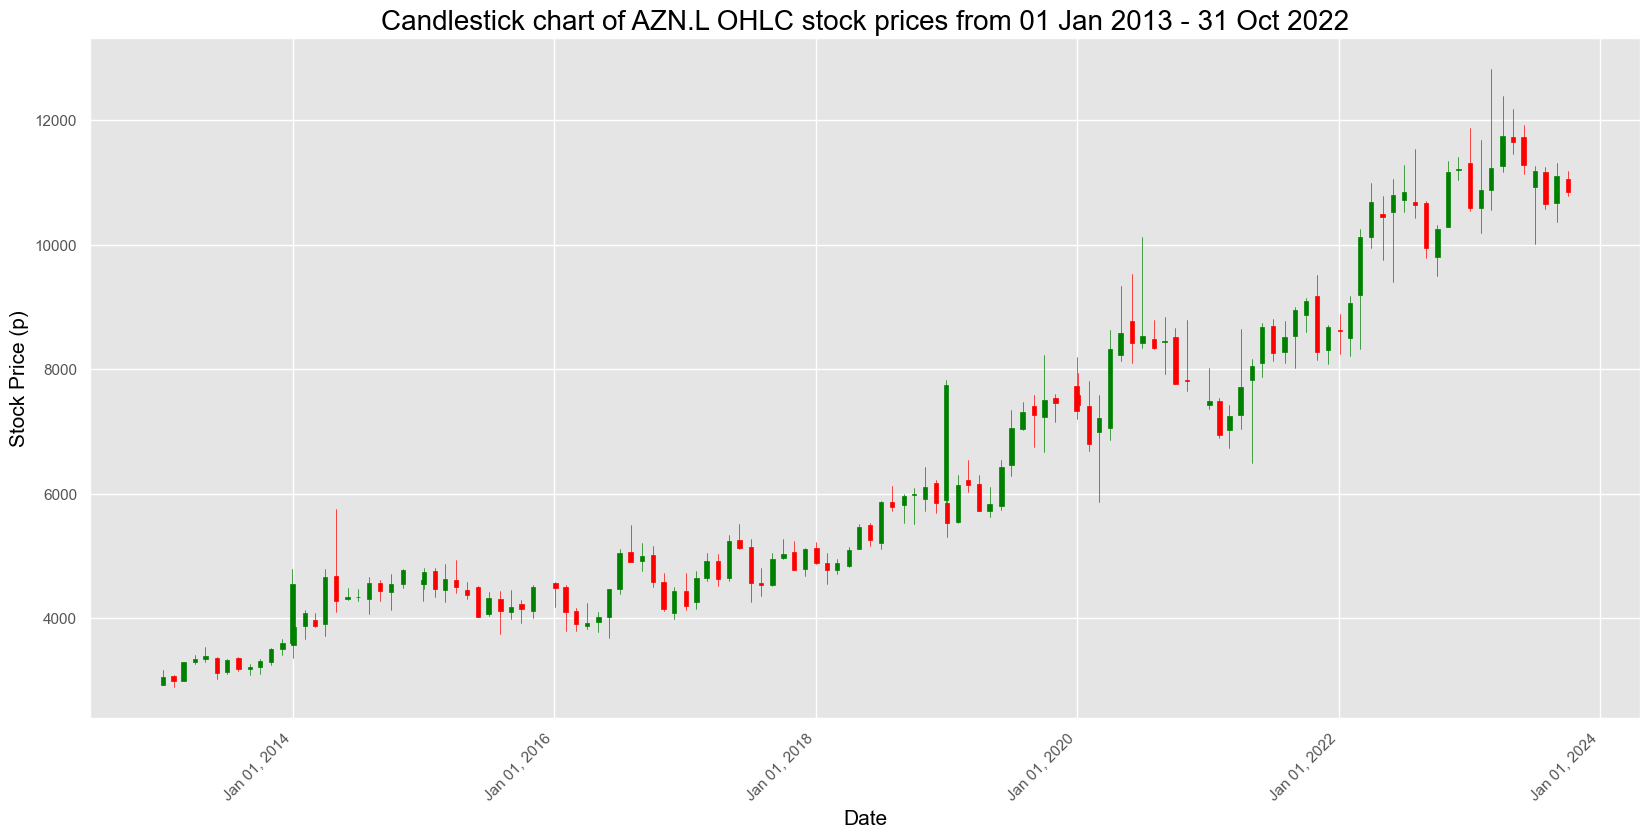

In [302]:
# Plot candlestick chart for 10 year period from 2013-2022
txt = "AZN.L OHLC stock prices from 01 Jan 2013 - 31 Oct 2022"
pandas_candlestick_ohlc(azn, stick="month", txt = txt)

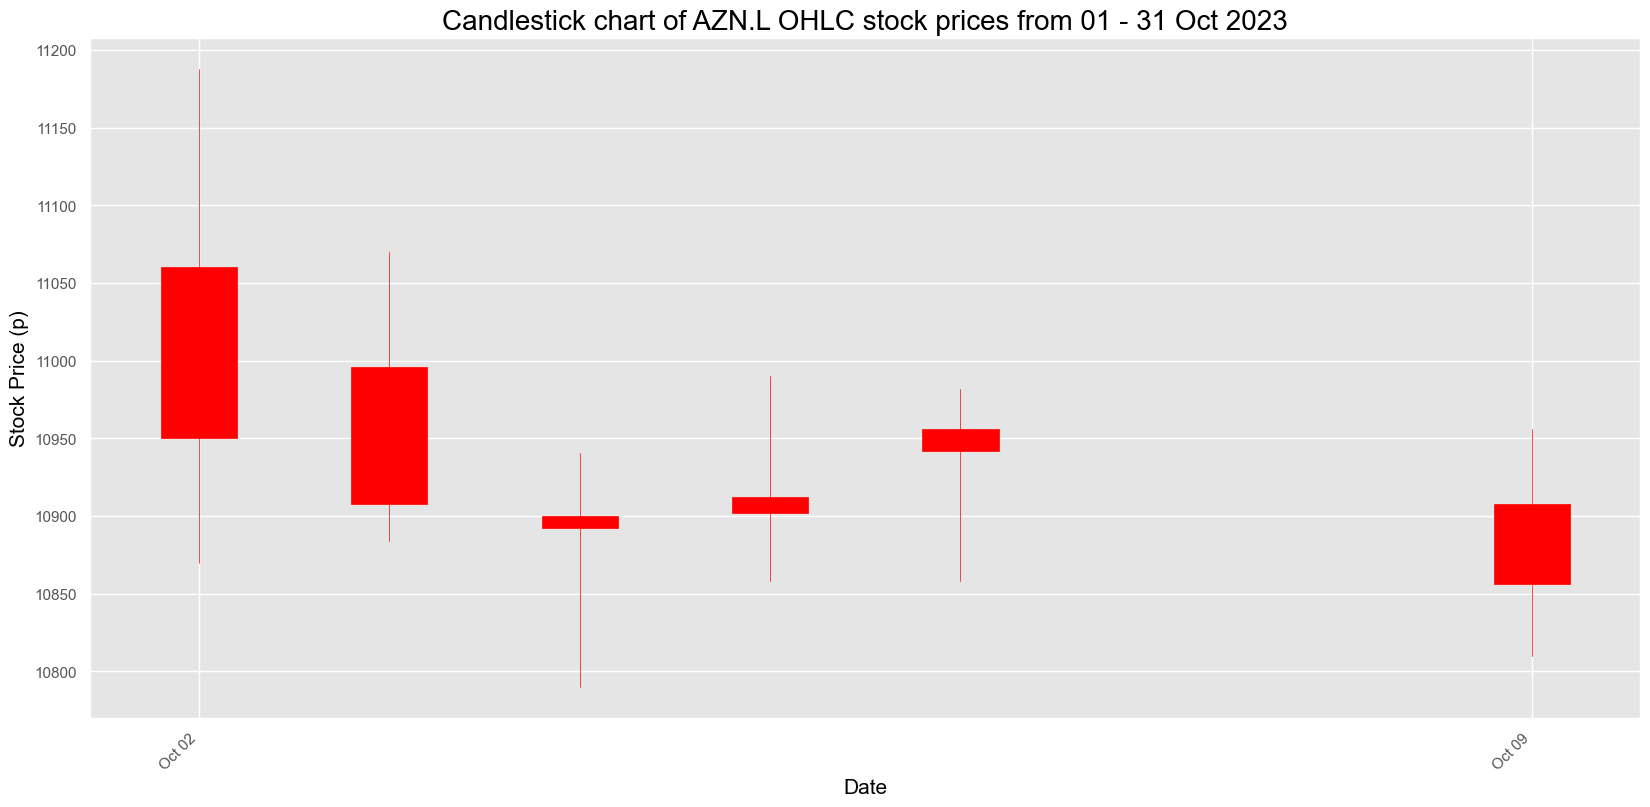

In [176]:
# Plot candlestick chart for one month period for Oct 2023

txt = "AZN.L OHLC stock prices from 01 - 31 Oct 2023"
pandas_candlestick_ohlc(azn['2023-10-01':'2023-10-31'], stick="day", txt = txt)

## 5. Technical Indicators and Strategies

A technical indicator is a series of data points that are derived by applying a formula to the price data of a security. Basically, they are price-derived indicators that use formulas to translate the momentum or price levels into quantifiable time series. 

There are two categories of indicator: **leading** and **lagging**, and four types: **trend**, **momentum**, **volatility** and **volume**, which serve three broad functions: to **alert**, to **confirm** and to **predict**.

## 5.1 Trend-following strategies

Trend-following is about profiting from the prevailing trend through  buying an asset when its price trend goes up, and selling when its trend goes down, expecting price movements to continue.

### 5.1.1 Moving averages
Moving averages smooth a series filtering out noise to help identify trends, one of the fundamental principles of technical analysis being that prices move in trends. Types of moving averages include simple, exponential, smoothed, linear-weighted, MACD, and as lagging indicators they follow the price action and are commonly referred to as trend-following indicators.

### 5.1.2 Simple Moving Average (SMA)

The simplest form of a moving average, known as a Simple Moving Average (SMA), is calculated by taking the arithmetic mean of a given set of values over a set time period.  This model is probably the most naive approach to time series modelling and simply states that the next observation is the mean of all past observations and each value in the time period carries equal weight. 

Modelling this an as average calculation problem we would try to predict the future stock market prices (for example, x<sub>t</sub>+1 ) as an average of the previously observed stock market prices within a fixed size window (for example, x<sub>t</sub>-n, ..., x<sub>t</sub>). This helps smooth out the price data by creating a constantly updated average price so that the impacts of random, short-term fluctuations on
the price of a stock over a specified time-frame are mitigated.

In [303]:
def sma():
  plt.figure(figsize=(15,9))
  ftse100_stocks[ticker]['Adj Close'].loc['2022-01-01':'2022-12-31'].rolling(window=20).mean().plot(label='20 Day Avg')
  ftse100_stocks[ticker]['Adj Close'].loc['2022-01-01':'2022-12-31'].plot(label=f"{label_txt}")
  plt.title(f"{title_txt}", color = 'black', fontsize = 20)
  plt.xlabel('Date', color = 'black', fontsize = 15)
  plt.ylabel('Stock Price (p)', color = 'black', fontsize = 15)
  plt.legend()

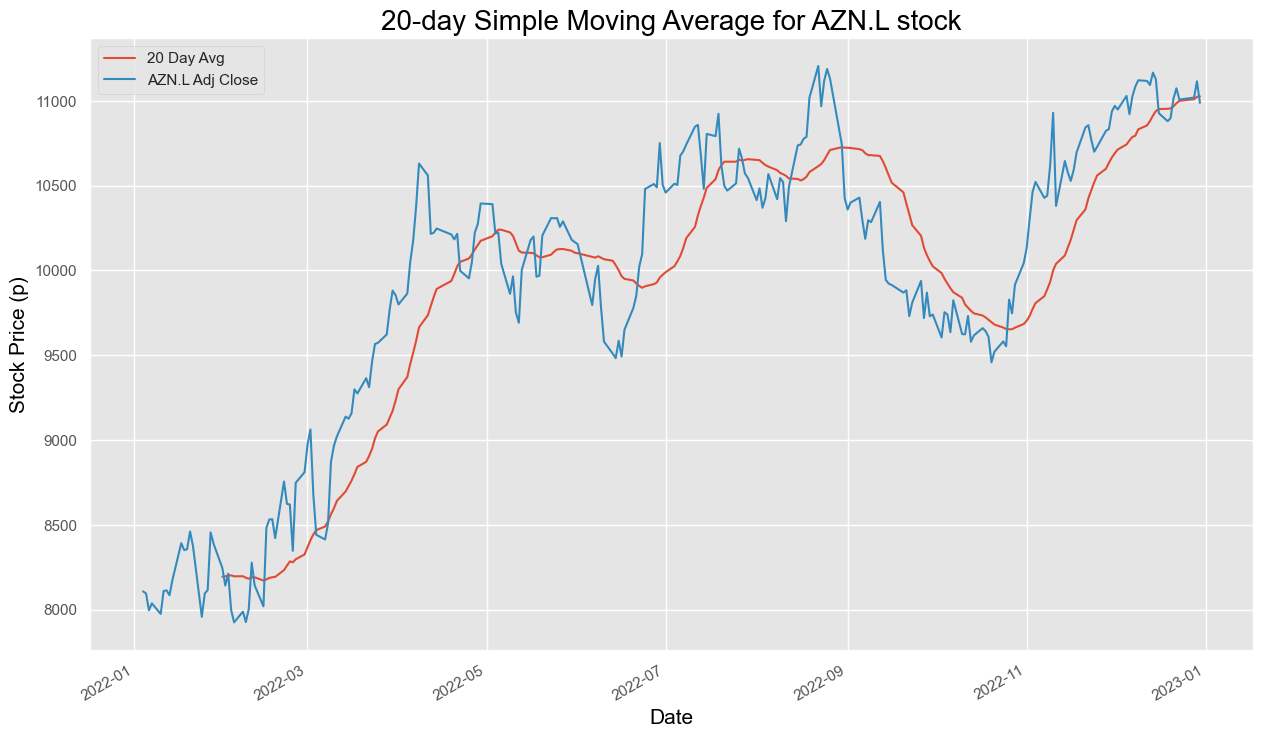

In [304]:
ticker = 'AZN.L'
title_txt = "20-day Simple Moving Average for AZN.L stock"
label_txt = "AZN.L Adj Close"

sma()

The SMA follows the time series removing noise from the
signal and keeping the relevant information about the trend. If the stock price is above its moving average it is assumed that it will likely continue rising in an uptrend. 

### 5.1.3 Moving Average Crossover Strategy

The most popular moving average crossover strategy, and the "Hello World!" of quantitative trading, being the easiest to construct, is based on the simple moving average. When moving averages cross, it is usually confirmation of a change in the prevailing trend, and we want to test whether over the long term the lag caused by the moving average can still give us profitable trades.

Depending on the type of investor or trader (high risk vs. low risk, short-term vs. long-term trading), you can adjust your moving ‘time’ average (10 days, 20 days, 50 days, 200 days, 1 year, 5 years, etc). The longer the period of an SMA, the longer the time horizon of the trend it spots. The most commonly used SMA periods are 20 for short-term (swing) trading, 50 for medium-term (position) trading and 200 for long-term (portfolio) trading.

There is no single right answer and this will vary according to whether a trader is planning to buy when the trend is going down and sell when it's going up, potentially making short-term gains, or to hold for a more long-term investment.

In [179]:
def sma2():
  plt.figure(figsize=(15,9))
  ftse100_stocks[ticker]['Adj Close'].loc['2019-01-01':'2023-10-31'].rolling(window=20).mean().plot(label='20 Day Avg')
  ftse100_stocks[ticker]['Adj Close'].loc['2019-01-01':'2023-10-31'].rolling(window=50).mean().plot(label='50 Day Avg')
  ftse100_stocks[ticker]['Adj Close'].loc['2019-01-01':'2023-10-31'].rolling(window=200).mean().plot(label='200 Day Avg')
  ftse100_stocks[ticker]['Adj Close'].loc['2019-01-01':'2023-10-31'].plot(label=f"{label_txt}")
  plt.title(f"{title_txt}", color = 'black', fontsize = 20)
  plt.xlabel('Date', color = 'black', fontsize = 15)
  plt.ylabel('Stock Price (p)', color = 'black', fontsize = 15)
  plt.legend()

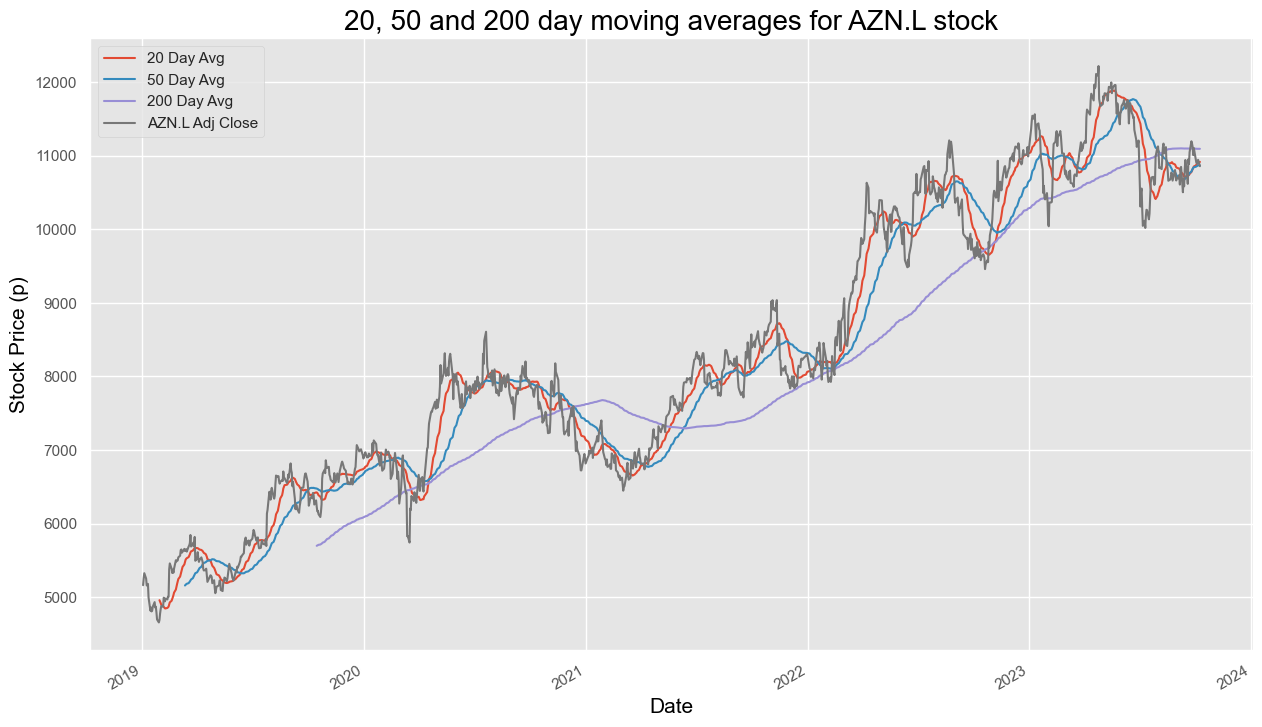

In [180]:
ticker = 'AZN.L'

title_txt = "20, 50 and 200 day moving averages for AZN.L stock"
label_txt = "AZN.L Adj Close"

sma2()

The chart shows that the 20-day moving average is the most sensitive to local changes, and the 200-day moving average the least. Here, the 200-day moving average indicates an overall bullish trend - the stock is trending upward over time. The 20- and 50-day moving averages are at times bearish and at other times bullish.

The major drawback of moving averages, however, is that because they are lagging, and smooth out prices, they tend to recognise reversals too late and are therefore not very helpful when used alone.

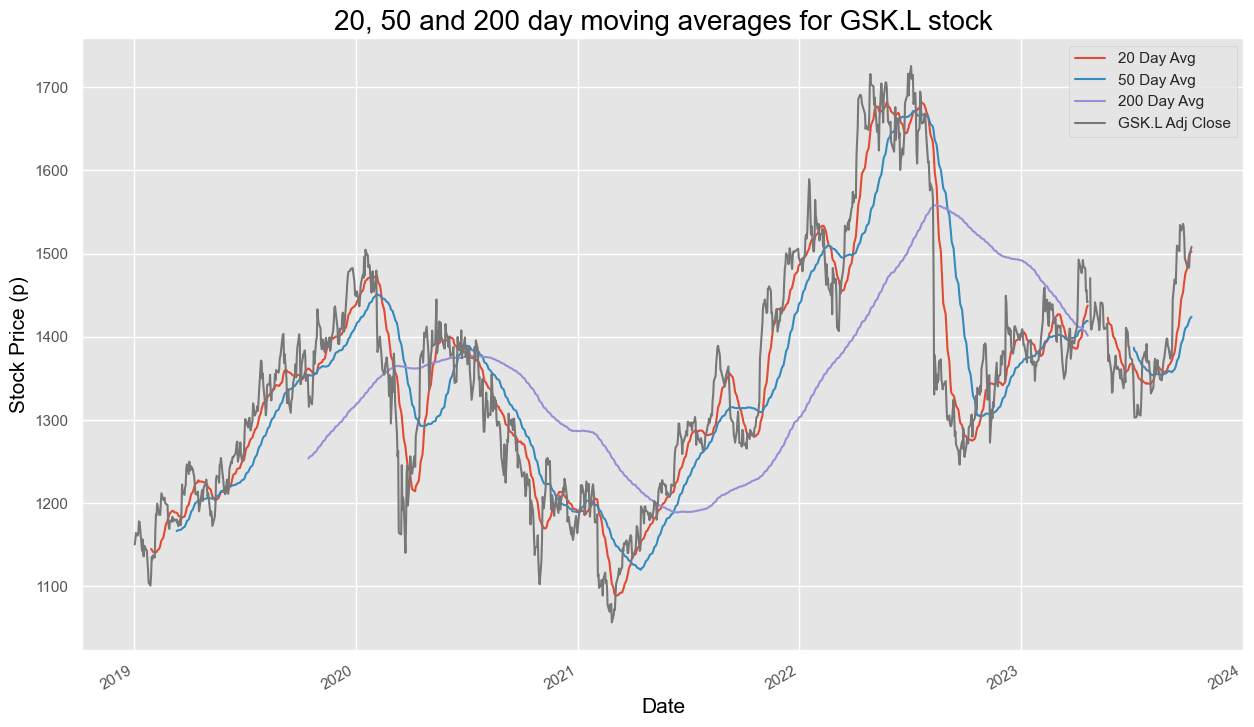

In [181]:
# 20, 50 and 200 day MA repeated for GlaxoSmithKline Adjusted Close price data for the same time period 

ticker = 'GSK.L'

title_txt = "20, 50 and 200 day moving averages for GSK.L stock"
label_txt = "GSK.L Adj Close"

sma2()

### Trading Strategy

The moving average crossover trading strategy will be to take two moving averages - 20-day (fast) and 200-day (slow) - and to go long (buy) when the fast MA goes above the slow MA and to go short (sell) when the fast MA goes below the slow MA.

In [182]:
# Create copy of dataframe for AstraZeneca data for 2010-2019
azn_sma = azn.copy()

In [183]:
azn_sma.head()

Open         High          Low   Close    Adj Close   Volume
Date                                                                      
2013-01-02  2930.0  2969.297119  2923.000000  2969.0  1974.841675  2394731
2013-01-03  2969.5  2982.500000  2952.500000  2980.0  1982.158203  1763172
2013-01-04  2992.5  3005.000000  2975.211914  3000.0  1995.461304  2041101
2013-01-07  2998.5  3004.989990  2976.000000  2985.0  1985.483765  1185261
2013-01-08  2986.5  3005.500000  2958.500000  3000.0  1995.461304  2723178

In [184]:
  # Calculate and add columns for moving averages of Adjusted Close price data
  
azn_sma["20d"] = np.round(azn_sma["Adj Close"].rolling(window = 20, center = False).mean(), 2)
azn_sma["50d"] = np.round(azn_sma["Adj Close"].rolling(window = 50, center = False).mean(), 2)
azn_sma["200d"] = np.round(azn_sma["Adj Close"].rolling(window = 200, center = False).mean(), 2)

In [185]:
azn_sma.tail()

Open          High      Low    Close  Adj Close   Volume  \
Date                                                                      
2023-10-03  10996.0  11070.000000  10884.0  10908.0    10908.0  1297146   
2023-10-04  10900.0  10940.451172  10790.0  10892.0    10892.0  2200732   
2023-10-05  10912.0  10990.000000  10858.0  10902.0    10902.0  1102217   
2023-10-06  10956.0  10982.000000  10858.0  10942.0    10942.0  1250802   
2023-10-09  10908.0  10956.000000  10810.0  10856.0    10856.0  2558599   

                20d       50d      200d  
Date                                     
2023-10-03  10873.3  10850.87  11092.79  
2023-10-04  10887.6  10855.68  11091.61  
2023-10-05  10891.5  10861.70  11091.48  
2023-10-06  10896.3  10867.91  11091.79  
2023-10-09  10914.0  10865.29  11091.58

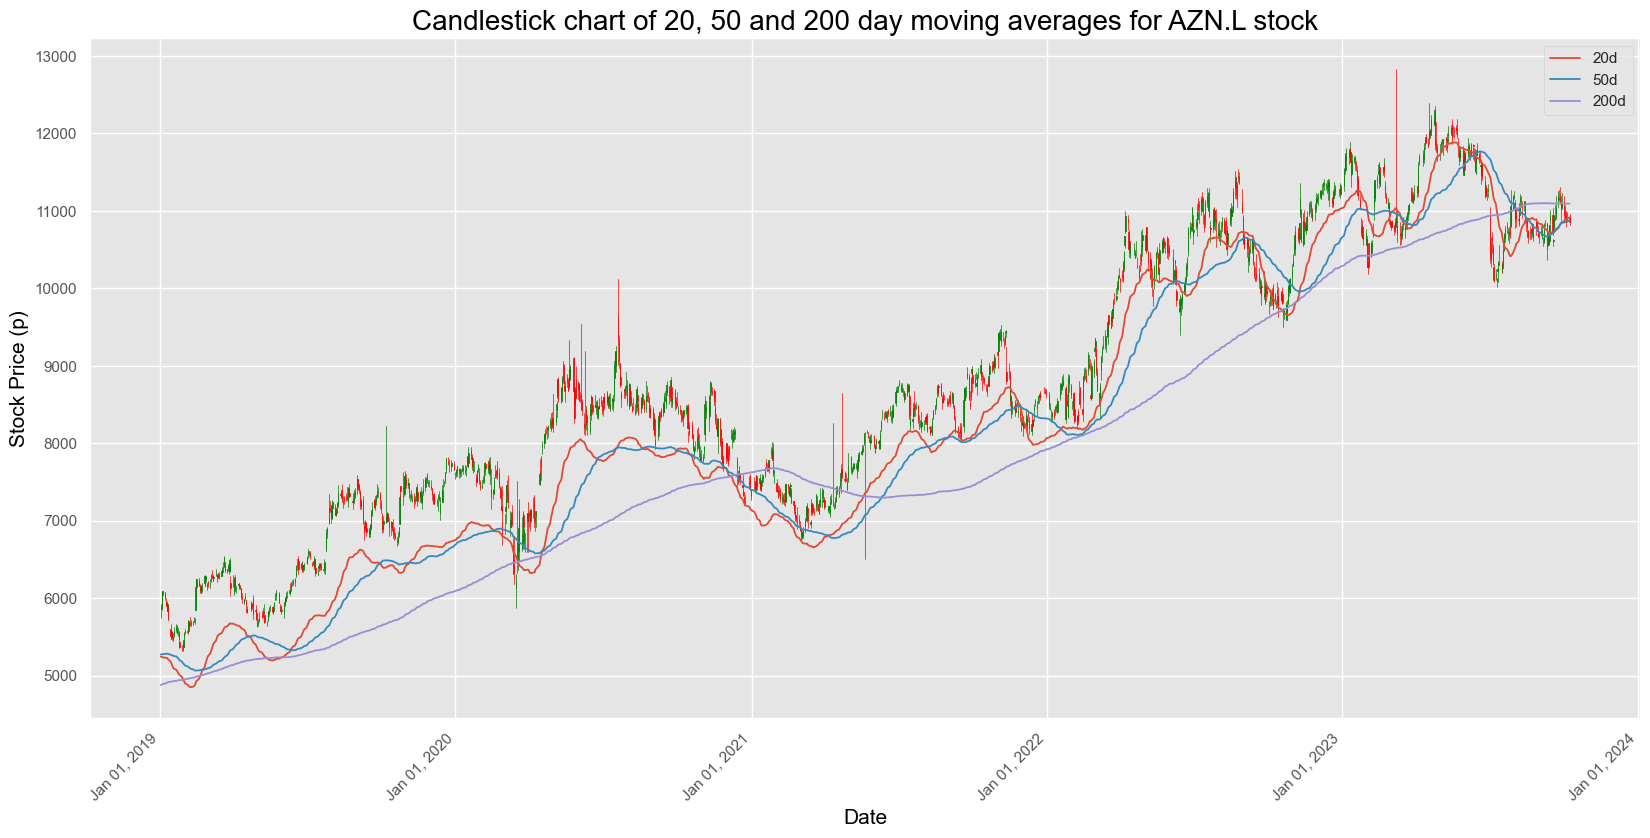

In [186]:
txt = "20, 50 and 200 day moving averages for AZN.L stock"

# Slice rows to plot data from 2016-2019 
pandas_candlestick_ohlc(azn_sma.loc['2019-01-01':'2023-10-31',:], otherseries = ["20d", "50d", "200d"], txt = txt)

### 5.1.4 Exponential Moving Average

In a Simple Moving Average, each value in the time period carries
equal weight, and values outside of the time period are not included in the average. However, the Exponential Moving Average is a cumulative calculation where a different decreasing weight is assigned to each observation. Past values have a diminishing contribution to the average, while more recent values have a greater contribution. This method allows the moving average to be more responsive to changes in the data.

In [187]:
# 20-day EMA for Adjusted Close price for 2019

def ewma():
  plt.figure(figsize=(15,9))
  ftse100_stocks[ticker]['Adj Close'].loc['2022-01-01':'2022-12-31'].ewm(20).mean().plot(label='20 Day Avg')
  ftse100_stocks[ticker]['Adj Close'].loc['2022-01-01':'2022-12-31'].plot(label=f"{label_txt}")
  plt.title(f"{title_txt}", color = 'black', fontsize = 20)
  plt.xlabel('Date', color = 'black', fontsize = 15)
  plt.ylabel('Stock Price (p)', color = 'black', fontsize = 15)
  plt.legend()

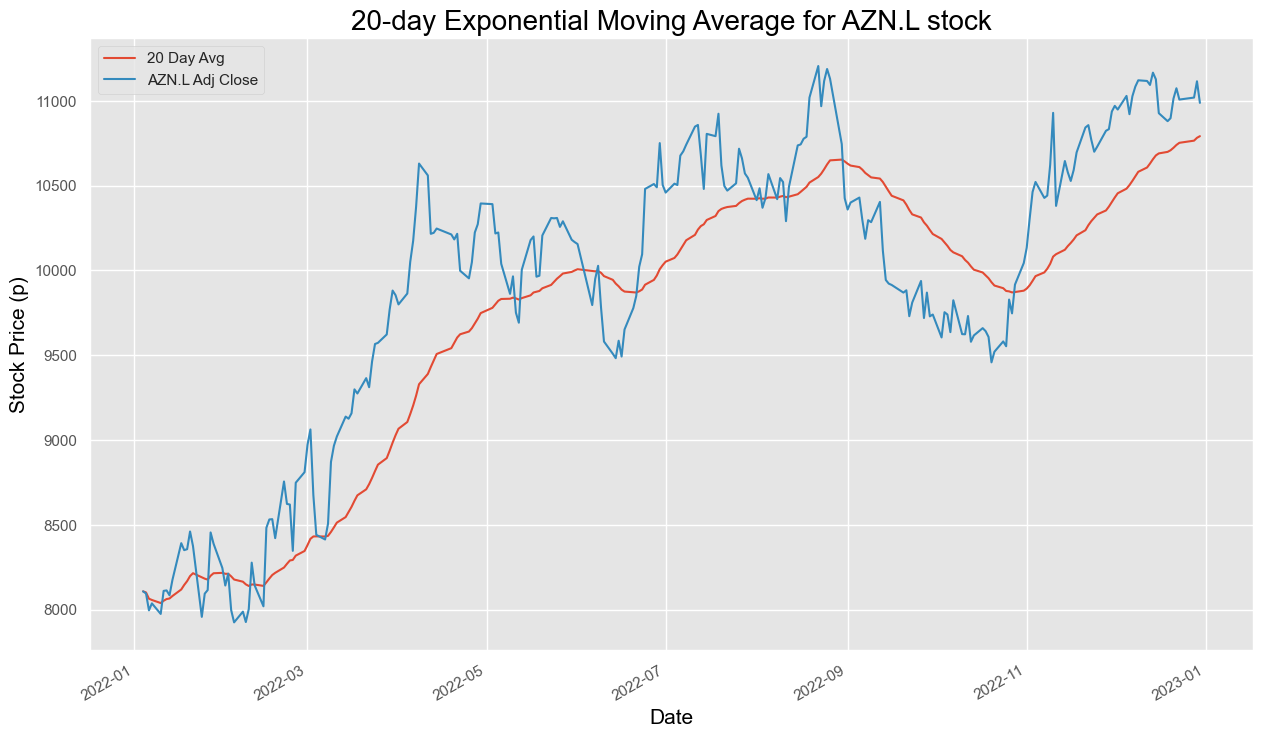

In [188]:
ticker = 'AZN.L'
title_txt = "20-day Exponential Moving Average for AZN.L stock"
label_txt = "AZN.L Adj Close"

ewma()

In [189]:
# 20-, 50- and 200-day EMA for Adjusted Close price for 2016-2019

def ewma2():
  plt.figure(figsize=(15,9))
  ftse100_stocks[ticker]['Adj Close'].loc['2019-01-01':'2023-10-31'].ewm(20).mean().plot(label='20 Day Avg')
  ftse100_stocks[ticker]['Adj Close'].loc['2019-01-01':'2023-10-31'].ewm(50).mean().plot(label='50 Day Avg')
  ftse100_stocks[ticker]['Adj Close'].loc['2019-01-01':'2023-10-31'].ewm(200).mean().plot(label='200 Day Avg')
  ftse100_stocks[ticker]['Adj Close'].loc['2019-01-01':'2023-10-31'].plot(label=f"{label_txt}")
  plt.title(f"{title_txt}", color = 'black', fontsize = 20)
  plt.xlabel('Date', color = 'black', fontsize = 15)
  plt.ylabel('Stock Price (p)', color = 'black', fontsize = 15)
  plt.legend()

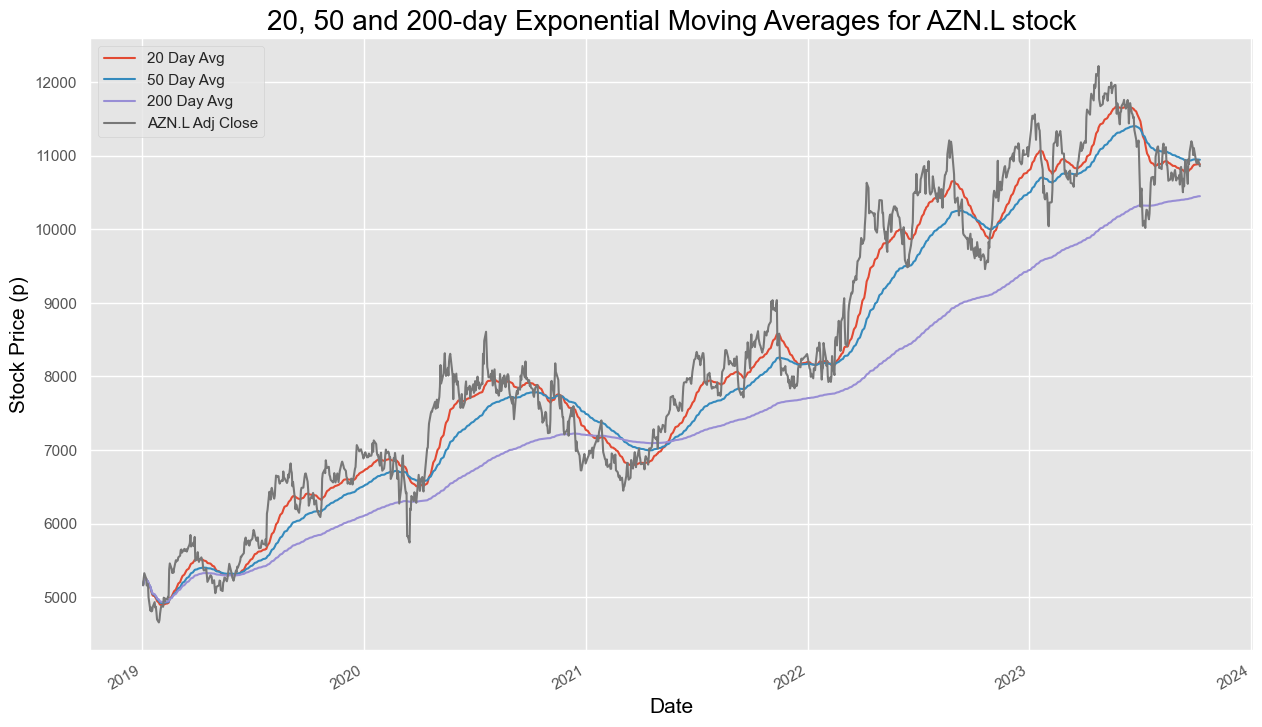

In [190]:
ticker = 'AZN.L'
title_txt = "20, 50 and 200-day Exponential Moving Averages for AZN.L stock"
label_txt = "AZN.L Adj Close"

ewma2()

### 5.1.5 Triple Moving Average Crossover Strategy

This strategy uses three moving moving averages - short/fast, middle/medium and long/slow - and has two buy and sell signals. 

The first is to buy when the middle/medium moving average crosses above the long/slow moving average and the short/fast moving average crosses above the middle/medium moving average. If we use this buy signal the strategy is to sell if the short/fast moving average crosses below the middle/medium moving average.

The second is to buy when the middle/medium moving average crosses below the long/slow moving average and the short/fast moving average crosses below the middle/medium moving average. If we use this buy signal the strategy is to sell if the short/fast moving average crosses above the middle/medium moving average.

In [191]:
azn[['Adj Close']]['2023-05-01':'2023-10-31']

Adj Close
Date                    
2023-05-02  11698.398438
2023-05-03  11807.692383
2023-05-04  11773.911133
2023-05-05  11845.448242
2023-05-09  11837.500000
...                  ...
2023-10-03  10908.000000
2023-10-04  10892.000000
2023-10-05  10902.000000
2023-10-06  10942.000000
2023-10-09  10856.000000

[112 rows x 1 columns]

In [192]:
def adj_6mo():
  sns.set(rc={'figure.figsize':(15, 9)})
  ftse100_stocks[ticker]['Adj Close'].loc['2023-05-01':'2023-10-31'].plot(label=f"{label_txt}")
  plt.title(f"{title_txt}", color = 'black', fontsize = 20)
  plt.xlabel('Date', color = 'black', fontsize = 15)
  plt.ylabel('Stock Price (p)', color = 'black', fontsize = 15)
  plt.legend()

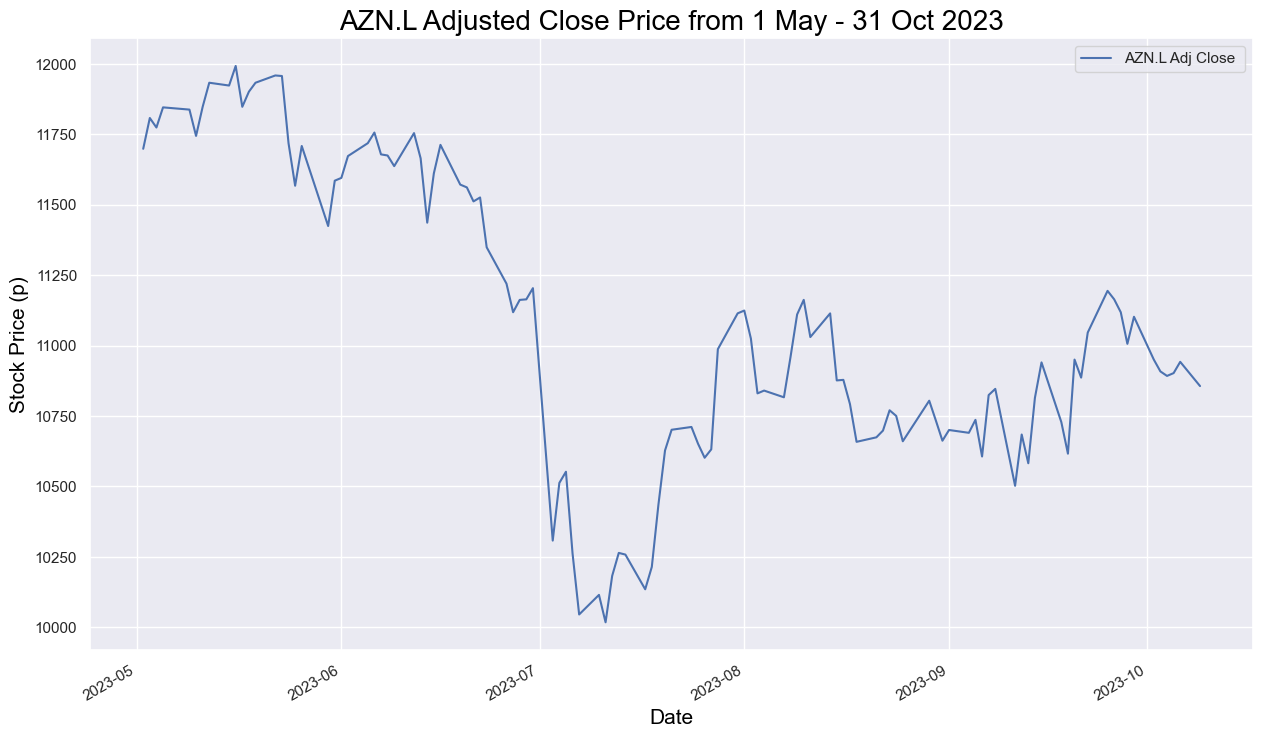

In [193]:
ticker = 'AZN.L'
title_txt = "AZN.L Adjusted Close Price from 1 May - 31 Oct 2023"
label_txt = "AZN.L Adj Close "

adj_6mo()

In [194]:
azn_adj_6mo = azn[['Adj Close']]['2023-05-01':'2023-10-31']

In [195]:
ShortEMA = azn_adj_6mo['Adj Close'].ewm(span=5, adjust=False).mean()
MiddleEMA = azn_adj_6mo['Adj Close'].ewm(span=21, adjust=False).mean()
LongEMA = azn_adj_6mo['Adj Close'].ewm(span=63, adjust=False).mean()

In [196]:
def ewma3():
  sns.set(rc={'figure.figsize':(15, 9)})
  plt.plot(ftse100_stocks[ticker]['Adj Close'].loc['2023-05-01':'2023-10-31'], label=f"{label_txt}", color = 'blue')
  plt.plot(ShortEMA, label = 'Short/Fast EMA', color = 'red')
  plt.plot(MiddleEMA, label = 'Middle/Medium EMA', color = 'orange')
  plt.plot(LongEMA, label = 'Long/Slow EMA', color = 'green')
  plt.title(f"{title_txt}", color = 'black', fontsize = 20)
  plt.xlabel('Date', color = 'black', fontsize = 15)
  plt.ylabel('Stock Price (p)', color = 'black', fontsize = 15)
  plt.legend()

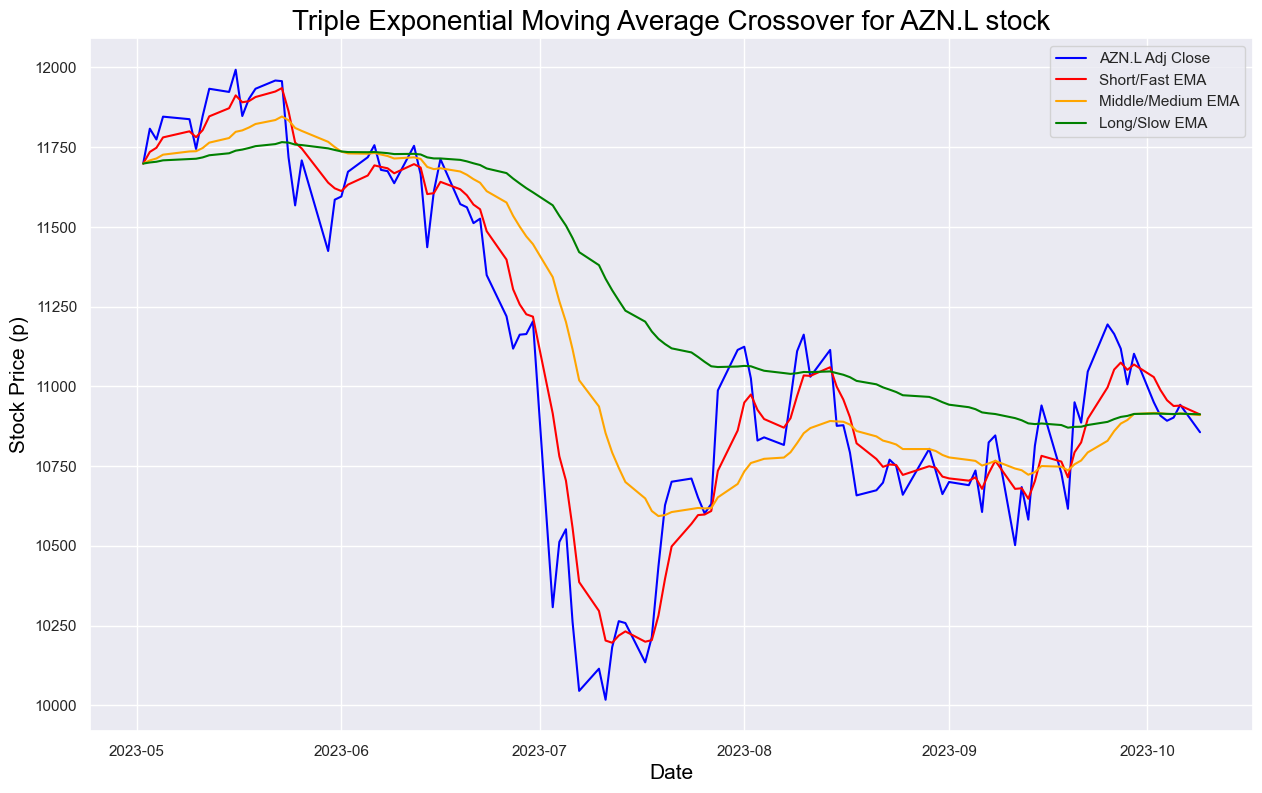

In [197]:
ticker = 'AZN.L'
title_txt = "Triple Exponential Moving Average Crossover for AZN.L stock"
label_txt = "AZN.L Adj Close"

ewma3()

In [198]:
azn_adj_6mo['Short'] = ShortEMA
azn_adj_6mo['Middle'] = MiddleEMA
azn_adj_6mo['Long'] = LongEMA

In [199]:
azn_adj_6mo.head()

Adj Close         Short        Middle          Long
Date                                                              
2023-05-02  11698.398438  11698.398438  11698.398438  11698.398438
2023-05-03  11807.692383  11734.829753  11708.334251  11701.813873
2023-05-04  11773.911133  11747.856879  11714.295785  11704.066913
2023-05-05  11845.448242  11780.387334  11726.218736  11708.485079
2023-05-09  11837.500000  11799.424889  11736.335215  11712.516795

In [200]:
def buy_sell_ewma3(data):
  
  buy_list = []
  sell_list = []
  flag_long = False
  flag_short = False

  for i in range(0, len(data)):
    if data['Middle'][i] < data['Long'][i] and data['Short'][i] < data['Middle'][i] and flag_long == False and flag_short == False:
      buy_list.append(data['Adj Close'][i])
      sell_list.append(np.nan)
      flag_short = True
    elif flag_short == True and data['Short'][i] > data['Middle'][i]:
      sell_list.append(data['Adj Close'][i])
      buy_list.append(np.nan)
      flag_short = False
    elif data['Middle'][i] > data['Long'][i] and data['Short'][i] > data['Middle'][i] and flag_long == False and flag_short == False:
      buy_list.append(data['Adj Close'][i])
      sell_list.append(np.nan)
      flag_long = True
    elif flag_long == True and data['Short'][i] < data['Middle'][i]:
      sell_list.append(data['Adj Close'][i])
      buy_list.append(np.nan)
      flag_long = False
    else:
      buy_list.append(np.nan)
      sell_list.append(np.nan)
  
  return (buy_list, sell_list)

In [201]:
azn_adj_6mo['Buy'] = buy_sell_ewma3(azn_adj_6mo)[0]
azn_adj_6mo['Sell'] = buy_sell_ewma3(azn_adj_6mo)[1]

In [202]:
def buy_sell_ewma3_plot():
  sns.set(rc={'figure.figsize':(18, 10)})
  plt.plot(ftse100_stocks[ticker]['Adj Close'].loc['2023-05-01':'2023-10-31'], label=f"{label_txt}", color = 'blue', alpha = 0.35)
  plt.plot(ShortEMA, label = 'Short/Fast EMA', color = 'red', alpha = 0.35)
  plt.plot(MiddleEMA, label = 'Middle/Medium EMA', color = 'orange', alpha = 0.35)
  plt.plot(LongEMA, label = 'Long/Slow EMA', color = 'green', alpha = 0.35)
  plt.scatter(azn_adj_6mo.index, azn_adj_6mo['Buy'], color = 'green', label = 'Buy Signal', marker = '^', alpha = 1)
  plt.scatter(azn_adj_6mo.index, azn_adj_6mo['Sell'], color = 'red', label = 'Sell Signal', marker='v', alpha = 1)
  plt.title(f"{title_txt}", color = 'black', fontsize = 20)
  plt.xlabel('Date', color = 'black', fontsize = 15)
  plt.ylabel('Stock Price (p)', color = 'black', fontsize = 15)
  plt.legend()

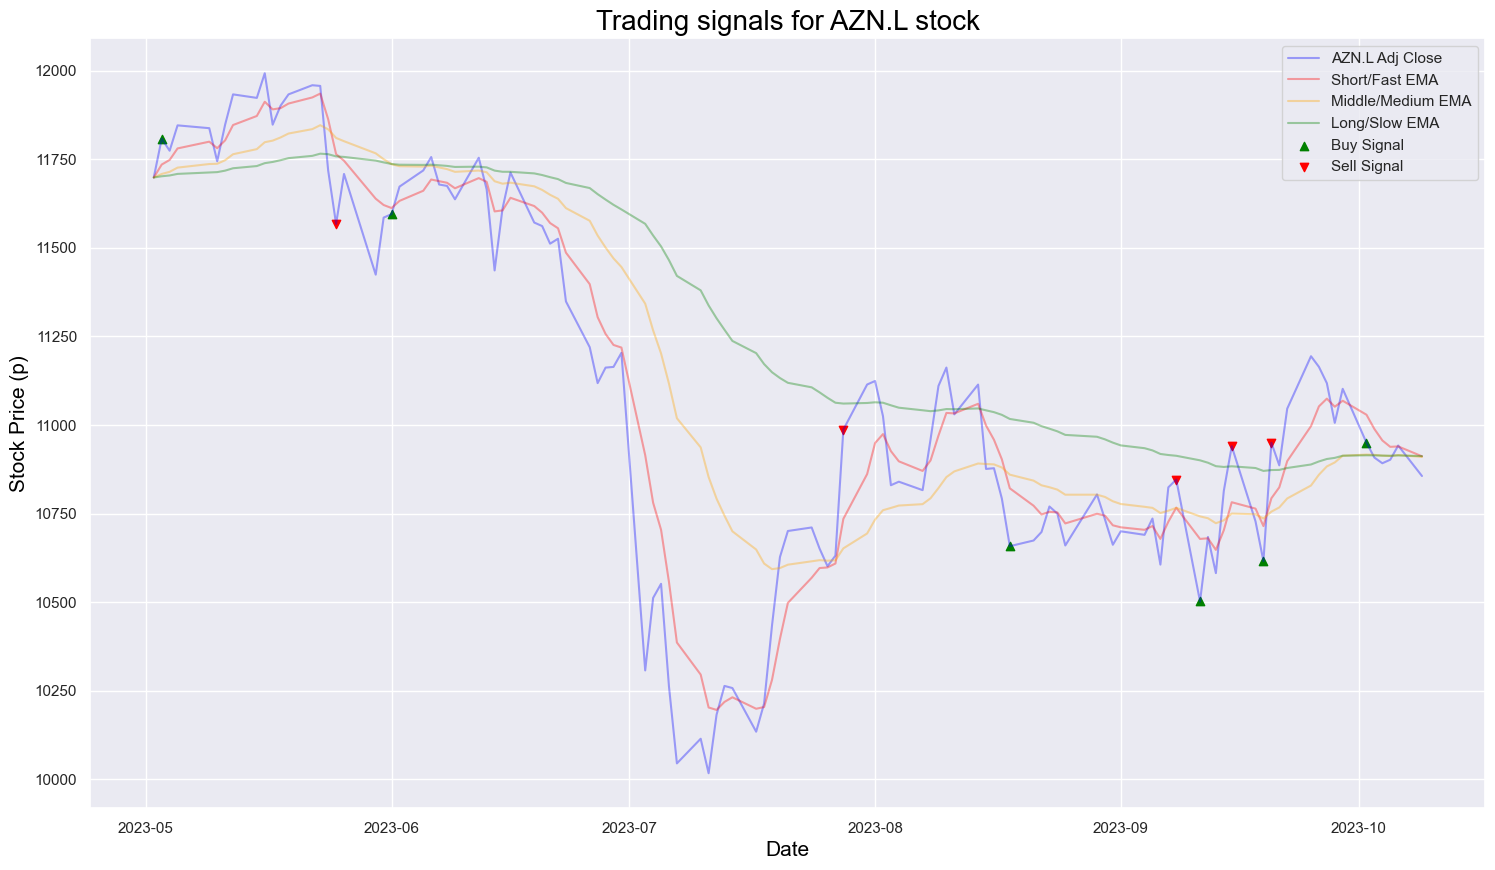

In [203]:
ticker = 'AZN.L'
title_txt = "Trading signals for AZN.L stock"
label_txt = "AZN.L Adj Close"

buy_sell_ewma3_plot()

### 5.1.6 Exponential Smoothing

Single Exponential Smoothing, also known as Simple Exponential Smoothing, is a time series forecasting method for univariate data without a trend or seasonality. It requires an alpha parameter, also called the smoothing factor or smoothing coefficient, to control the rate at which the influence of the observations at prior time steps decay exponentially.

In [204]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def plot_exponential_smoothing(series, alphas):
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label=f"Alpha {alpha}")
    plt.plot(series.values, "c", label = f"{label_txt}")
    plt.xlabel('Days', color = 'black', fontsize = 15)
    plt.ylabel('Stock Price (p)', color = 'black', fontsize = 15)
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title(f"{title_txt}", color = 'black', fontsize = 20)
    plt.grid(True);

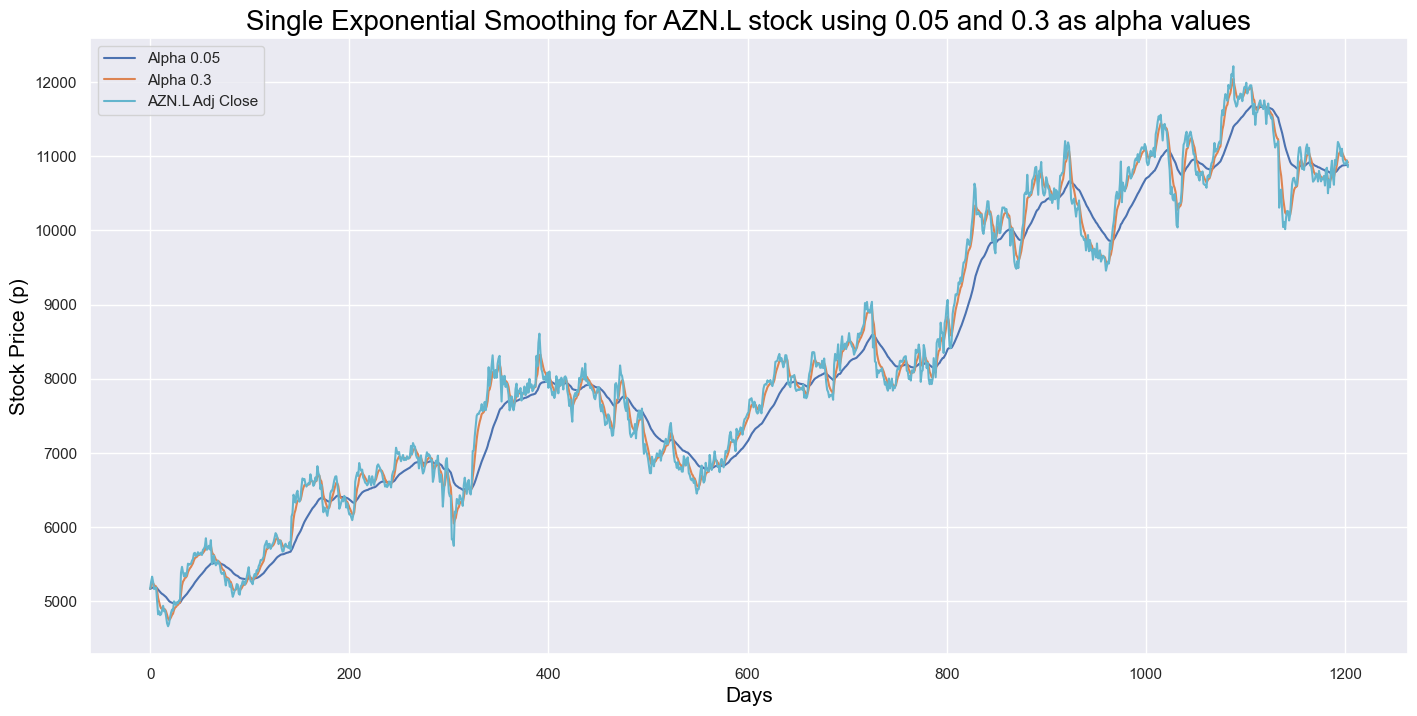

In [205]:
ticker = 'AZN.L'
title_txt = "Single Exponential Smoothing for AZN.L stock using 0.05 and 0.3 as alpha values"
label_txt = "AZN.L Adj Close"

plot_exponential_smoothing(ftse100_stocks[ticker]['Adj Close'].loc['2019-01-01':'2023-10-31'], [0.05, 0.3])

The smaller the smoothing factor (coefficient), the smoother the time series will be. As the smoothing factor approaches 0, we approach the moving average model so the smoothing factor of 0.05 produces a smoother time series than 0.3. This indicates slow learning (past observations have a large influence on forecasts). A value close to 1 indicates fast learning (that is, only the most recent values influence the forecasts).

Double Exponential Smoothing (Holt’s Linear Trend Model) is an extension being a recursive use of Exponential Smoothing twice where beta is the trend smoothing factor, and takes values between 0 and 1. It explicitly adds support for trends.

In [206]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label=f"Alpha {alpha}, beta {beta}")
    plt.plot(series.values, label = f"{label_txt}")
    plt.xlabel('Days', color = 'black', fontsize = 15)
    plt.ylabel('Stock Price (p)', color = 'black', fontsize = 15)
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title(f"{title_txt}", color = 'black', fontsize = 20)
    plt.grid(True)

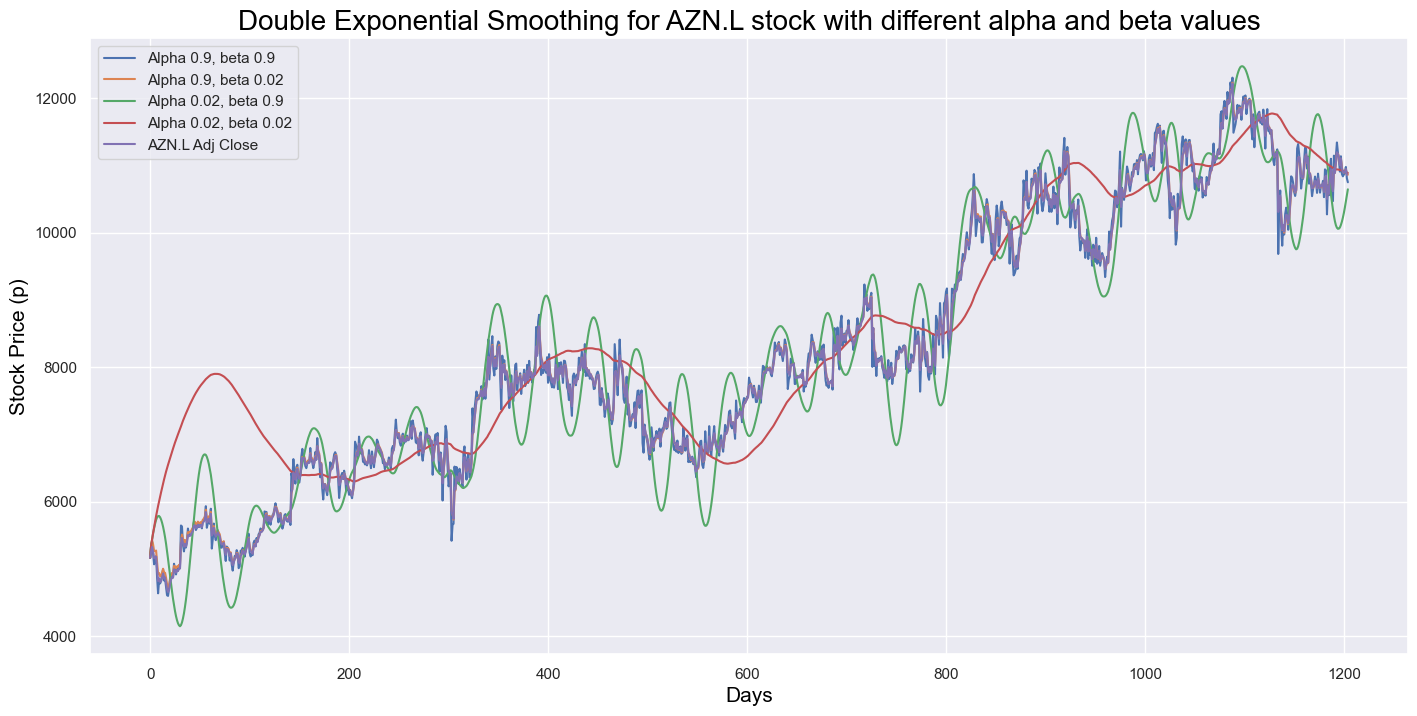

In [207]:
ticker = 'AZN.L'
title_txt = "Double Exponential Smoothing for AZN.L stock with different alpha and beta values"
label_txt = "AZN.L Adj Close"

plot_double_exponential_smoothing(ftse100_stocks[ticker]['Adj Close'].loc['2019-01-01':'2023-10-31'], alphas=[0.9, 0.02], betas=[0.9, 0.02])

The third main type is Triple Exponential Smoothing (Holt Winters Method) which is an extension of Exponential Smoothing that explicitly adds support for seasonality, or periodic fluctuations.

### 5.1.7 Moving average convergence divergence (MACD)

The MACD is a trend-following momentum indicator turning two trend-following indicators, moving averages, into a momentum oscillator by subtracting the longer moving average from the shorter one.

It is useful although lacking one prediction element - because it is unbounded it is not particularly useful for identifying overbought and oversold levels. Traders can look for signal line crossovers, neutral/centreline crossovers (otherwise known as the 50 level) and divergences from the price action to generate signals. 

The default parameters are 26 EMA of prices, 12 EMA of prices and a 9-moving average of the difference between the first two.

In [208]:
def adj_3mo():
  sns.set(rc={'figure.figsize':(15, 9)})
  ftse100_stocks[ticker]['Adj Close'].loc['2023-08-01':'2023-10-31'].plot(label=f"{label_txt}")
  plt.title(f"{title_txt}", color = 'black', fontsize = 20)
  plt.xlabel('Date', color = 'black', fontsize = 15)
  plt.ylabel('Stock Price (p)', color = 'black', fontsize = 15)
  plt.legend()


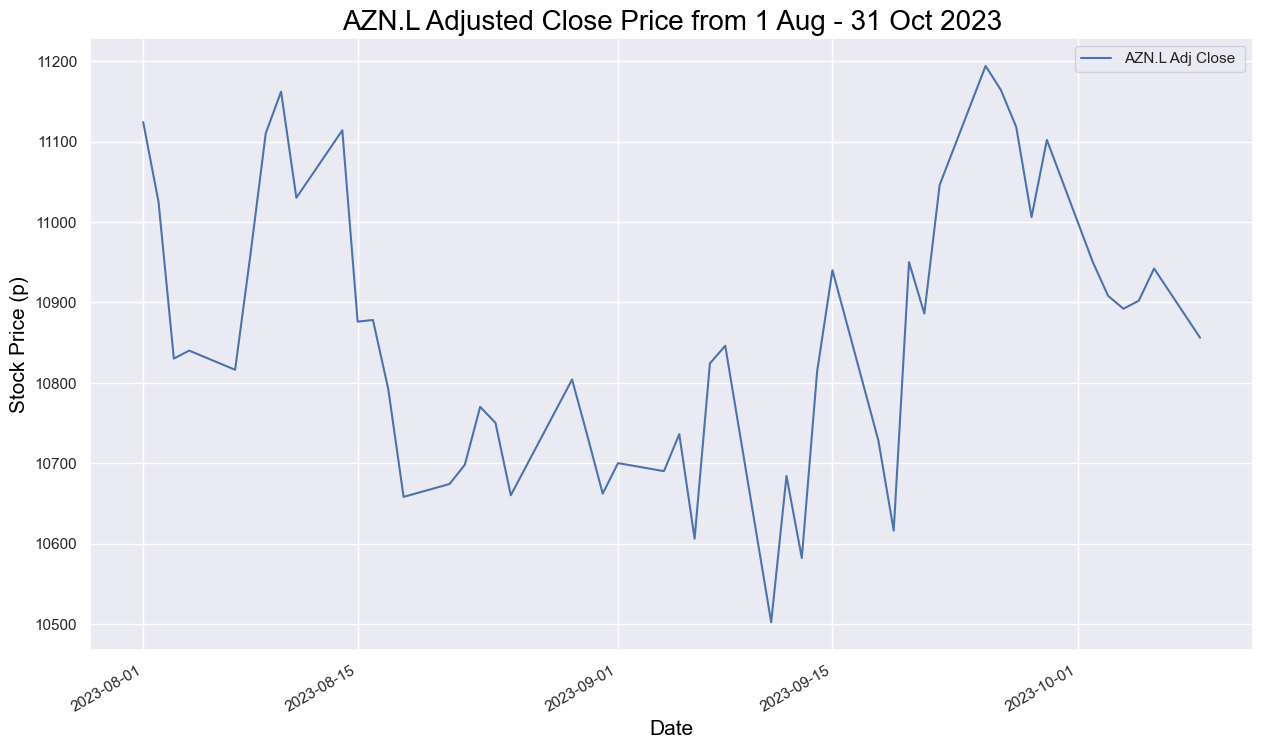

In [209]:
ticker = 'AZN.L'
title_txt = "AZN.L Adjusted Close Price from 1 Aug - 31 Oct 2023"
label_txt = "AZN.L Adj Close "

adj_3mo()

In [210]:
azn_adj_3mo = azn[['Adj Close']]['2023-08-01':'2023-10-31']

In [211]:
ShortEMA = azn_adj_3mo['Adj Close'].ewm(span=12, adjust=False).mean()
LongEMA = azn_adj_3mo['Adj Close'].ewm(span=26, adjust=False).mean()
MACD = ShortEMA - LongEMA
signal = MACD.ewm(span=9, adjust=False).mean()

In [212]:
MACD.head()

Date
2023-08-01     0.000000
2023-08-02    -7.926026
2023-08-03   -29.580462
2023-08-04   -45.416509
2023-08-07   -59.208324
Name: Adj Close, dtype: float64

In [213]:
def macd():
  plt.figure(figsize=(15, 9))
  # plt.plot(azn_adj_3mo.index, MACD, label = f"{macd_label_txt}", color= 'red')
  plt.plot(MACD, label = f"{macd_label_txt}", color= 'red')
  # plt.plot(azn_adj_3mo.index, signal, label = f"{sig_label_txt}", color= 'blue')
  plt.plot(signal, label = f"{sig_label_txt}", color= 'blue')
  plt.title(f"{title_txt}", color = 'black', fontsize = 20)
  plt.xticks (rotation = 45)
  plt.xlabel('Date', color = 'black', fontsize = 15)
  plt.legend(loc='upper left')
  plt.show()

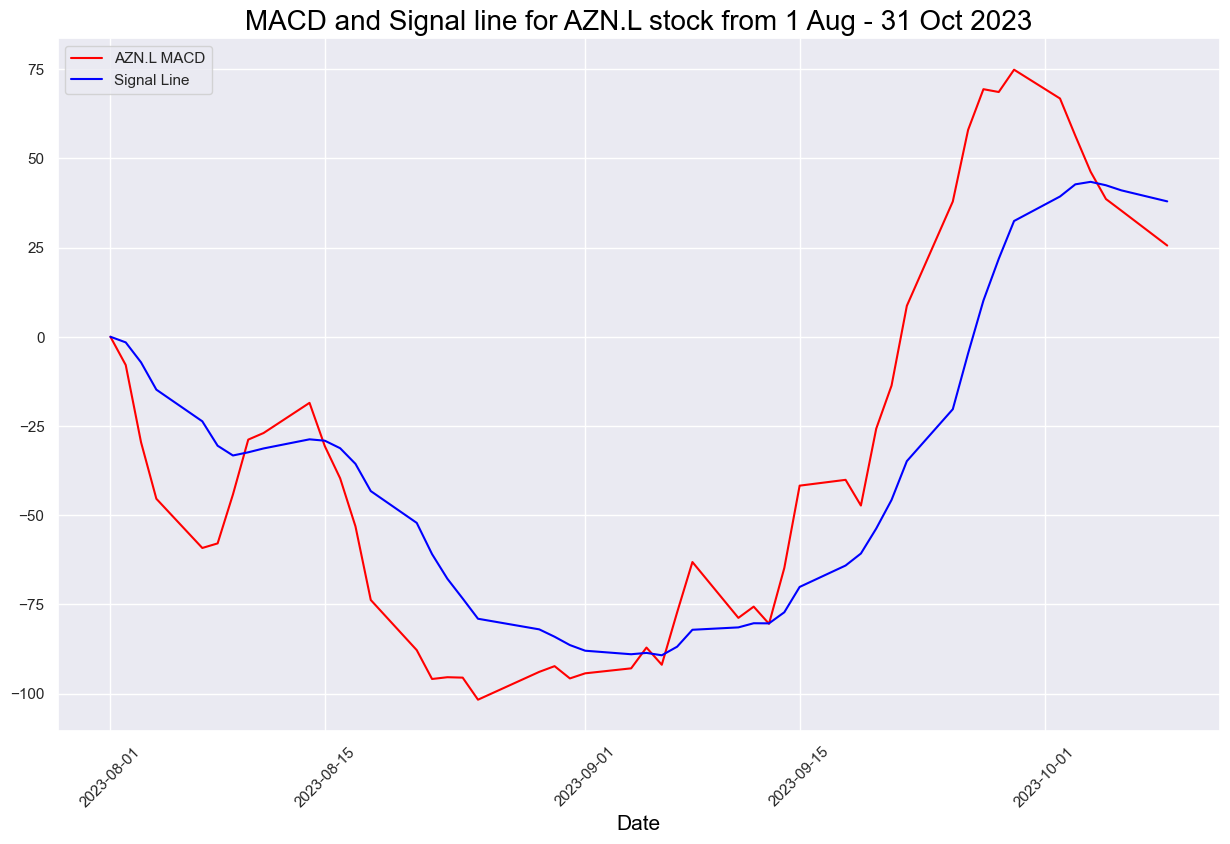

In [214]:
ticker = 'AZN.L'
title_txt = 'MACD and Signal line for AZN.L stock from 1 Aug - 31 Oct 2023'
macd_label_txt ="AZN.L MACD"
sig_label_txt = "Signal Line"

macd()

When the MACD line crosses above the signal line this indicates a good time to buy.

In [215]:
# Create new columns for the MACD and Signal Line data

azn_adj_3mo['MACD'] = MACD
azn_adj_3mo['Signal Line'] = signal
azn_adj_3mo.head()

Adj Close       MACD  Signal Line
Date                                            
2023-08-01  11124.110352   0.000000     0.000000
2023-08-02  11024.751953  -7.926026    -1.585205
2023-08-03  10830.010742 -29.580462    -7.184257
2023-08-04  10839.946289 -45.416509   -14.830707
2023-08-07  10816.100586 -59.208324   -23.706230

In [216]:
# Function to signal when to buy and sell

def buy_sell_macd(signal):
  Buy = []
  Sell = []
  flag = -1

  for i in range(0, len(signal)):
    if signal['MACD'][i] < signal['Signal Line'][i]:
      Sell.append(np.nan)
      if flag != 1:
        Buy.append(signal['Adj Close'][i])
        flag = 1
      else:
        Buy.append(np.nan)
    elif signal['MACD'][i] > signal['Signal Line'][i]:
      Buy.append(np.nan)
      if flag != 0:
        Sell.append(signal['Adj Close'][i])
        flag = 0
      else:
        Sell.append(np.nan)
    else:
      Buy.append(np.nan)
      Sell.append(np.nan)

  return (Buy, Sell)

In [217]:
# Create buy and sell columns
a = buy_sell_macd(azn_adj_3mo)
print(a[0])
print(a[1])
azn_adj_3mo['Buy_Signal_Price'] = a[0]
azn_adj_3mo['Sell_Signal_Price'] = a[1]

[nan, 11024.751953125, nan, nan, nan, nan, nan, nan, nan, nan, 10876.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 10606.0, nan, nan, nan, nan, 10582.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 10902.0, nan, nan]
[nan, nan, nan, nan, nan, nan, nan, 11162.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 10736.0, nan, 10824.0, nan, nan, nan, nan, 10814.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]


In [218]:
azn_adj_3mo.head()

Adj Close       MACD  Signal Line  Buy_Signal_Price  \
Date                                                                 
2023-08-01  11124.110352   0.000000     0.000000               NaN   
2023-08-02  11024.751953  -7.926026    -1.585205      11024.751953   
2023-08-03  10830.010742 -29.580462    -7.184257               NaN   
2023-08-04  10839.946289 -45.416509   -14.830707               NaN   
2023-08-07  10816.100586 -59.208324   -23.706230               NaN   

            Sell_Signal_Price  
Date                           
2023-08-01                NaN  
2023-08-02                NaN  
2023-08-03                NaN  
2023-08-04                NaN  
2023-08-07                NaN

In [219]:
# Plot buy and sell signals

def buy_sell_macd_plot():
  plt.figure(figsize=(20, 10))
  plt.scatter(azn_adj_3mo.index, azn_adj_3mo['Buy_Signal_Price'], color='green', label='Buy', marker='^', alpha=1)
  plt.scatter(azn_adj_3mo.index, azn_adj_3mo['Sell_Signal_Price'], color='red', label='Sell', marker='v', alpha=1)
  plt.plot(azn_adj_3mo['Adj Close'], label='Adj Close Price', alpha = 0.35)
  plt.title(f"{title_txt}", color = 'black', fontsize = 20)
  plt.xlabel('Date', color = 'black', fontsize = 15)
  plt.ylabel('Adj Close Price')
  plt.legend(loc = 'upper left')
  plt.show()

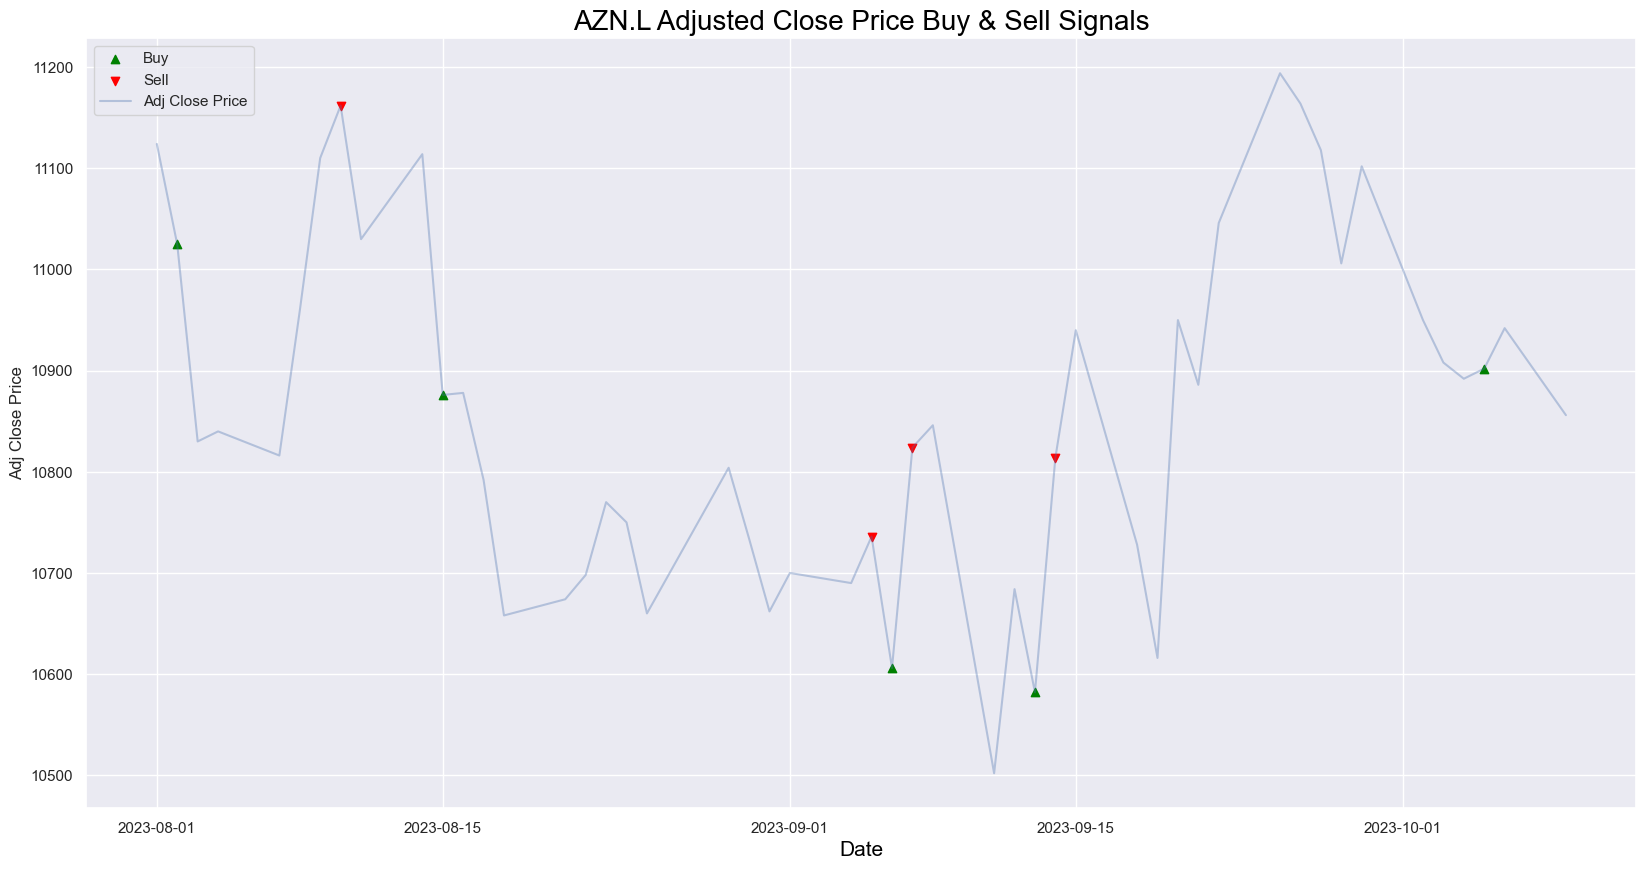

In [220]:
ticker = 'AZN.L'
title_txt = 'AZN.L Adjusted Close Price Buy & Sell Signals'

buy_sell_macd_plot()

## 5.2 Momentum Strategies

In momentum algorithmic trading strategies stocks have momentum (i.e. upward or downward trends) that we can detect and exploit.

### 5.2.1 Relative Strength Index (RSI)

The RSI is a momentum indicator. A typical momentum strategy will buy stocks that have been showing an upward trend in hopes that the trend will continue, and make predictions based on whether the past recent values were going up or going down. 

The RSI determines the level of overbought (70) and oversold (30) zones using a default lookback period of 14 i.e. it uses the last 14 values to calculate its values. The idea is to buy when the RSI touches the 30 barrier and sell when it touches the 70 barrier. 

In [221]:
def adj_12mo():
  sns.set(rc={'figure.figsize':(15, 9)})
  ftse100_stocks[ticker]['Adj Close'].loc['2023-01-01':'2023-10-31'].plot(label=f"{label_txt}")
  plt.title(f"{title_txt}", color = 'black', fontsize = 20)
  plt.xlabel('Date', color = 'black', fontsize = 15)
  plt.ylabel('Stock Price (p)', color = 'black', fontsize = 15)
  plt.legend()

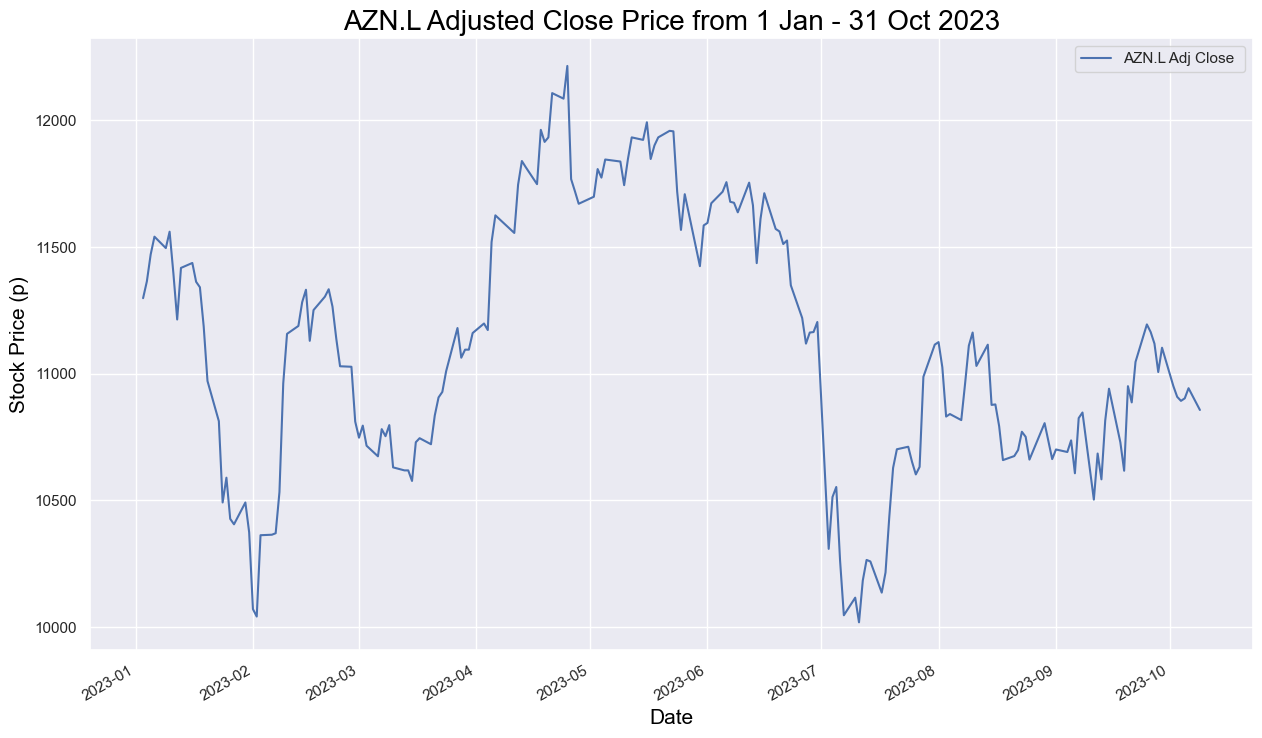

In [222]:
ticker = 'AZN.L'
title_txt = "AZN.L Adjusted Close Price from 1 Jan - 31 Oct 2023"
label_txt = "AZN.L Adj Close "

adj_12mo()

In [223]:
azn_adj_12mo = azn[['Adj Close']]['2019-01-01':'2019-12-31']

In [224]:
# Prepare the data to calculate the RSI

# Get difference in price for previous day
delta = azn_adj_12mo['Adj Close'].diff(1)
delta.head()

Date
2019-01-02          NaN
2019-01-03    93.648926
2019-01-04    69.143555
2019-01-07   -73.518555
2019-01-08   -93.650879
Name: Adj Close, dtype: float64

In [225]:
# Remove NaNs
delta = delta.dropna()
delta.head()

Date
2019-01-03    93.648926
2019-01-04    69.143555
2019-01-07   -73.518555
2019-01-08   -93.650879
2019-01-09    10.503418
Name: Adj Close, dtype: float64

In [226]:
# Get positive gains (up) and negative gains (down)
up = delta.copy()
down = delta.copy()

up[up < 0] = 0
down[down > 0] = 0

In [227]:
# Get time period

period = 14
# Calculate average gain and average loss
AVG_Gain = up.rolling(window=period).mean()
#AVG_Loss = abs(down.rolling(window=period).mean())
AVG_Loss = down.abs().rolling(window=period).mean()

In [228]:
# Calculate RSI based on SMA

# Calculate Relative Strength (RS)
RS = AVG_Gain / AVG_Loss
# Calculate RSI
RSI = 100.0 - (100.0 / (1.0 + RS))

In [229]:
def rsi():
  sns.set(rc={'figure.figsize':(20, 10)})
  plt.title(f"{title_txt}", color = 'black', fontsize = 20)
  plt.xlabel('Date', color = 'black', fontsize = 15)
  plt.ylabel('RSI', color = 'black', fontsize = 15)
  RSI.plot()


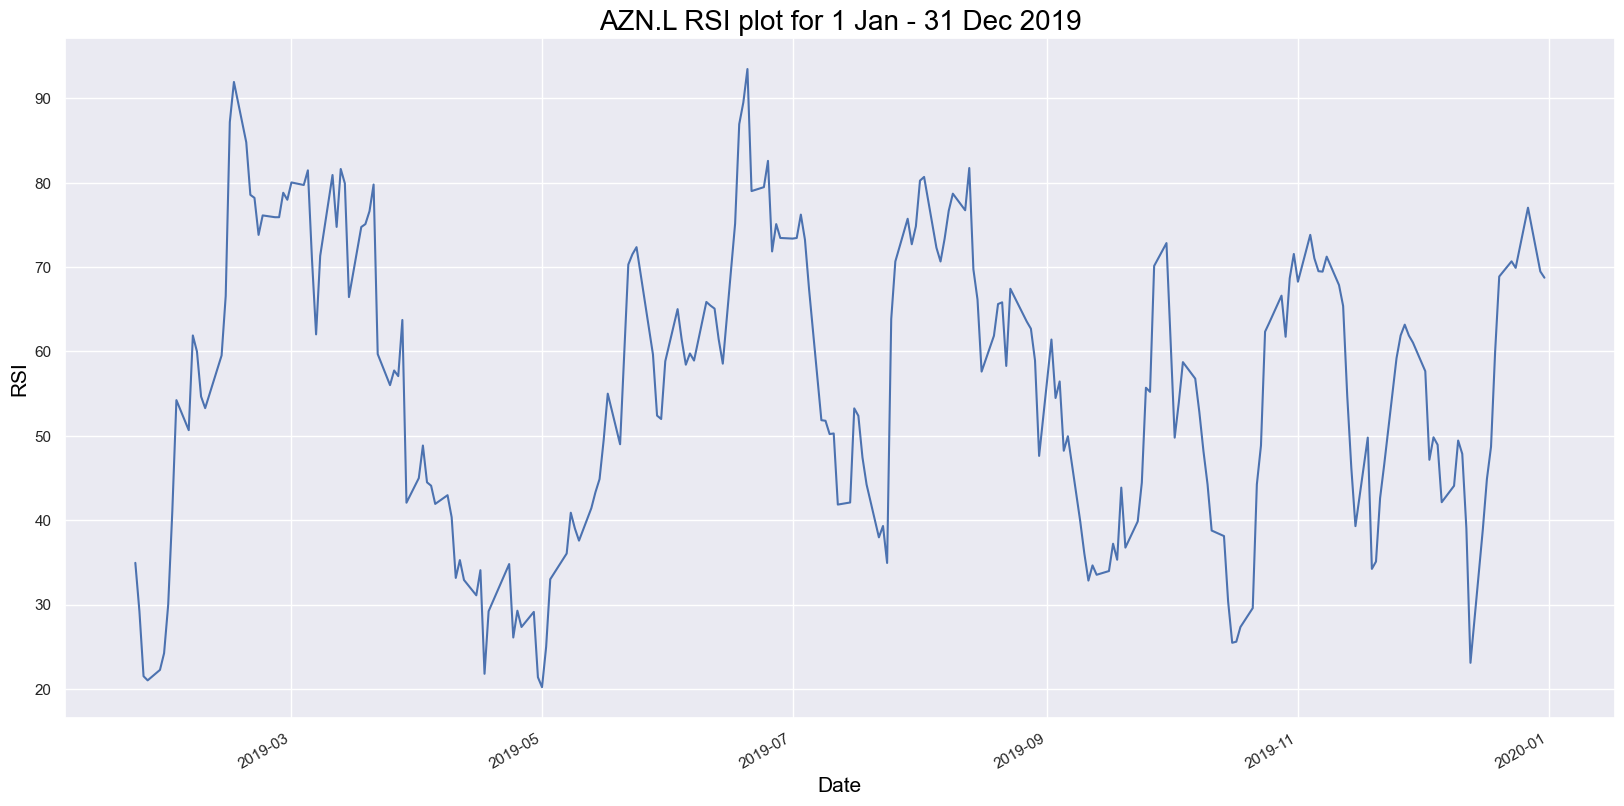

In [230]:
ticker = 'AZN.L'
title_txt = "AZN.L RSI plot for 1 Jan - 31 Dec 2019"
label_txt = "AZN.L RSI level"

rsi()

In [231]:
# Create dataframe with Adjusted Close and RSI

new_df = pd.DataFrame()
new_df['Adj Close'] = azn_adj_12mo['Adj Close']
new_df['RSI'] = RSI
new_df.head()

Adj Close  RSI
Date                        
2019-01-02  5166.502930  NaN
2019-01-03  5260.151855  NaN
2019-01-04  5329.295410  NaN
2019-01-07  5255.776855  NaN
2019-01-08  5162.125977  NaN

In [232]:
def adj_close_12mo():
  sns.set(rc={'figure.figsize':(20, 10)})
  plt.plot(new_df['Adj Close'])
  plt.title(f"{title_txt}", color = 'black', fontsize = 20)
  plt.xlabel('Date', color = 'black', fontsize = 15)
  plt.ylabel('Stock Price (p)', color = 'black', fontsize = 15)
  plt.legend(new_df.columns.values, loc = 'upper left')
  plt.show()

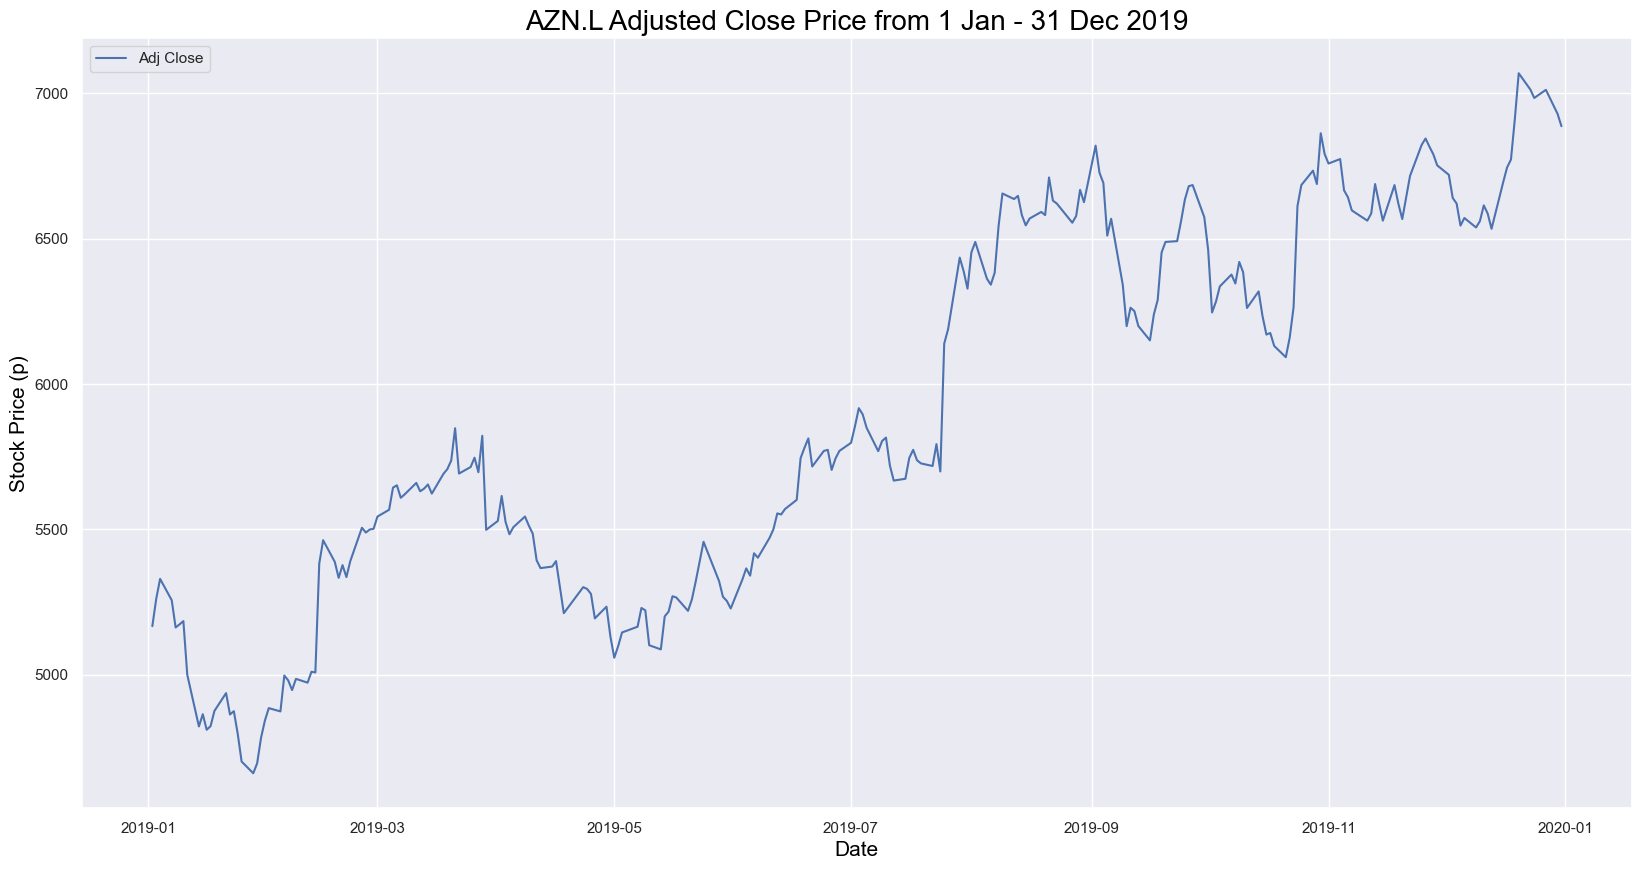

In [233]:
title_txt = "AZN.L Adjusted Close Price from 1 Jan - 31 Dec 2019"

adj_close_12mo()

In [234]:
# Plot corresponding RSI values and the significant levels

def rsi_sma():
  plt.figure(figsize=(20, 10))
  plt.title(f"{title_txt}", color = 'black', fontsize = 20)
  plt.plot(new_df['RSI'])
  plt.xlabel('Date', color = 'black', fontsize = 15)
  plt.axhline(0, linestyle='--', alpha = 0.5, color='gray')
  plt.axhline(10, linestyle='--', alpha = 0.5, color='orange')
  plt.axhline(20, linestyle='--', alpha = 0.5, color='green')
  plt.axhline(30, linestyle='--', alpha = 0.5, color='red')
  plt.axhline(70, linestyle='--', alpha = 0.5, color='red')
  plt.axhline(80, linestyle='--', alpha = 0.5, color='green')
  plt.axhline(90, linestyle='--', alpha = 0.5, color='orange')
  plt.axhline(100, linestyle='--', alpha = 0.5, color='gray')
  plt.show()

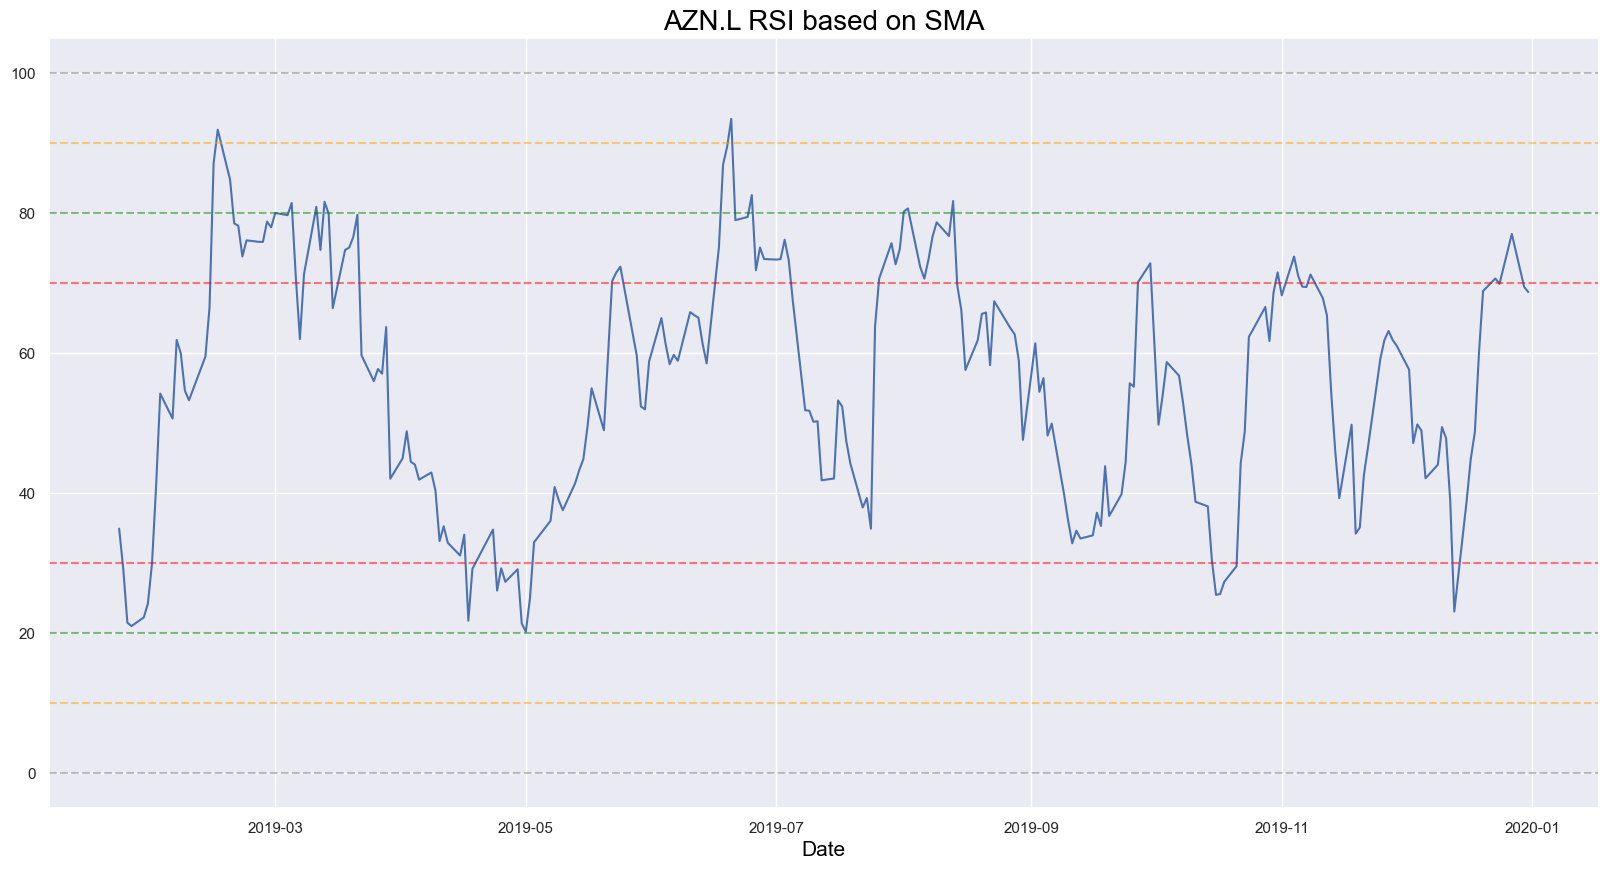

In [235]:
title_txt = 'AZN.L RSI based on SMA'

rsi_sma()

In [236]:
period = 14

# Calculate the EWMA average gain and average loss
AVG_Gain2 = up.ewm(span=period).mean()
AVG_Loss2 = down.abs().ewm(span=period).mean()

# Calculate the RSI based on EWMA
RS2 = AVG_Gain2 / AVG_Loss2
RSI2 = 100.0 - (100.0 / (1.0 + RS2))

In [237]:
new_df2 = pd.DataFrame()
new_df2['Adj Close'] = azn_adj_12mo['Adj Close']
new_df2['RSI2'] = RSI2
new_df2.head()

Adj Close        RSI2
Date                               
2019-01-02  5166.502930         NaN
2019-01-03  5260.151855  100.000000
2019-01-04  5329.295410  100.000000
2019-01-07  5255.776855   63.923244
2019-01-08  5162.125977   41.772752

In [238]:
# Plot corresponding RSI values and the significant levels

def rsi_ewma():
  plt.figure(figsize=(20, 10))
  plt.title(f"{title_txt}", color = 'black', fontsize = 20)
  plt.xlabel('Date', color = 'black', fontsize = 15)
  plt.plot(new_df2['RSI2'])
  plt.axhline(0, linestyle='--', alpha = 0.5, color='gray')
  plt.axhline(10, linestyle='--', alpha = 0.5, color='orange')
  plt.axhline(20, linestyle='--', alpha = 0.5, color='green')
  plt.axhline(30, linestyle='--', alpha = 0.5, color='red')
  plt.axhline(70, linestyle='--', alpha = 0.5, color='red')
  plt.axhline(80, linestyle='--', alpha = 0.5, color='green')
  plt.axhline(90, linestyle='--', alpha = 0.5, color='orange')
  plt.axhline(100, linestyle='--', alpha = 0.5, color='gray')
  plt.show()

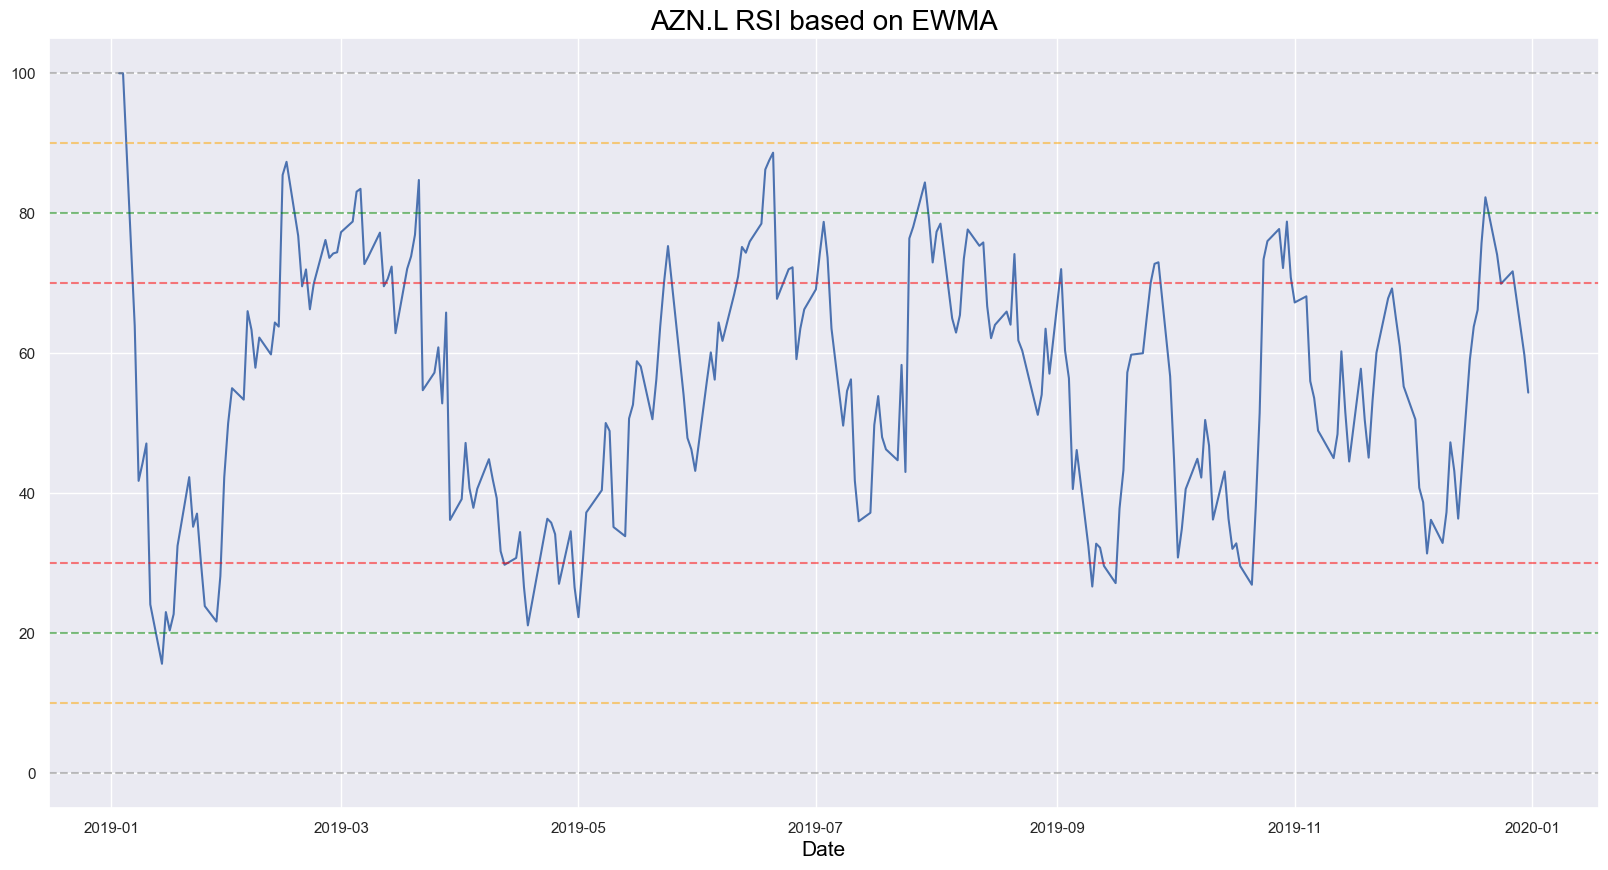

In [239]:
title_txt = 'AZN.L RSI based on EWMA'

rsi_ewma()

It appears that RSI value dips below the 20 significant level in January 2019 indicating that the stock was oversold and presented a buying opportunity for an investor before a price rise.

### 5.2.2 Money Flow Index (MFI)

Money Flow Index (MFI) is a technical oscillator, and momentum indicator, that uses price and volume data for identifying overbought or oversold signals in an asset. It can also be used to spot divergences which warn of a trend change in price. The oscillator moves between 0 and 100 and a reading of above 80 implies overbought conditions, and below 20 implies oversold conditions.

It is related to the Relative Strength Index (RSI) but incorporates volume, whereas the RSI only considers price. 

In [240]:
azn_12mo = azn.copy()

In [241]:
azn_12mo = azn_12mo['2019-01-01':'2019-12-31']
azn_12mo.head()

Open    High     Low   Close    Adj Close   Volume
Date                                                            
2019-01-02  5857.0  5925.0  5743.0  5903.0  5166.502930  1853042
2019-01-03  5877.0  6069.0  5841.0  6010.0  5260.151855  2483351
2019-01-04  6037.0  6089.0  5944.0  6089.0  5329.295410  2495405
2019-01-07  6082.0  6082.0  5982.0  6005.0  5255.776855  2582745
2019-01-08  5953.0  6002.0  5898.0  5898.0  5162.125977  2517905

In [242]:
def azn_12mo_close():
  plt.figure(figsize=(20, 10))
  plt.plot(azn_12mo['Close'])
  plt.title(f"{title_txt}", color = 'black', fontsize = 20)
  plt.xlabel('Date', color = 'black', fontsize = 15)
  plt.ylabel('Close Price', color = 'black', fontsize = 15)
  plt.legend(azn_12mo.columns.values, loc='upper left')
  plt.show()

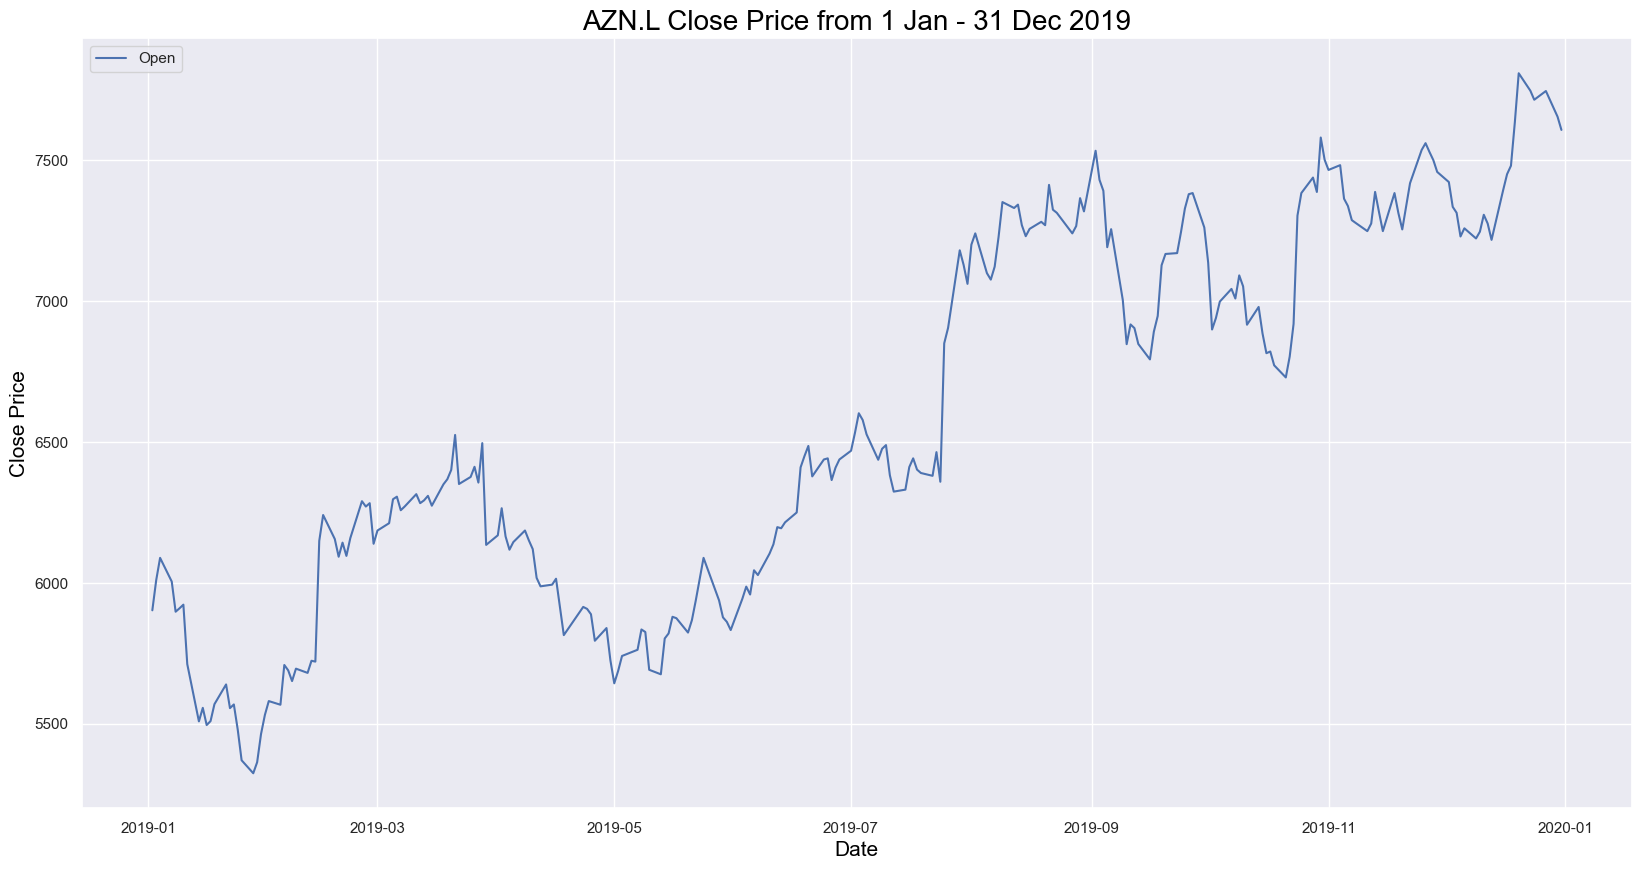

In [243]:
title_txt = "AZN.L Close Price from 1 Jan - 31 Dec 2019"
label_txt = "AZN.L Close price "

azn_12mo_close()

In [244]:
# Calculate typical price

typical_price = (azn_12mo['Close'] + azn_12mo['High'] + azn_12mo['Low']) / 3
typical_price.head()

Date
2019-01-02    5857.000000
2019-01-03    5973.333333
2019-01-04    6040.666667
2019-01-07    6023.000000
2019-01-08    5932.666667
dtype: float64

In [245]:
period = 14

In [246]:
# Calculate the money flow
money_flow = typical_price * azn_12mo['Volume']
money_flow.head()

Date
2019-01-02    1.085327e+10
2019-01-03    1.483388e+10
2019-01-04    1.507391e+10
2019-01-07    1.555587e+10
2019-01-08    1.493789e+10
dtype: float64

In [247]:
# Get all positive and negative money flows
positive_flow = []
negative_flow = []

# Loop through typical price
for i in range(1, len(typical_price)):
  if typical_price[i] > typical_price[i-1]:
    positive_flow.append(money_flow[i-1])
    negative_flow.append(0)
  elif typical_price[i] < typical_price[i-1]:
    negative_flow.append(money_flow[i-1])
    positive_flow.append(0)
  else:
    positive_flow.append(0)
    negative_flow.append(0)


In [248]:
# Get all positive and negative money flows within same time period
positive_mf = []
negative_mf = []

for i in range(period-1, len(positive_flow)):
  positive_mf.append(sum(positive_flow[i + 1 - period : i+1]))
for i in range(period-1, len(negative_flow)):
  negative_mf.append(sum(negative_flow[i + 1 - period : i+1]))

In [249]:
# Calculate money flow index

mfi = 100 * (np.array(positive_mf) / (np.array(positive_mf) + np.array(negative_mf)))
mfi

array([ 26.37467955,  21.41631055,  14.51702253,  14.64302295,
        14.58894654,  21.06155893,  28.17267769,  34.34357251,
        42.62831561,  49.88786195,  56.48391789,  65.93222358,
        64.64447934,  63.25198992,  62.90755798,  68.8602678 ,
        70.33813853,  78.7057625 ,  88.89675931,  78.87692811,
        70.013088  ,  70.48533183,  63.0240827 ,  63.60162237,
        64.30472549,  57.51275967,  59.51080727,  53.79388493,
        59.39279264,  60.07097511,  65.27774282,  64.17936964,
        55.88252779,  64.66969393,  72.8743432 ,  66.54098956,
        73.94815217,  73.66772136,  63.59590448,  76.83861581,
        75.797566  ,  81.65465317,  81.00103633,  75.38032973,
        69.78958094,  69.39863742,  69.40714205,  69.26607088,
        63.90615752,  74.5348123 ,  64.63460361,  66.11186364,
        59.29370733,  46.96011756,  48.02266654,  44.23402543,
        40.26333432,  40.42546404,  39.85010657,  35.94662043,
        39.89780078,  36.17052933,  35.45327626,  24.00

In [250]:
df2 = pd.DataFrame()
df2['MFI'] = mfi

In [251]:
# Create the plot

def mfi_plot():
  plt.figure(figsize=(20, 10))
  plt.plot(df2['MFI'], label = 'MFI')
  plt.axhline(10, linestyle = '--', color = 'orange')
  plt.axhline(20, linestyle = '--', color = 'blue')
  plt.axhline(80, linestyle = '--', color = 'blue')
  plt.axhline(90, linestyle = '--', color = 'orange')
  plt.title(f"{title_txt}", color = 'black', fontsize = 20)
  plt.xlabel('Time periods', color = 'black', fontsize = 15)
  plt.ylabel('MFI Values', color = 'black', fontsize = 15)
  plt.show()

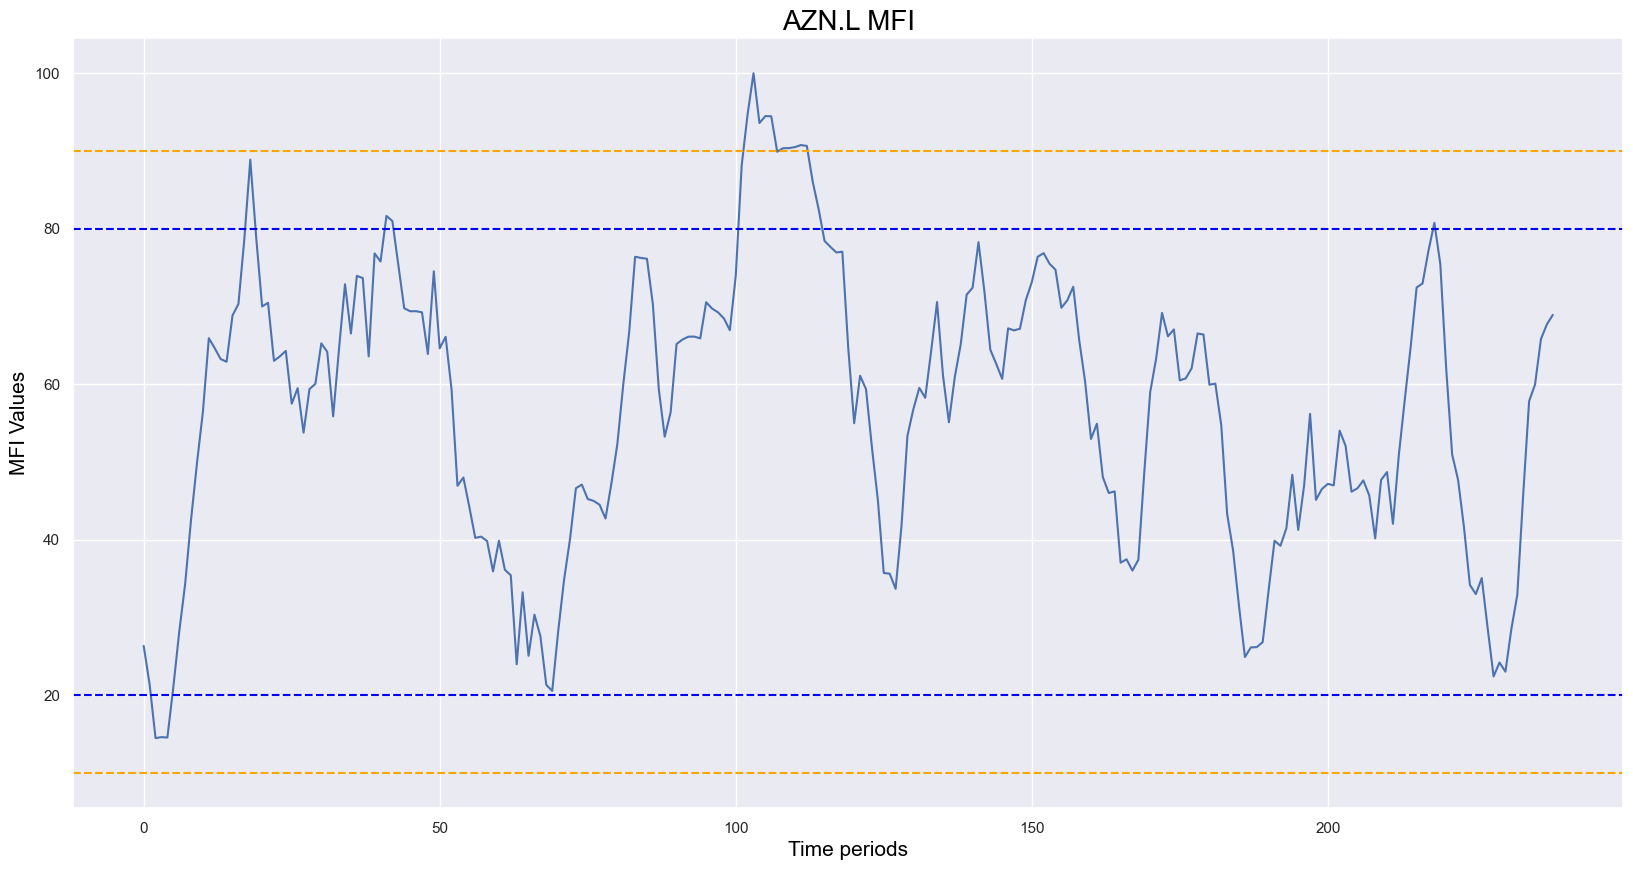

In [252]:
title_txt = "AZN.L MFI"

mfi_plot()

In [253]:
new_mfi_df = pd.DataFrame()
new_mfi_df = azn_12mo[period:]
new_mfi_df['MFI'] = mfi

In [254]:
new_mfi_df.head()

Open    High     Low   Close    Adj Close   Volume        MFI
Date                                                                       
2019-01-22  5636.0  5659.0  5533.0  5556.0  4862.796387  1931509  26.374680
2019-01-23  5551.0  5619.0  5508.0  5569.0  4874.174805  2964969  21.416311
2019-01-24  5565.0  5579.0  5470.0  5480.0  4796.278809  2392031  14.517023
2019-01-25  5432.0  5490.0  5357.0  5371.0  4700.877930  3027190  14.643023
2019-01-28  5350.0  5391.0  5312.0  5325.0  4660.617676  2616543  14.588947

In [255]:
# Create function to get buy and sell signals

def get_signal(data, high, low):
  buy_signal = []
  sell_signal = []

  for i in range(len(data['MFI'])):
    if data['MFI'][i] > high:
      buy_signal.append(np.nan)
      sell_signal.append(data['Close'][i])
    elif data['MFI'][i] < low:
      buy_signal.append(data['Close'][i])
      sell_signal.append(np.nan)
    else:
      sell_signal.append(np.nan)
      buy_signal.append(np.nan)

  return (buy_signal, sell_signal)


In [256]:
# Add new columns (Buy & Sell)

new_mfi_df['Buy'] = get_signal(new_mfi_df, 80, 20)[0]
new_mfi_df['Sell'] = get_signal(new_mfi_df, 80, 20)[1]

new_mfi_df.head()

Open    High     Low   Close    Adj Close   Volume        MFI  \
Date                                                                          
2019-01-22  5636.0  5659.0  5533.0  5556.0  4862.796387  1931509  26.374680   
2019-01-23  5551.0  5619.0  5508.0  5569.0  4874.174805  2964969  21.416311   
2019-01-24  5565.0  5579.0  5470.0  5480.0  4796.278809  2392031  14.517023   
2019-01-25  5432.0  5490.0  5357.0  5371.0  4700.877930  3027190  14.643023   
2019-01-28  5350.0  5391.0  5312.0  5325.0  4660.617676  2616543  14.588947   

               Buy  Sell  
Date                      
2019-01-22     NaN   NaN  
2019-01-23     NaN   NaN  
2019-01-24  5480.0   NaN  
2019-01-25  5371.0   NaN  
2019-01-28  5325.0   NaN

In [257]:
def mfi_buy_sell_plot():
  plt.figure(figsize=(20, 10))
  plt.plot(new_mfi_df['Close'], label = 'Close Price', alpha = 0.5)
  plt.scatter(new_mfi_df.index, new_mfi_df['Buy'], color = 'green', label = 'Buy Signal', marker = '^', alpha = 1)
  plt.scatter(new_mfi_df.index, new_mfi_df['Sell'], color = 'red', label = 'Sell Signal', marker = 'v', alpha = 1)
  plt.title(f"{title_txt}", color = 'black', fontsize = 20)
  plt.xlabel('Date', color = 'black', fontsize = 15)
  plt.ylabel('Close Price', color = 'black', fontsize = 15)
  plt.legend(loc='upper left')
  plt.show()

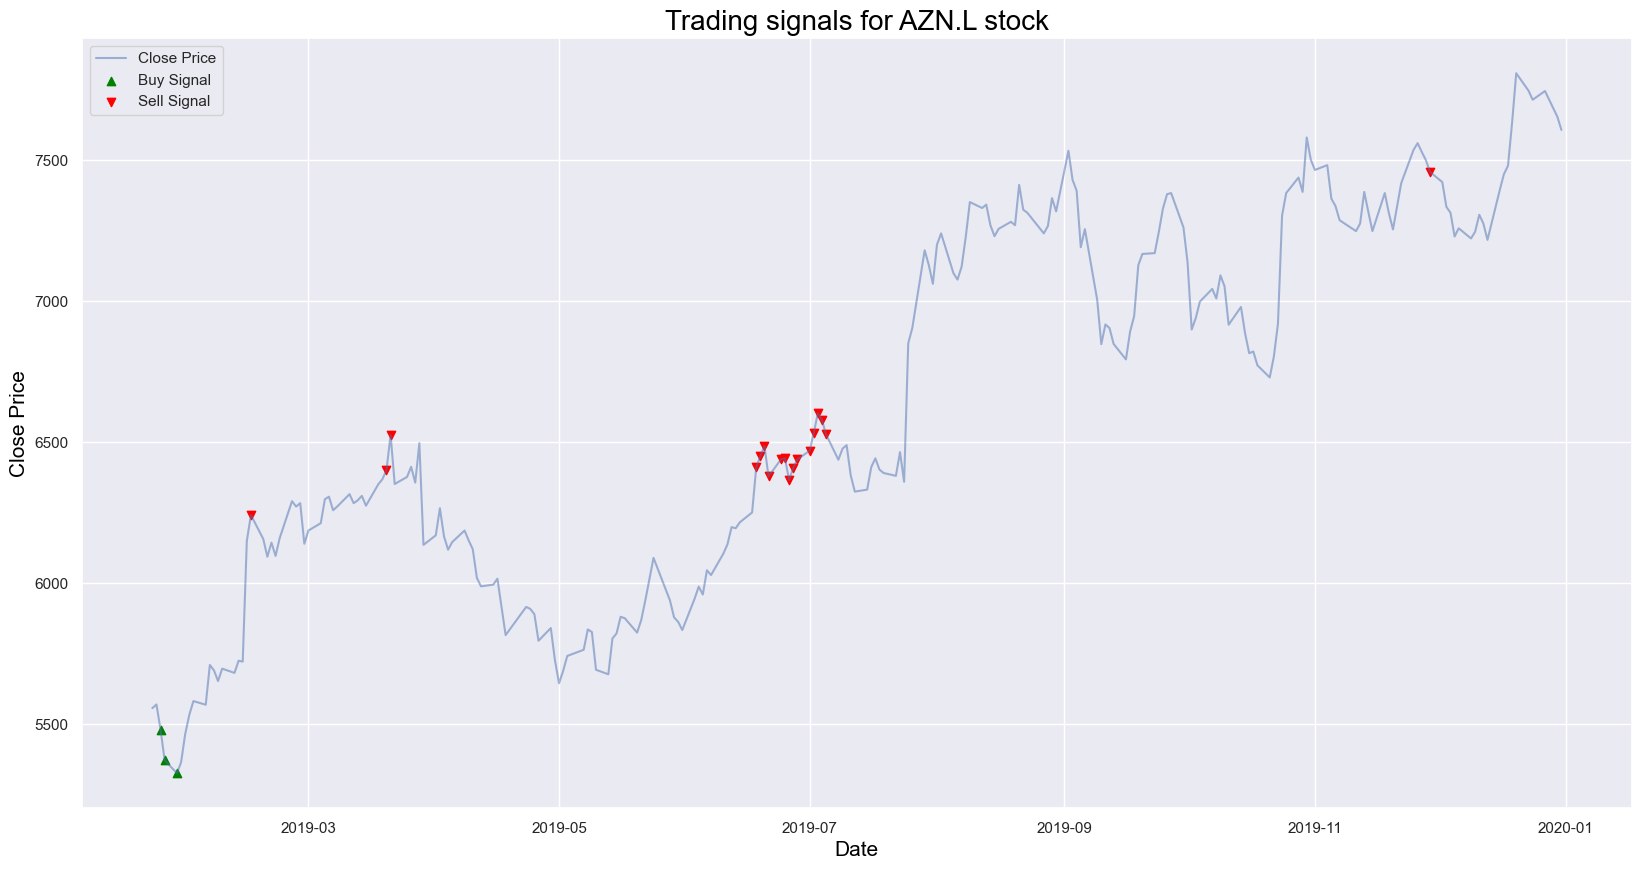

In [258]:
title_txt = "Trading signals for AZN.L stock"
mfi_buy_sell_plot()

### 5.2.3 Stochastic Oscillator

The stochastic oscillator is a momentum indicator comparing the closing price of a security to the range of its prices over a certain period of time and is one of the best-known momentum indicators along with RSI and MACD.

The intuition is that in a market trending upward, prices will close near the high, and in a market trending downward, prices close near the low.

The stochastic oscillator is plotted within a range of zero and 100. The default parameters are an overbought zone of 80, an oversold zone of 20 and well-used lookbacks period of 14 and 5 which can be used simultaneously. The oscillator has two lines, the %K and %D, where the former measures momentum and the latter measures the moving average of the former. The %D line is more important of the two indicators and tends to produce better trading signals which are created when the %K crosses through the %D.

In [259]:
azn_so = azn.copy()
azn_so.head()

Open         High          Low   Close    Adj Close   Volume
Date                                                                      
2013-01-02  2930.0  2969.297119  2923.000000  2969.0  1974.841675  2394731
2013-01-03  2969.5  2982.500000  2952.500000  2980.0  1982.158203  1763172
2013-01-04  2992.5  3005.000000  2975.211914  3000.0  1995.461304  2041101
2013-01-07  2998.5  3004.989990  2976.000000  2985.0  1985.483765  1185261
2013-01-08  2986.5  3005.500000  2958.500000  3000.0  1995.461304  2723178

The stochastic oscillator is calculated using the following formula:

%K = 100(C – L14)/(H14 – L14)

Where:

C = the most recent closing price

L14 = the low of the 14 previous trading sessions

H14 = the highest price traded during the same 14-day period

%K= the current market rate for the currency pair

%D = 3-period moving average of %K

In [260]:
# In this implementation there are 3 possible states – long, short, flat (i.e. no position).

#Create the "L14" column in the DataFrame
azn_so['L14'] = azn_so['Low'].rolling(window=14).min()

#Create the "H14" column in the DataFrame
azn_so['H14'] = azn_so['High'].rolling(window=14).max()

#Create the "%K" column in the DataFrame
azn_so['%K'] = 100*((azn_so['Close'] - azn_so['L14']) / (azn_so['H14'] - azn_so['L14']) )

#Create the "%D" column in the DataFrame
azn_so['%D'] = azn_so['%K'].rolling(window=3).mean()

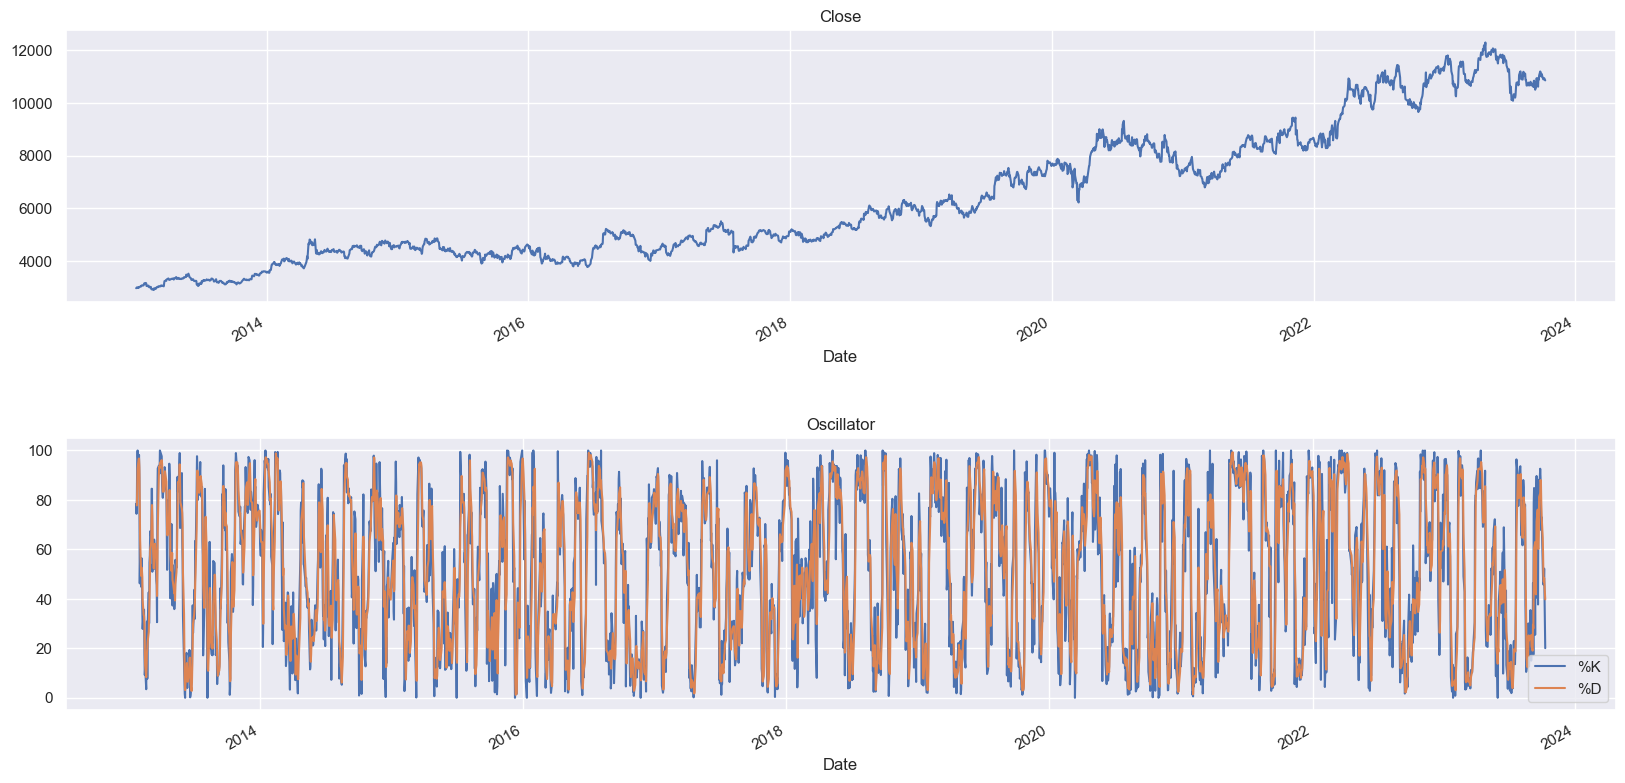

In [261]:
#create a plot (with 2 subplots) showing the AZN.L price over time, along with a visual representation of the Stochastic Oscillator.

fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(20,10))
fig.subplots_adjust(hspace=0.5)

azn_so['Close'].plot(ax=axes[0]); axes[0].set_title('Close')
azn_so[['%K','%D']].plot(ax=axes[1]); axes[1].set_title('Oscillator');

In [262]:
#Create a column in the DataFrame showing "TRUE" if sell entry signal is given and "FALSE" otherwise. 
#A sell is initiated when the %K line crosses down through the %D line and the value of the oscillator is above 80 
azn_so['Sell Entry'] = ((azn_so['%K'] < azn_so['%D']) & (azn_so['%K'].shift(1) > azn_so['%D'].shift(1))) & (azn_so['%D'] > 80) 

#Create a column in the DataFrame showing "TRUE" if sell exit signal is given and "FALSE" otherwise. 
#A sell exit signal is given when the %K line crosses back up through the %D line 
azn_so['Sell Exit'] = ((azn_so['%K'] > azn_so['%D']) & (azn_so['%K'].shift(1) < azn_so['%D'].shift(1))) 

#create a placeholder column to populate with short positions (-1 for short and 0 for flat) using boolean values created above 
azn_so['Short'] = np.nan 
azn_so.loc[azn_so['Sell Entry'],'Short'] = -1 
azn_so.loc[azn_so['Sell Exit'],'Short'] = 0 

#Set initial position on day 1 to flat 
azn_so['Short'][0] = 0 

#Forward fill the position column to represent the holding of positions through time 
azn_so['Short'] = azn_so['Short'].fillna(method='pad') 

#Create a column in the DataFrame showing "TRUE" if buy entry signal is given and "FALSE" otherwise. 
#A buy is initiated when the %K line crosses up through the %D line and the value of the oscillator is below 20 
azn_so['Buy Entry'] = ((azn_so['%K'] > azn_so['%D']) & (azn_so['%K'].shift(1) < azn_so['%D'].shift(1))) & (azn_so['%D'] < 20) 

#Create a column in the DataFrame showing "TRUE" if buy exit signal is given and "FALSE" otherwise. 
#A buy exit signal is given when the %K line crosses back down through the %D line 
azn_so['Buy Exit'] = ((azn_so['%K'] < azn_so['%D']) & (azn_so['%K'].shift(1) > azn_so['%D'].shift(1))) 

#create a placeholder column to populate with long positions (1 for long and 0 for flat) using boolean values created above 
azn_so['Long'] = np.nan  
azn_so.loc[azn_so['Buy Entry'],'Long'] = 1  
azn_so.loc[azn_so['Buy Exit'],'Long'] = 0  

#Set initial position on day 1 to flat 
azn_so['Long'][0] = 0  

#Forward fill the position column to represent the holding of positions through time 
azn_so['Long'] = azn_so['Long'].fillna(method='pad') 

#Add Long and Short positions together to get final strategy position (1 for long, -1 for short and 0 for flat) 
azn_so['Position'] = azn_so['Long'] + azn_so['Short']

<Axes: xlabel='Date'>

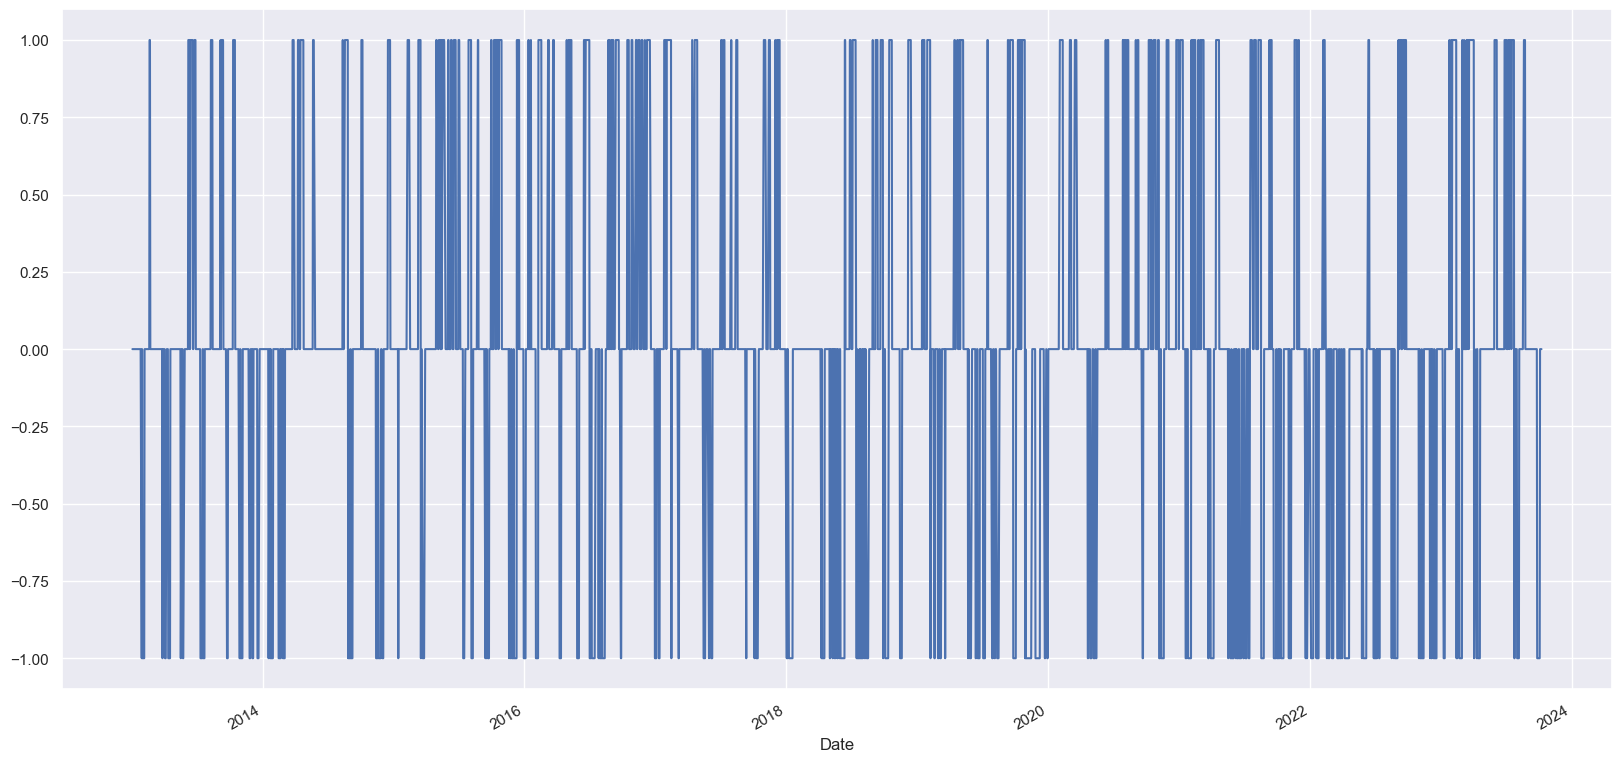

In [263]:
# plot the position through time to get an idea of when we are long and when we are short
azn_so['Position'].plot(figsize=(20,10))

Text(0.5, 1.0, 'Strategy returns versus AZN.L returns')

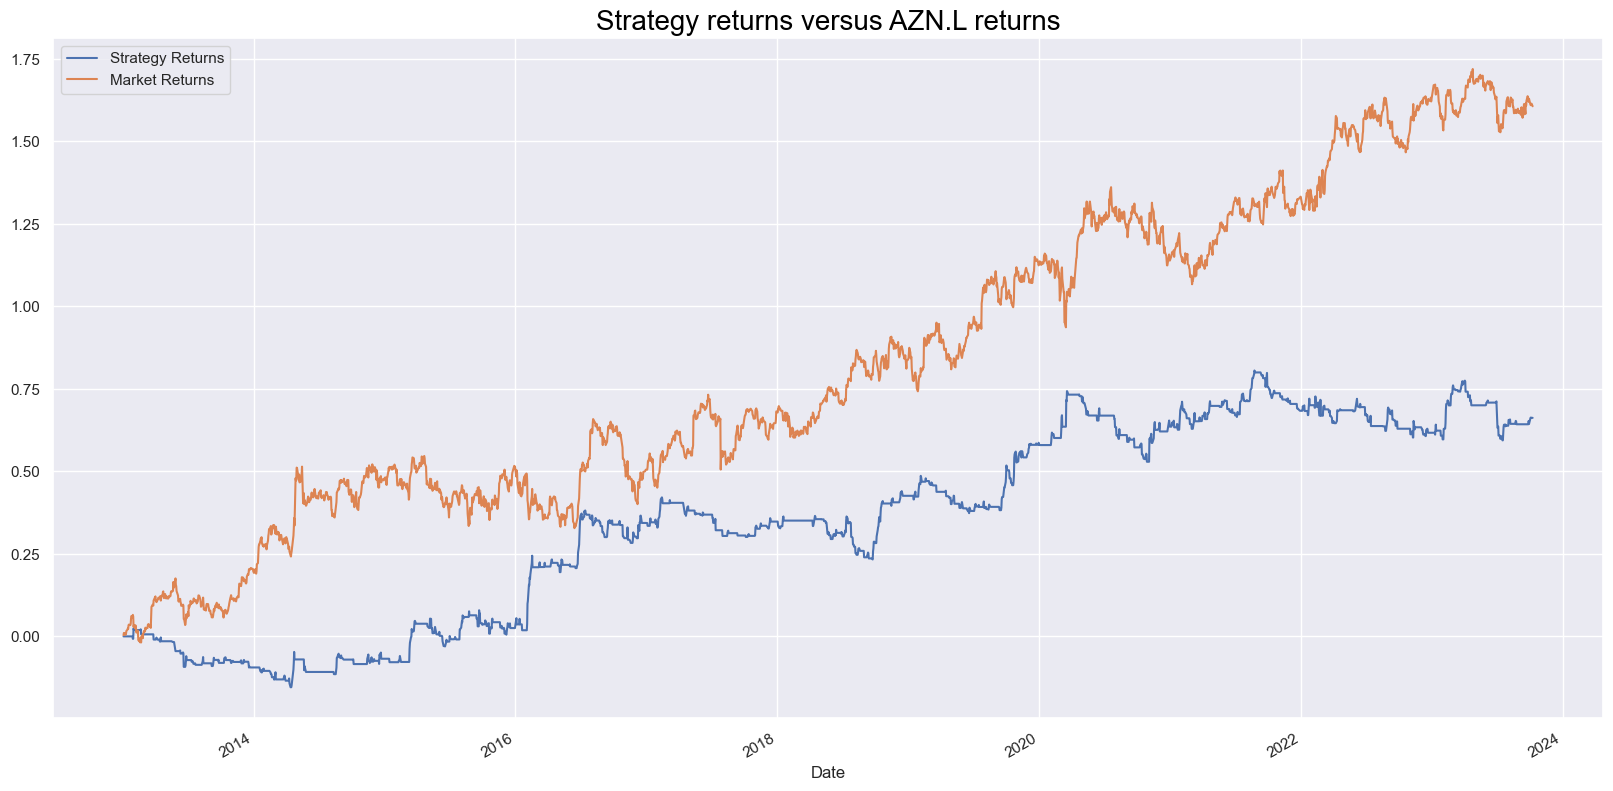

In [264]:
#Set up a column holding the daily AZN.L returns
azn_so['Market Returns'] = azn_so['Close'].pct_change()

#Create column for Strategy Returns by multiplying the daily AZN.L returns by the position that was held at close
#of business the previous day
azn_so['Strategy Returns'] = azn_so['Market Returns'] * azn_so['Position'].shift(1)

#Finally plot the strategy returns versus AZN.L returns
azn_so[['Strategy Returns','Market Returns']].cumsum().plot(figsize=(20,10))

plt.title('Strategy returns versus AZN.L returns', color = 'black', fontsize = 20)

The returns are positive at least, but we could have done much better by just buying and holding AZN.L stock, which is slightly disappointing.

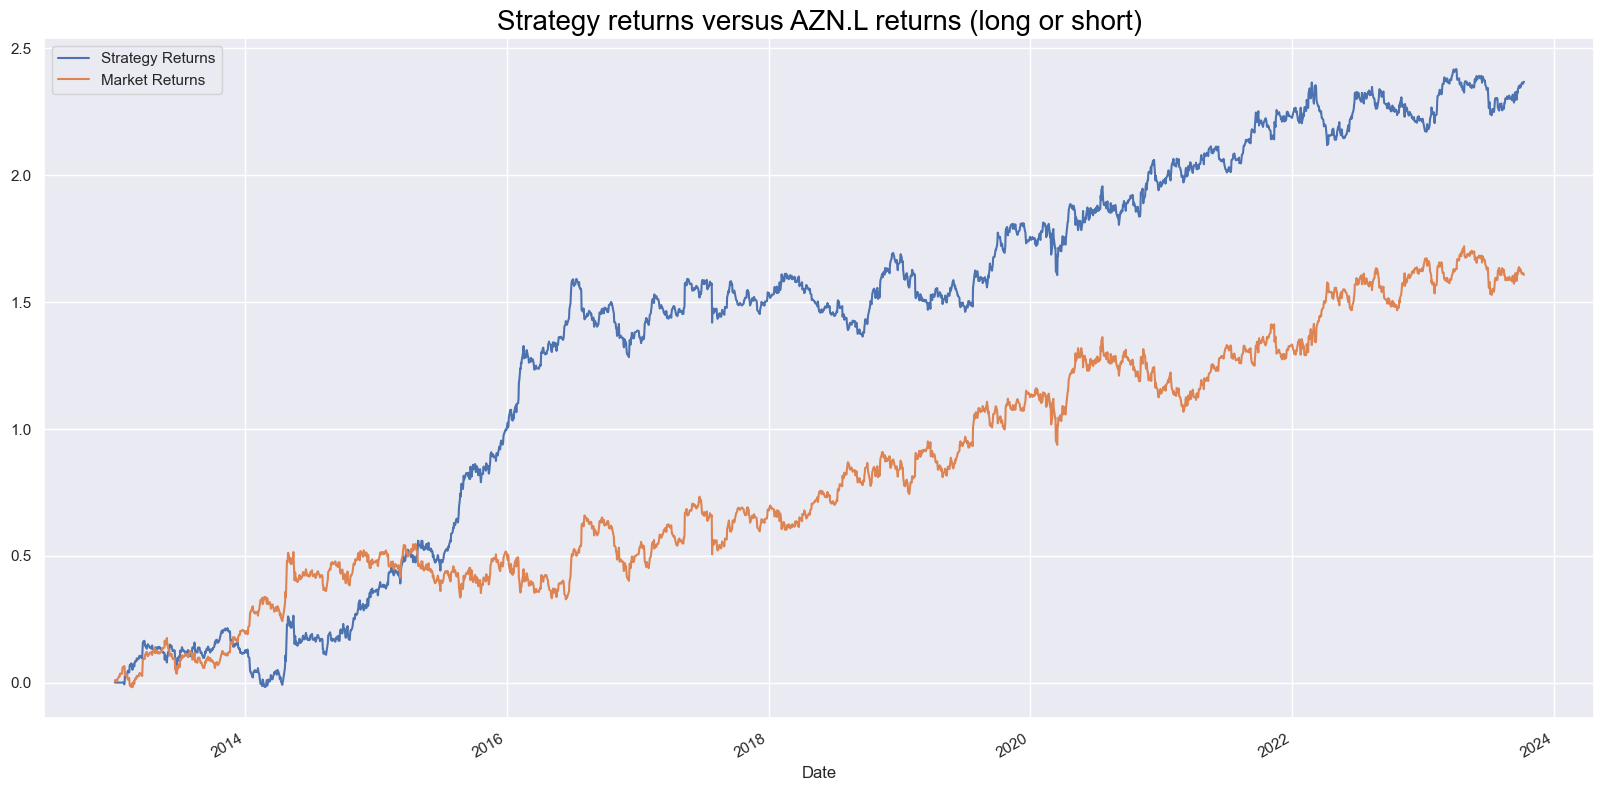

In [265]:
# second implementation of the strategy – the one where we are either long or short

azn_so['L14'] = azn_so['Low'].rolling(window=14).min()
azn_so['H14'] = azn_so['High'].rolling(window=14).max()

azn_so['%K'] = 100*((azn_so['Close'] - azn_so['L14']) / (azn_so['H14'] - azn_so['L14']) )
azn_so['%D'] = azn_so['%K'].rolling(window=3).mean()

azn_so['Sell Entry'] = ((azn_so['%K'] < azn_so['%D']) & (azn_so['%K'].shift(1) > azn_so['%D'].shift(1))) & (azn_so['%D'] > 80)
azn_so['Buy Entry'] = ((azn_so['%K'] > azn_so['%D']) & (azn_so['%K'].shift(1) < azn_so['%D'].shift(1))) & (azn_so['%D'] < 20)

#Create empty "Position" column
azn_so['Position'] = np.nan 

#Set position to -1 for sell signals
azn_so.loc[azn_so['Sell Entry'],'Position'] = -1 

#Set position to -1 for buy signals
azn_so.loc[azn_so['Buy Entry'],'Position'] = 1 

#Set starting position to flat (i.e. 0)
azn_so['Position'].iloc[0] = 0 

#Forward fill the position column to show holding of positions through time
azn_so['Position'] = azn_so['Position'].fillna(method='ffill')

#Set up a column holding the daily AZN.L returns
azn_so['Market Returns'] = azn_so['Close'].pct_change()

#Create column for Strategy Returns by multiplying the daily AZN.L returns by the position that was held at close
#of business the previous day
azn_so['Strategy Returns'] = azn_so['Market Returns'] * azn_so['Position'].shift(1)

#Finally plot the strategy returns versus AZN.L returns
azn_so[['Strategy Returns','Market Returns']].cumsum().plot(figsize=(20,10));

plt.title('Strategy returns versus AZN.L returns (long or short)', color = 'black', fontsize = 20);

This implementation gives a much better outcome for the second half of the back-tested period from 2015-2019.

### 5.2.4  Rate of Change (ROC) 

The ROC indicator is a pure momentum oscillator. The ROC calculation compares the current price with the price "n" periods ago e.g. when we compute the ROC of the daily price with a 9-day lag, we are simply looking at how much, in percentage, the price has gone up (or down) compared to 9 days ago. Like other momentum indicators, ROC has overbought and oversold zones that may be adjusted according to market conditions. 

In [266]:
azn_roc = azn.copy()
azn_roc.head()

Open         High          Low   Close    Adj Close   Volume
Date                                                                      
2013-01-02  2930.0  2969.297119  2923.000000  2969.0  1974.841675  2394731
2013-01-03  2969.5  2982.500000  2952.500000  2980.0  1982.158203  1763172
2013-01-04  2992.5  3005.000000  2975.211914  3000.0  1995.461304  2041101
2013-01-07  2998.5  3004.989990  2976.000000  2985.0  1985.483765  1185261
2013-01-08  2986.5  3005.500000  2958.500000  3000.0  1995.461304  2723178

In [267]:
azn_roc_12mo = azn_roc['2019-01-01':'2019-12-31']
azn_roc_12mo.head()

Open    High     Low   Close    Adj Close   Volume
Date                                                            
2019-01-02  5857.0  5925.0  5743.0  5903.0  5166.502930  1853042
2019-01-03  5877.0  6069.0  5841.0  6010.0  5260.151855  2483351
2019-01-04  6037.0  6089.0  5944.0  6089.0  5329.295410  2495405
2019-01-07  6082.0  6082.0  5982.0  6005.0  5255.776855  2582745
2019-01-08  5953.0  6002.0  5898.0  5898.0  5162.125977  2517905

In [268]:
azn_roc_12mo['ROC'] = ( azn_roc_12mo['Adj Close'] / azn_roc_12mo['Adj Close'].shift(9) -1 ) * 100
azn_roc_12mo[['Adj Close', 'ROC']].tail()

Adj Close       ROC
Date                             
2019-12-23  7012.543945  6.900350
2019-12-24  6983.573730  5.584460
2019-12-27  7011.637695  6.460468
2019-12-30  6929.255371  6.055138
2019-12-31  6886.705566  2.880709

In [269]:
# selection of data - last 100 days

azn_roc_100d = azn_roc_12mo[-100:]
dates = azn_roc_100d.index
price = azn_roc_100d['Adj Close']
roc = azn_roc_100d['ROC']

In [270]:
price

Date
2019-08-09    6654.945801
2019-08-12    6635.934570
2019-08-13    6646.798340
2019-08-14    6580.710449
2019-08-15    6545.402344
                 ...     
2019-12-23    7012.543945
2019-12-24    6983.573730
2019-12-27    7011.637695
2019-12-30    6929.255371
2019-12-31    6886.705566
Name: Adj Close, Length: 100, dtype: float64

ValueError: keyword grid_b is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'labelfontfamily', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

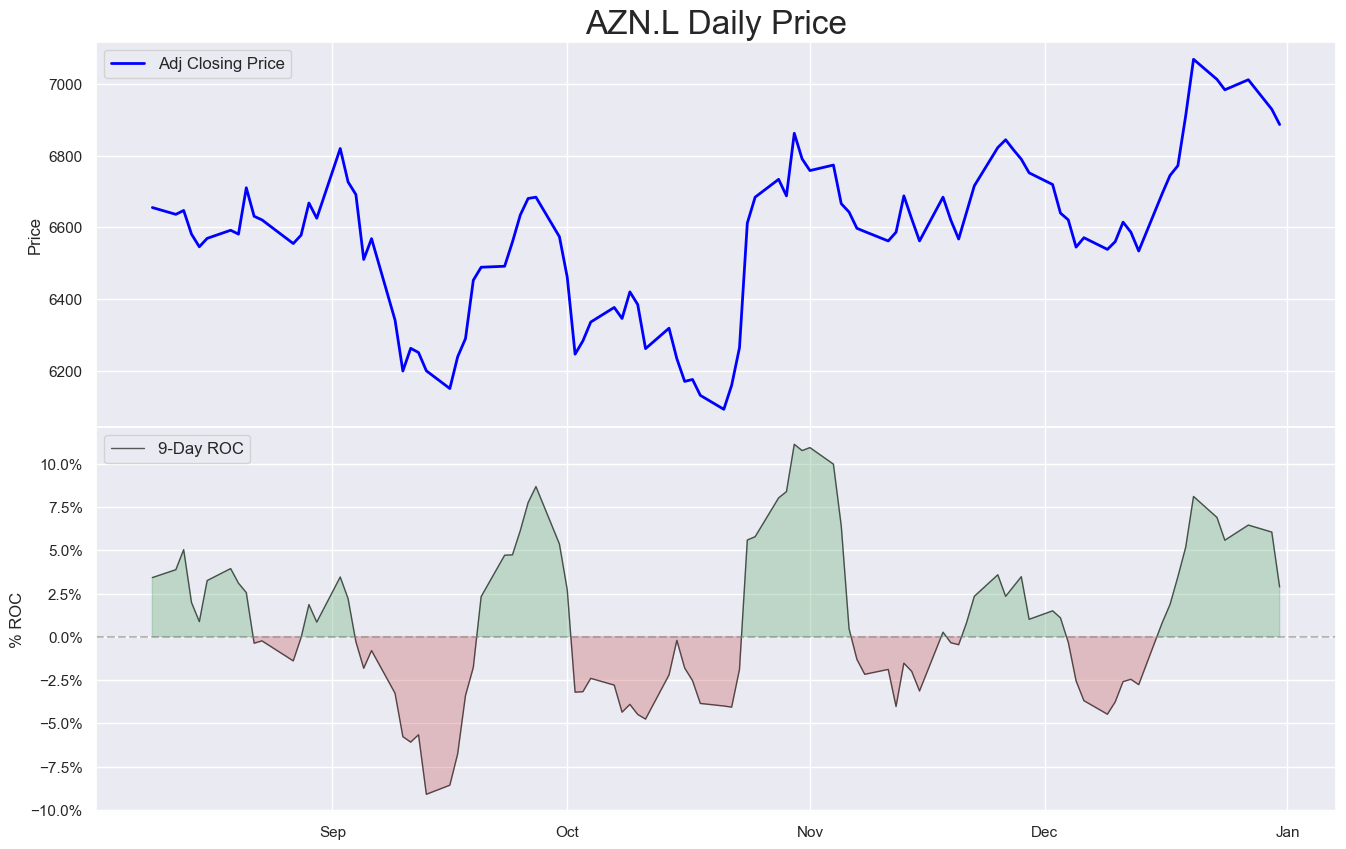

In [271]:
# Plot AZN.L Adj Close Price and 9-day ROC for last 100 days of 2019

fig = plt.figure(figsize=(16,10))
fig.subplots_adjust(hspace=0)

plt.rcParams.update({'font.size': 14})

# Price subplot
price_ax = plt.subplot(2, 1, 1)
price_ax.plot(price, color='blue', linewidth=2, label="Adj Closing Price")
price_ax.legend(loc="upper left", fontsize=12)
price_ax.set_ylabel("Price")
price_ax.set_title("AZN.L Daily Price", fontsize=24)

# ROC subplot
roc_ax = plt.subplot(2, 1, 2, sharex = price_ax)
roc_ax.plot(roc, color='k', linewidth = 1, alpha=0.7, label="9-Day ROC")
roc_ax.legend(loc="upper left", fontsize=12)
roc_ax.set_ylabel("% ROC")

# Adding a horizontal line at the zero level in the ROC subplot:
roc_ax.axhline(0, color = (.5, .5, .5), linestyle = '--', alpha = 0.5)

# Filling the areas between the indicator and the level 0 line:
roc_ax.fill_between(dates, 0, roc, where = (roc >= 0), color='g', alpha=0.3, interpolate=True)
roc_ax.fill_between(dates, 0, roc, where = (roc  < 0), color='r', alpha=0.3, interpolate=True)

# Formatting the date labels
roc_ax.xaxis.set_major_formatter(DateFormatter('%b'))

# Formatting the labels on the y axis for ROC:
roc_ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())

# Adding a grid to both subplots:
price_ax.grid(b=True, linestyle='--', alpha=0.5)
roc_ax.grid(b=True, linestyle='--', alpha=0.5)

# Setting a background color for the both subplots:
price_ax.set_facecolor((.94,.95,.98))
roc_ax.set_facecolor((.98,.97,.93))

# Adding margins around the plots:
price_ax.margins(0.05, 0.2)
roc_ax.margins(0.05, 0.2)

# Hiding the tick marks from the horizontal and vertical axis:
price_ax.tick_params(left=False, bottom=False)
roc_ax.tick_params(left=False, bottom=False, labelrotation=45)

# Hiding all the spines for the price subplot:
for s in price_ax.spines.values():
    s.set_visible(False)
# Hiding all the spines for the ROC subplot:
for s in roc_ax.spines.values():
    s.set_visible(False)

# To better separate the two subplots, we reinstate a spine in between them
roc_ax.spines['top'].set_visible(True)
roc_ax.spines['top'].set_linewidth(1.5)

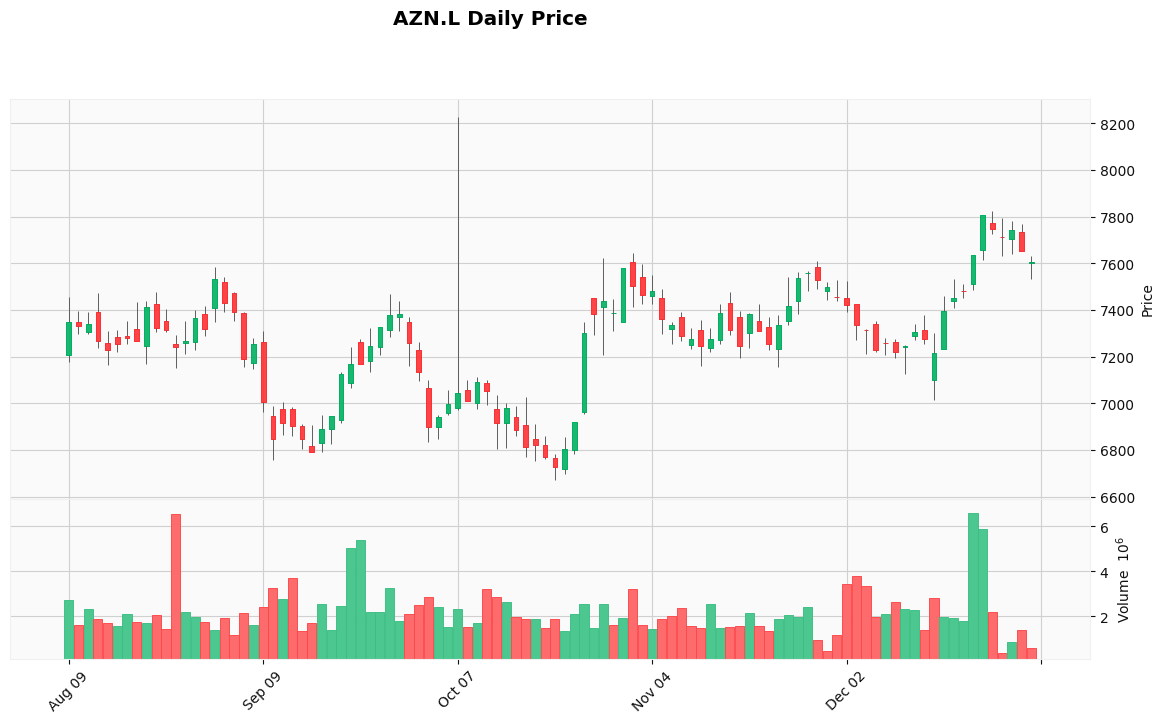

In [ ]:
# Candlestick and volume plot for same time frame

mpf.plot(azn_roc_100d, type='candle',  style='yahoo', figsize=(15,8),  title="AZN.L Daily Price", volume=True)


In [272]:
"""
# Combined Candlestick, ROC and Volume plot

# We create an additional plot planing it on the third panel
roc_plot = mpf.make_addplot(roc, panel=2, ylabel='ROC')
print(roc_plot['data'], type(roc_plot))
print(azn_roc_100d)
#We pass the additional plot using the addplot parameter
mpf.plot(azn_roc_100d, type='candle',  style='yahoo', figsize=(15,8), addplot=roc_plot, title="AZN.L Daily Price", volume=True)
"""

'\n# Combined Candlestick, ROC and Volume plot\n\n# We create an additional plot planing it on the third panel\nroc_plot = mpf.make_addplot(roc, panel=2, ylabel=\'ROC\')\nprint(roc_plot[\'data\'], type(roc_plot))\nprint(azn_roc_100d)\n#We pass the additional plot using the addplot parameter\nmpf.plot(azn_roc_100d, type=\'candle\',  style=\'yahoo\', figsize=(15,8), addplot=roc_plot, title="AZN.L Daily Price", volume=True)\n'

## 5.3 Volatility trading strategies

Volatility trading involves predicting the stability of an asset’s value. Instead of trading on the price rising or falling, traders take a position on whether it will move in any direction.

### 5.3.1 Bollinger Bands

A Bollinger Band is a volatility indicator based on based on the correlation between the normal distribution and stock price and can be used to draw support and resistance curves. It is defined by a set of lines plotted two standard deviations (positively and negatively) away from a simple moving average (SMA) of the security's price, but can be adjusted to user preferences.

By default it calculates a 20-period SMA (the middle band), an upper band two standard deviations above the the moving average and a lower band two standard deviations below it.

If the price moves above the upper band this could indicate a good time to sell, and if it moves below the lower band it could be a good time to buy. 

Whereas the RSI can only be used as a confirming factor inside a ranging market, not a trending market, by using Bollinger bands we can calculate the widening variable, or moving spread between the upper and the lower bands, that tells us if prices are about to trend and whether the RSI signals might not be that reliable.

Despite 90% of the price action happening between the bands, however, a breakout is not necessarily a trading signal as it provides no clue as to the direction and extent of future price movement.

In [273]:
azn_12mo.head()

Open    High     Low   Close    Adj Close   Volume
Date                                                            
2019-01-02  5857.0  5925.0  5743.0  5903.0  5166.502930  1853042
2019-01-03  5877.0  6069.0  5841.0  6010.0  5260.151855  2483351
2019-01-04  6037.0  6089.0  5944.0  6089.0  5329.295410  2495405
2019-01-07  6082.0  6082.0  5982.0  6005.0  5255.776855  2582745
2019-01-08  5953.0  6002.0  5898.0  5898.0  5162.125977  2517905

In [274]:
azn_12mo_bb = azn_12mo.copy()

In [275]:
azn_12mo_bb.head()

Open    High     Low   Close    Adj Close   Volume
Date                                                            
2019-01-02  5857.0  5925.0  5743.0  5903.0  5166.502930  1853042
2019-01-03  5877.0  6069.0  5841.0  6010.0  5260.151855  2483351
2019-01-04  6037.0  6089.0  5944.0  6089.0  5329.295410  2495405
2019-01-07  6082.0  6082.0  5982.0  6005.0  5255.776855  2582745
2019-01-08  5953.0  6002.0  5898.0  5898.0  5162.125977  2517905

In [276]:
#Get the time period (20 days)
period = 20
# Calculate the 20 Day Simple Moving Average, Std Deviation, Upper Band and Lower Band
#Calculating the Simple Moving Average
azn_12mo_bb['SMA'] = azn_12mo_bb['Close'].rolling(window=period).mean()
# Get the standard deviation
azn_12mo_bb['STD'] = azn_12mo_bb['Close'].rolling(window=period).std()
#Calculate the Upper Bollinger Band
azn_12mo_bb['Upper'] = azn_12mo_bb['SMA'] + (azn_12mo_bb['STD'] * 2)
#Calculate the Lower Bollinger Band
azn_12mo_bb['Lower'] = azn_12mo_bb['SMA'] - (azn_12mo_bb['STD'] * 2)
#Create a list of columns to keep
column_list = ['Close', 'SMA', 'Upper', 'Lower']

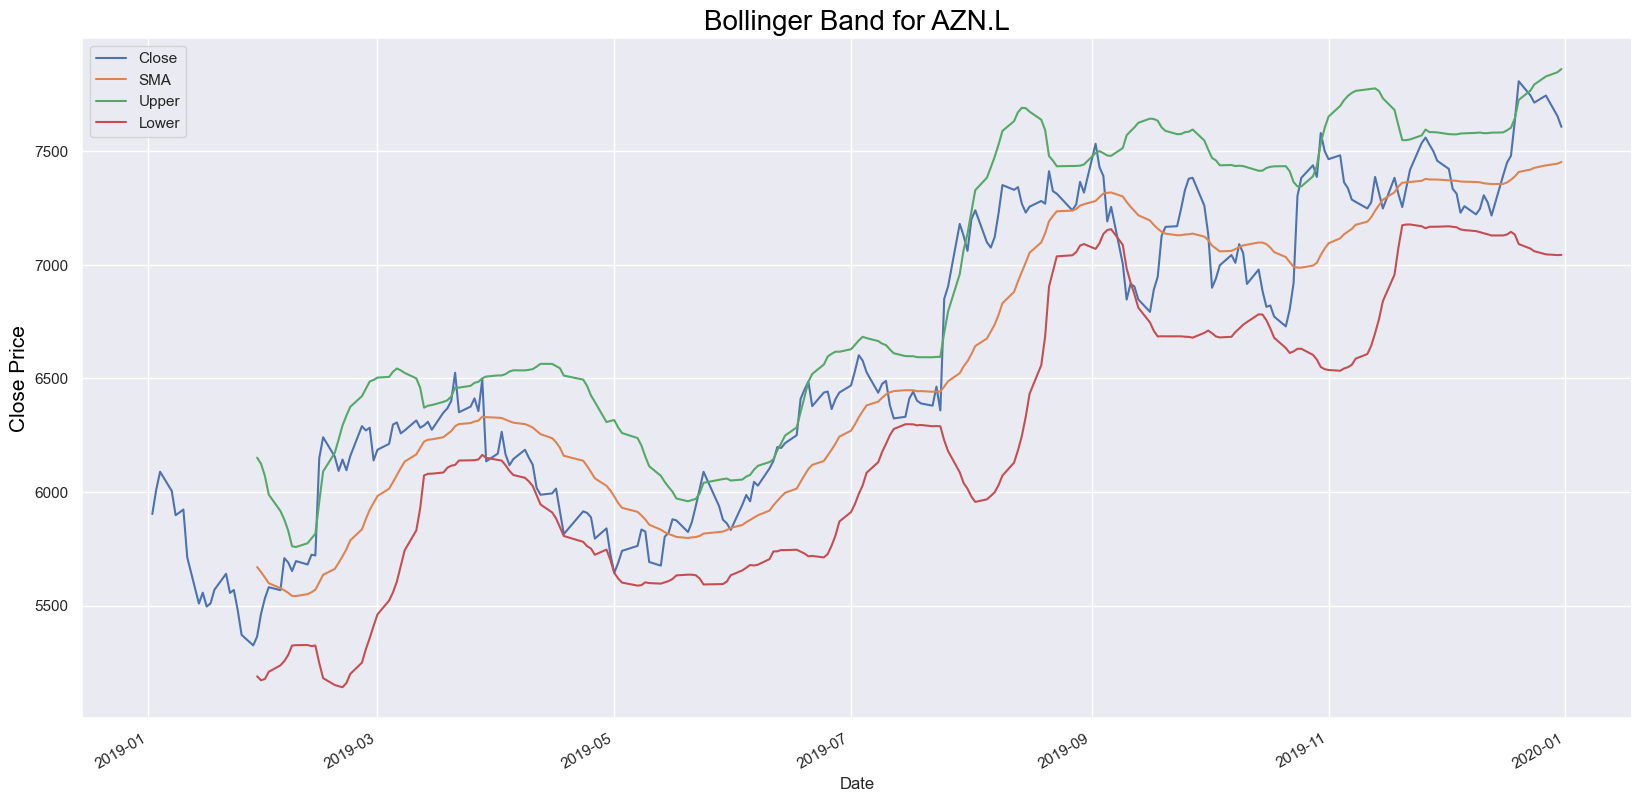

In [278]:
def bb_12mo():
  azn_12mo_bb[column_list].plot(figsize=(20,10))
  plt.style.use('ggplot')
  plt.title('Bollinger Band for AZN.L', color = 'black', fontsize = 20)
  plt.ylabel('Close Price', color = 'black', fontsize = 15)
  plt.show()

bb_12mo()

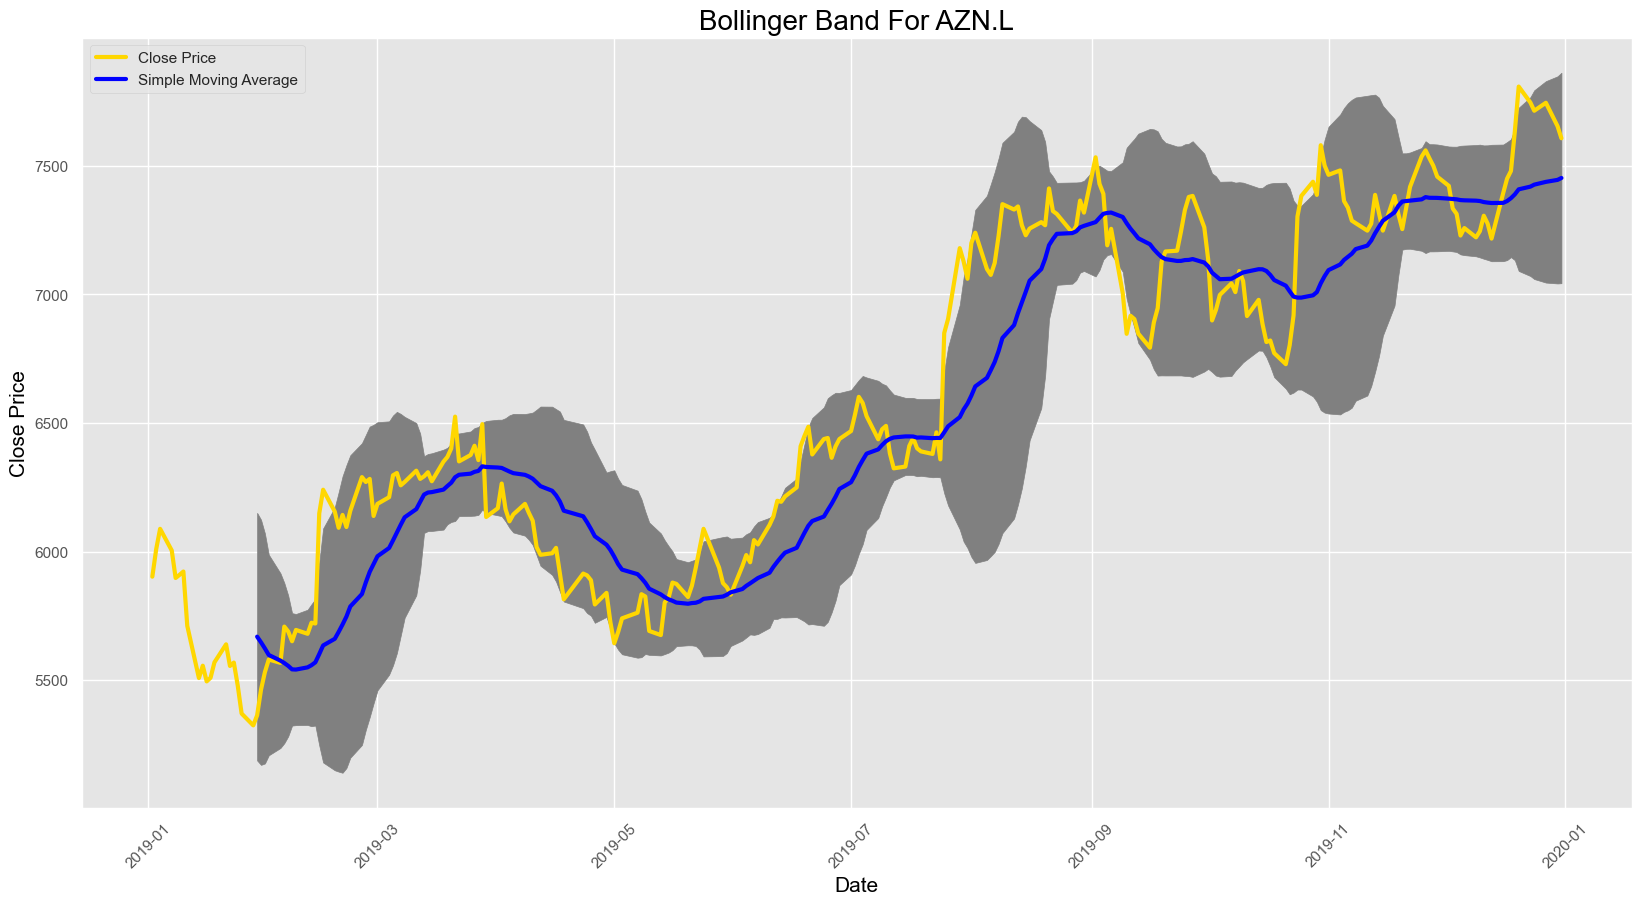

In [279]:
#Plot and shade the area between the two Bollinger bands

def bb_shaded():
  #Get the figure and the figure size
  fig = plt.figure(figsize=(20,10)) 

  #Add the subplot
  ax = fig.add_subplot(1,1,1) #Number of rows, cols, & index

  # Get the index values of the DataFrame
  x_axis = azn_12mo_bb.index

  # Plot and shade the area between the upper band and the lower band Grey
  ax.fill_between(x_axis, azn_12mo_bb['Upper'], azn_12mo_bb['Lower'], color='grey')

  # Plot the Closing Price and Moving Average
  # ax.plot(x_axis, azn_12mo_bb['Close'], color='gold', lw=3, label = 'Close Price') #lw = line width
  ax.plot(azn_12mo_bb['Close'], color='gold', lw=3, label = 'Close Price') #lw = line width

  # ax.plot(x_axis, azn_12mo_bb['SMA'], color='blue', lw=3, label = 'Simple Moving Average')
  ax.plot(azn_12mo_bb['SMA'], color='blue', lw=3, label = 'Simple Moving Average')

  # Set the Title & Show the Image
  ax.set_title('Bollinger Band For AZN.L', color = 'black', fontsize = 20)
  ax.set_xlabel('Date', color = 'black', fontsize = 15)
  ax.set_ylabel('Close Price', color = 'black', fontsize = 15)
  plt.xticks(rotation = 45)
  ax.legend()
  plt.show()

bb_shaded()

In [280]:
#Create a new data frame
new_azn_12mo_bb = azn_12mo_bb[period-1:]
#Show the new data frame
new_azn_12mo_bb.head()

Open    High     Low   Close    Adj Close   Volume      SMA  \
Date                                                                        
2019-01-29  5345.0  5421.0  5322.0  5364.0  4694.751953  2936072  5669.85   
2019-01-30  5364.0  5476.0  5364.0  5464.0  4782.274902  2617662  5647.90   
2019-01-31  5488.0  5559.0  5471.0  5532.0  4841.790039  3086343  5624.00   
2019-02-01  5549.0  5598.0  5532.0  5581.0  4884.677246  1650756  5598.60   
2019-02-04  5580.0  5625.0  5542.0  5568.0  4873.298340  1514636  5576.75   

                   STD        Upper        Lower  
Date                                              
2019-01-29  240.597562  6151.045124  5188.654876  
2019-01-30  238.221016  6124.342033  5171.457967  
2019-01-31  223.504150  6071.008301  5176.991699  
2019-02-01  194.915474  5988.430949  5208.769051  
2019-02-04  169.841373  5916.432747  5237.067253

In [281]:
# Create a function to get the buy and sell signals
def get_signal_bb(data):
  buy_signal = [] #buy list
  sell_signal = [] #sell list

  for i in range(len(data['Close'])):
      if data['Close'][i] > data['Upper'][i]: #Then you should sell 
        buy_signal.append(np.nan)
        sell_signal.append(data['Close'][i])
      elif data['Close'][i] < data['Lower'][i]: #Then you should buy
        sell_signal.append(np.nan)
        buy_signal.append(data['Close'][i])
      else:
        buy_signal.append(np.nan)
        sell_signal.append(np.nan)
  return (buy_signal, sell_signal)

In [282]:
#Create new columns for the buy and sell signals
new_azn_12mo_bb['Buy'] = get_signal_bb(new_azn_12mo_bb)[0]
new_azn_12mo_bb['Sell'] = get_signal_bb(new_azn_12mo_bb)[1]

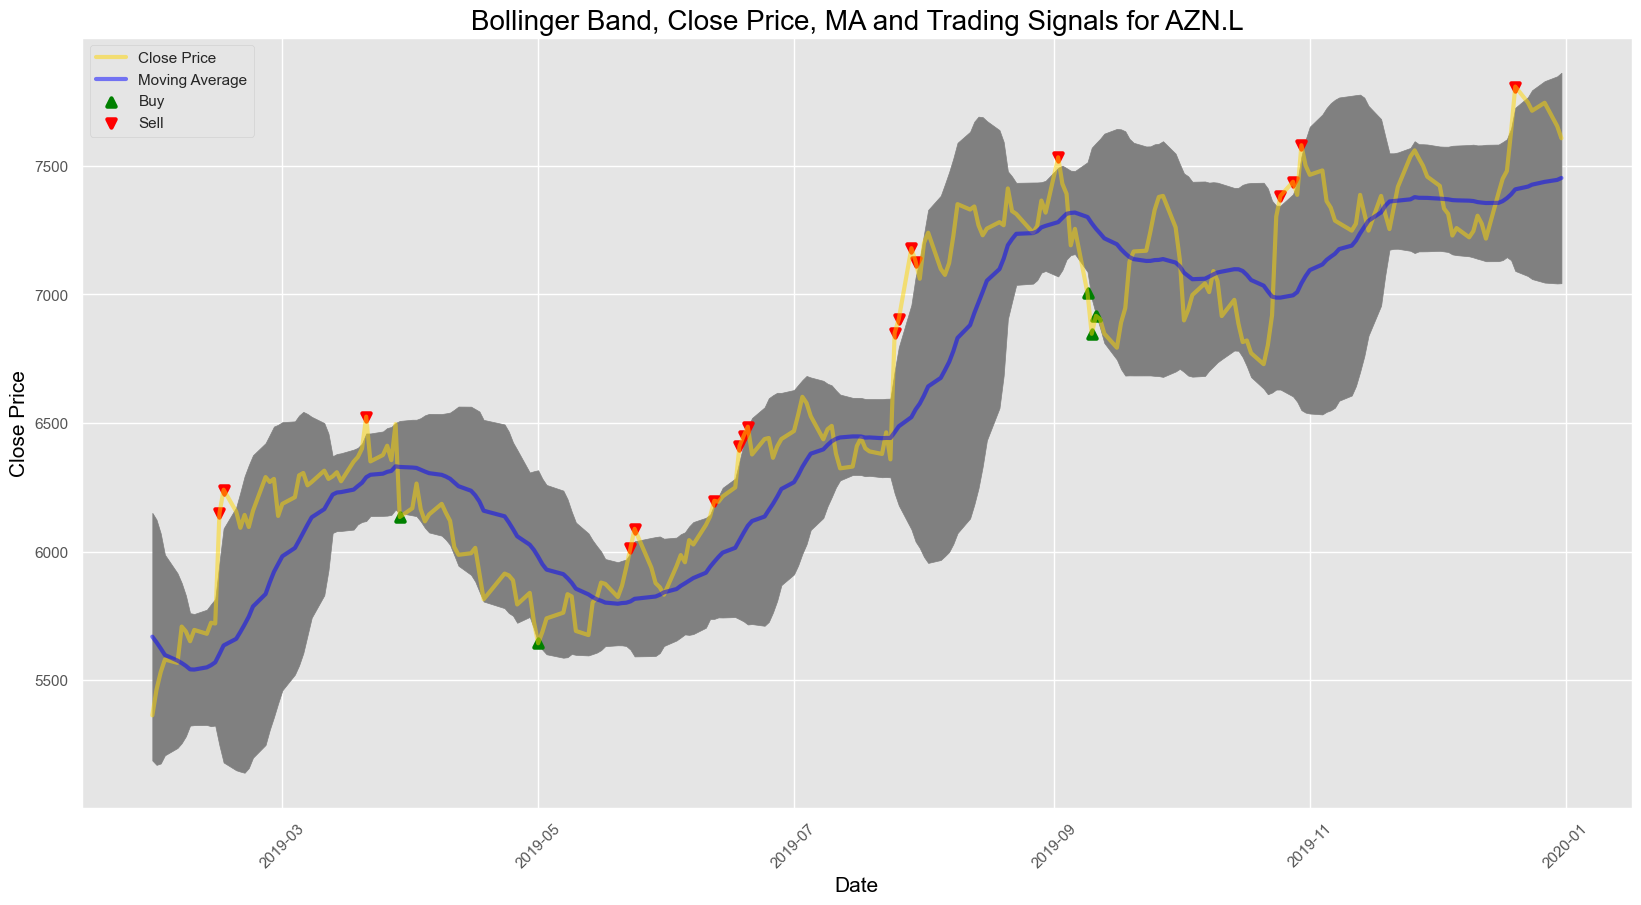

In [283]:
#Plot all of the data

def bb_alldata():
  #Get the figure and the figure size
  fig = plt.figure(figsize=(20,10))

  #Add the subplot
  ax = fig.add_subplot(1,1,1) #Number of rows, cols, & index
  # Get the index values of the DataFrame
  x_axis = new_azn_12mo_bb.index
  # Plot and shade the area between the upper band and the lower band Grey

  ax.fill_between(x_axis, new_azn_12mo_bb['Upper'], new_azn_12mo_bb['Lower'], color='grey')
  # Plot the Closing Price and Moving Average
  # ax.plot(x_axis, new_azn_12mo_bb['Close'], color='gold', lw=3, label = 'Close Price',alpha = 0.5)
  ax.plot(new_azn_12mo_bb['Close'], color='gold', lw=3, label = 'Close Price',alpha = 0.5)

  # ax.plot(x_axis, new_azn_12mo_bb['SMA'], color='blue', lw=3, label = 'Moving Average',alpha = 0.5)
  ax.plot(new_azn_12mo_bb['SMA'], color='blue', lw=3, label = 'Moving Average',alpha = 0.5)

  # ax.scatter(x_axis, new_azn_12mo_bb['Buy'] , color='green', lw=3, label = 'Buy',marker = '^', alpha = 1)
  ax.scatter(x_axis, new_azn_12mo_bb['Buy'] , color='green', lw=3, label = 'Buy',marker = '^', alpha = 1)

  # ax.scatter(x_axis, new_azn_12mo_bb['Sell'] , color='red', lw=3, label = 'Sell',marker = 'v', alpha = 1)
  ax.scatter(x_axis, new_azn_12mo_bb['Sell'] , color='red', lw=3, label = 'Sell',marker = 'v', alpha = 1)

  # Set the Title & Show the Image
  ax.set_title('Bollinger Band, Close Price, MA and Trading Signals for AZN.L', color = 'black', fontsize = 20)
  ax.set_xlabel('Date', color = 'black', fontsize = 15)
  ax.set_ylabel('Close Price', color = 'black', fontsize = 15)
  plt.xticks(rotation = 45)
  ax.legend()
  plt.show()

bb_alldata()

The Bollinger Bands technical indicator is an example of a mean reversion strategy. 

## 5.4 Volume Trading Strategies

Volume trading is a measure of how much of a given financial asset has traded in a period of time. Volume traders look for instances of increased buying or selling orders. They also pay attention to current price trends and potential price movements. Generally, increased trading volume will lean heavily towards buy orders.

### 5.4.1 On Balance Volume (OBV)

OBV is a momentum-based indicator which measures volume flow to gauge the direction of the trend. Volume and price rise are directly proportional and OBV can be used as a confirmation tool with regards to price trends. A rising price is depicted by a rising OBV and a falling OBV stands for a falling price. 

It is a  cumulative total of the up and down volume. When the close is higher than the previous close, the volume is added to the running
total, and when the close is lower than the previous close, the volume is subtracted
from the running total.

In [284]:
# Create copy of dataframe for AZN.L stock

azn_obv = azn.copy()
azn_obv.head()

Open         High          Low   Close    Adj Close   Volume
Date                                                                      
2013-01-02  2930.0  2969.297119  2923.000000  2969.0  1974.841675  2394731
2013-01-03  2969.5  2982.500000  2952.500000  2980.0  1982.158203  1763172
2013-01-04  2992.5  3005.000000  2975.211914  3000.0  1995.461304  2041101
2013-01-07  2998.5  3004.989990  2976.000000  2985.0  1985.483765  1185261
2013-01-08  2986.5  3005.500000  2958.500000  3000.0  1995.461304  2723178

In [285]:
# Create dataframe for slice of AZN.L stock for 6 months July - Dec 2019

azn_obv_6mo = azn_obv['2022-07-01':'2022-12-31']
azn_obv_6mo.head()

Open     High      Low    Close     Adj Close   Volume
Date                                                                 
2022-07-01  10722.0  10782.0  10568.0  10754.0  10459.293945  2197334
2022-07-04  10808.0  10898.0  10770.0  10808.0  10511.814453   943491
2022-07-05  10858.0  10900.0  10668.0  10800.0  10504.034180  3156736
2022-07-06  10892.0  11092.0  10880.0  10978.0  10677.156250  2232503
2022-07-07  11110.0  11170.0  10990.0  11004.0  10702.442383  2583073

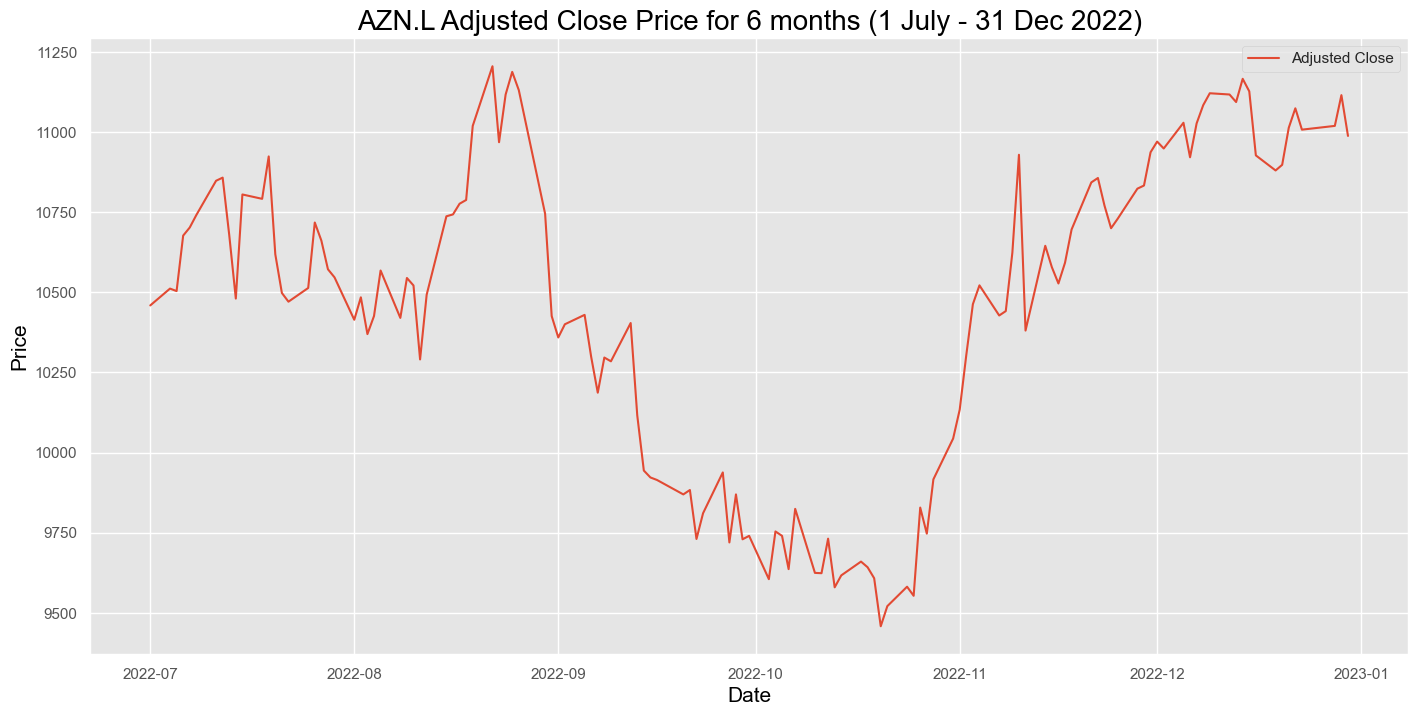

In [286]:
# Plot AZN.L Adjusted Close price for the time period

def obv_adj():
  plt.figure(figsize=(17, 8))
  plt.style.use('ggplot')
  plt.plot(azn_obv_6mo['Adj Close'], label = 'Adjusted Close')
  plt.title('AZN.L Adjusted Close Price for 6 months (1 July - 31 Dec 2022)', color = 'black', fontsize = 20)
  plt.xlabel('Date', color = 'black', fontsize = 15)
  plt.ylabel('Price', color = 'black', fontsize = 15)
  plt.legend()
  plt.show()

obv_adj()

In [287]:
# Calculate the OBV

OBV = []
OBV.append(0)

for i in range(1, len(azn_obv_6mo['Adj Close'])):
  if azn_obv_6mo['Adj Close'][i] > azn_obv_6mo['Adj Close'][i-1]:
    OBV.append(OBV[-1] + azn_obv_6mo.Volume[i])
  elif azn_obv_6mo['Adj Close'][i] < azn_obv_6mo['Adj Close'][i-1]:
    OBV.append(OBV[-1] - azn_obv_6mo.Volume[i])
  else:
    OBV.append(OBV[-1])


In [288]:
# Store OBV and OBV EMA in new columns

azn_obv_6mo['OBV'] = OBV
azn_obv_6mo['OBV_EMA'] = azn_obv_6mo['OBV'].ewm(span=20).mean()
azn_obv_6mo.head()

Open     High      Low    Close     Adj Close   Volume  \
Date                                                                    
2022-07-01  10722.0  10782.0  10568.0  10754.0  10459.293945  2197334   
2022-07-04  10808.0  10898.0  10770.0  10808.0  10511.814453   943491   
2022-07-05  10858.0  10900.0  10668.0  10800.0  10504.034180  3156736   
2022-07-06  10892.0  11092.0  10880.0  10978.0  10677.156250  2232503   
2022-07-07  11110.0  11170.0  10990.0  11004.0  10702.442383  2583073   

                OBV        OBV_EMA  
Date                                
2022-07-01        0       0.000000  
2022-07-04   943491  495332.775000  
2022-07-05 -2213245 -499240.746045  
2022-07-06    19258 -349558.174751  
2022-07-07  2602331  364478.696590

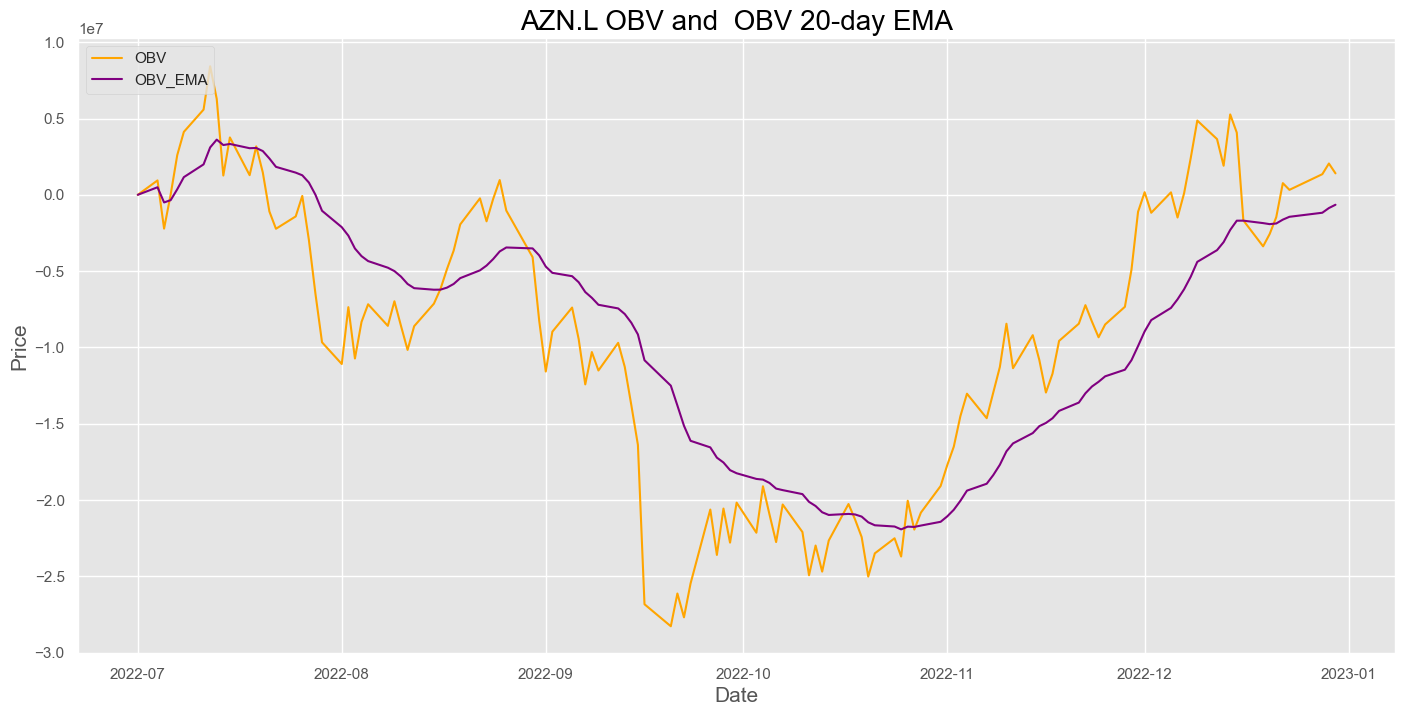

In [289]:
# Plot OBV and OBV with EMA of 20 days

def obv_ema():
  plt.figure(figsize=(17, 8))
  plt.style.use('ggplot')
  plt.plot(azn_obv_6mo['OBV'], label = 'OBV', color = 'orange')
  plt.plot(azn_obv_6mo['OBV_EMA'], label = 'OBV_EMA', color = 'purple')
  plt.title('AZN.L OBV and  OBV 20-day EMA', color = 'black', fontsize = 20)
  plt.xlabel('Date', fontsize = 15)
  plt.ylabel('Price', fontsize = 15)
  plt.legend(loc = 'upper left')
  plt.show()

obv_ema()

The strategy is to buy the stock whenever the OBV goes above the OBV EMA and sell whenever the OBV EMA goes above the OBV.

In [290]:
# Create function to signal when to buy and sell the stock
# If OBV > OBV_EMA then buy
# If OBV < OBV_EMA then sell
# Else do nothing

def buy_sell_obv(signal, col1, col2):
  sigPriceBuy = []
  sigPriceSell = []
  flag = -1

  for i in range(0, len(signal)):
    # If OBV > OBV_EMA then buy --> col1 => If OBV < OBV_EMA then sell => 'OBV_EMA'
    if signal[col1][i] < signal[col2][i] and flag != 1:
      sigPriceBuy.append(signal['Adj Close'][i])
      sigPriceSell.append(np.nan)
      flag = 1
     # If OBV < OBV_EMA then sell
    elif signal[col1][i] > signal[col2][i] and flag != 0:
      sigPriceSell.append(signal['Adj Close'][i])
      sigPriceBuy.append(np.nan)
      flag = 0
    else:
      sigPriceSell.append(np.nan)
      sigPriceBuy.append(np.nan)

  return (sigPriceBuy, sigPriceSell)

In [291]:
# Create buy and sell columns

x = buy_sell_obv(azn_obv_6mo, 'OBV', 'OBV_EMA')
azn_obv_6mo['Buy_Signal_Price'] = x[0]
azn_obv_6mo['Sell_Signal_Price'] = x[1]

azn_obv_6mo.head()

Open     High      Low    Close     Adj Close   Volume  \
Date                                                                    
2022-07-01  10722.0  10782.0  10568.0  10754.0  10459.293945  2197334   
2022-07-04  10808.0  10898.0  10770.0  10808.0  10511.814453   943491   
2022-07-05  10858.0  10900.0  10668.0  10800.0  10504.034180  3156736   
2022-07-06  10892.0  11092.0  10880.0  10978.0  10677.156250  2232503   
2022-07-07  11110.0  11170.0  10990.0  11004.0  10702.442383  2583073   

                OBV        OBV_EMA  Buy_Signal_Price  Sell_Signal_Price  
Date                                                                     
2022-07-01        0       0.000000               NaN                NaN  
2022-07-04   943491  495332.775000               NaN       10511.814453  
2022-07-05 -2213245 -499240.746045       10504.03418                NaN  
2022-07-06    19258 -349558.174751               NaN       10677.156250  
2022-07-07  2602331  364478.696590               NaN                NaN

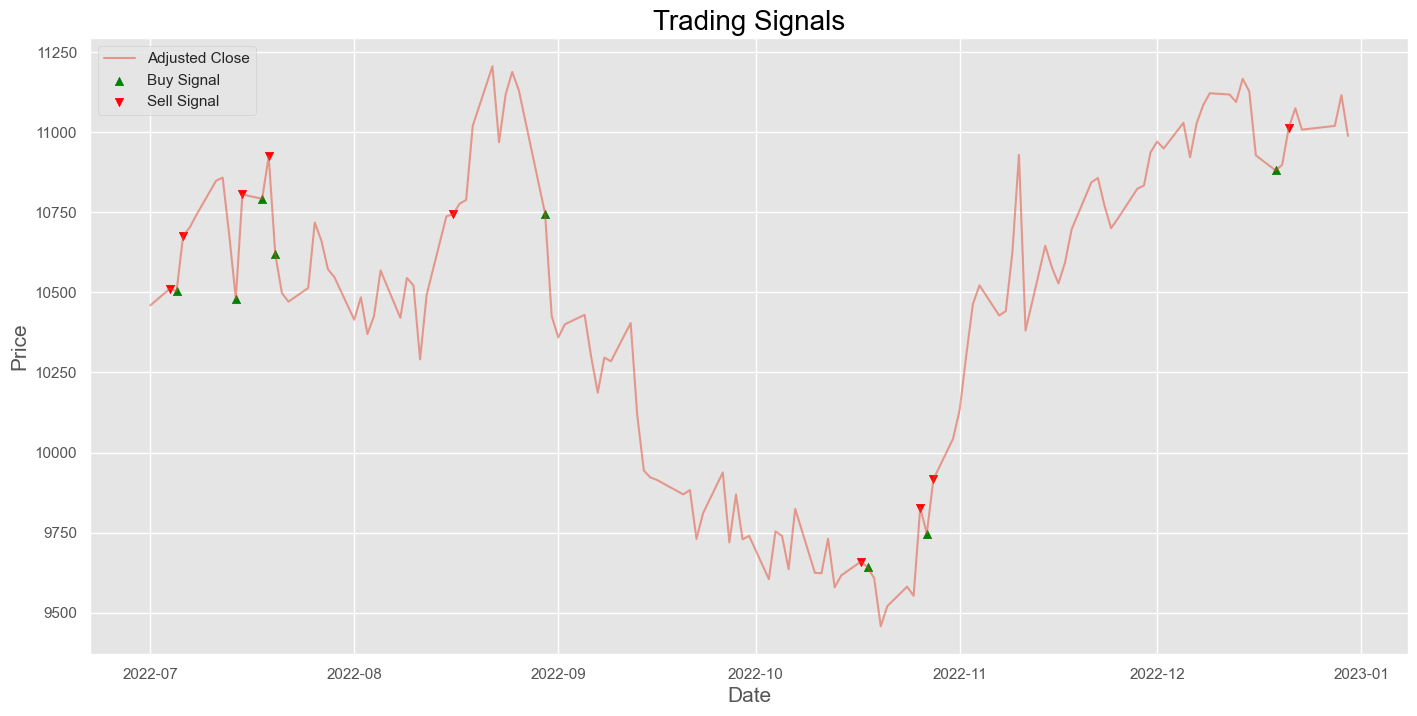

In [292]:
# Plot buy and sell trading signals

def obv_sig():
  plt.figure(figsize=(17, 8))
  plt.style.use('ggplot')
  plt.plot(azn_obv_6mo['Adj Close'], label = 'Adjusted Close', alpha = 0.5)
  plt.scatter(azn_obv_6mo.index, azn_obv_6mo['Buy_Signal_Price'], label = 'Buy Signal', marker = '^', alpha = 1, color = 'green')
  plt.scatter(azn_obv_6mo.index, azn_obv_6mo['Sell_Signal_Price'], label = 'Sell Signal', marker = 'v', alpha = 1, color = 'red')
  plt.title('Trading Signals', color = 'black', fontsize = 20)
  plt.xlabel('Date', fontsize = 15)
  plt.ylabel('Price', fontsize = 15)
  plt.legend(loc = 'upper left')
  plt.show()

obv_sig()

## 6. Conclusion

It is almost certainly better to choose technical indicators that complement each other, not just those that move in unison and generate the same signals. The intuition here is that the more indicators you have that confirm each other, the better your chances are to profit. This can be done by combining strategies to form a system, and looking for multiple signals.